# Base Dataset: Data Prep and Modelling

First, a python script containing useful functions is run. This script include setting up a `FalsePositive` class and creating functions for `class_weight` and model evaluations. It also contains all the imports used in this notebook. The dependencies for the notebook are as follows: tensorflow, matplotlib, numpy, pandas, sklearn, and imblearn.

In [2]:
%run functions.py

---

## Data Prep

The first step of preparing the data is to read it in and get an idea of the data types of each column. In order to see the number of unique entries per column, a simple loop was defined to achieve this. This gives insight as to whether the data in the column is binary, categorical, or numerical.

In [2]:
base = pd.read_csv('data/Base.csv')

In [3]:
base.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           1     0.9               0.166828                         -1   
1           1     0.9               0.296286                         -1   
2           1     0.9               0.044985                         -1   
3           1     0.9               0.159511                         -1   
4           1     0.9               0.596414                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            88            50            0.020925   
1                           144            50            0.005418   
2                           132            40            3.108549   
3                            22            50            0.019079   
4                           218            50            0.004441   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0               -1.331345           AA           769  ...                0   
1               -0.816224           AB           366  ...                0   
2               -0.755728           AC           870  ...                0   
3               -1.205124           AB           810  ...                1   
4               -0.773276           AB           890  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                  500.0                0  INTERNET   
1                 1500.0                0  INTERNET   
2                  200.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                 1500.0                0  INTERNET   

   session_length_in_minutes  device_os  keep_alive_session  \
0                   3.888115    windows                   0   
1                  31.798819    windows                   0   
2                   4.728705      other                   0   
3                   2.047904      linux                   0   
4                   3.775225  macintosh                   1   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      7  
1                          1                  0      7  
2                          1                  0      7  
3                          1                  0      7  
4                          1                  0      7  

[5 rows x 32 columns]

In [4]:
for column in base:
    print('{}: {} unique values'.format(column, len(base[column].unique())))

fraud_bool: 2 unique values
income: 9 unique values
name_email_similarity: 998861 unique values
prev_address_months_count: 374 unique values
current_address_months_count: 423 unique values
customer_age: 9 unique values
days_since_request: 989330 unique values
intended_balcon_amount: 994971 unique values
payment_type: 5 unique values
zip_count_4w: 6306 unique values
velocity_6h: 998687 unique values
velocity_24h: 998940 unique values
velocity_4w: 998318 unique values
bank_branch_count_8w: 2326 unique values
date_of_birth_distinct_emails_4w: 40 unique values
employment_status: 7 unique values
credit_risk_score: 551 unique values
email_is_free: 2 unique values
housing_status: 7 unique values
phone_home_valid: 2 unique values
phone_mobile_valid: 2 unique values
bank_months_count: 33 unique values
has_other_cards: 2 unique values
proposed_credit_limit: 12 unique values
foreign_request: 2 unique values
source: 2 unique values
session_length_in_minutes: 994887 unique values
device_os: 5 uniqu

In order to account for bias, `customer_age` will be considered a protected attribute as in the original paper. To account for this `customer_age` was split into an above 50 and below 50 category.

In [5]:
pd.options.mode.chained_assignment = None 

base['customer_age'].loc[base.customer_age <= 50] = 0
base['customer_age'].loc[base.customer_age > 50] =1

Lists are created seperating the features into `categorical_features` and `binary_features`. The `categorical_features` are then OneHotEncoded, resulting in a new DataFrame, `cat_encoded`. The `binary_features` are also defined as `binary_encoded`. Finally, the numeric features are defined by dropping non-numeric features as well as irrelevant columns into a DataFrame called `numeric_features`. These three new DataFrames are concatenated and the features are renamed as `featureX` where X is an integer. Finally, the resulting DataFrame is concatenated with the month column. The reasoning behind this will be discussed below.

In [6]:
categorical_features = [
    'income',
    'payment_type',
    'employment_status',
    'housing_status',
    'source',
    'device_os',
    'device_distinct_emails_8w'
]

binary_features = [
    'customer_age',
    'email_is_free',
    'phone_home_valid',
    'phone_mobile_valid',
    'has_other_cards',
    'foreign_request',
    'keep_alive_session'
]

In [7]:
ohe = OneHotEncoder(sparse=False)

cat_encoded = pd.DataFrame(ohe.fit_transform(base[categorical_features]))

cat_encoded.head()

0    1    2    3    4    5    6    7    8    9   ...   29   30   31   32  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  1.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  1.0  0.0   

    33   34   35   36   37   38  
0  1.0  0.0  0.0  0.0  1.0  0.0  
1  1.0  0.0  0.0  0.0  1.0  0.0  
2  0.0  0.0  0.0  0.0  1.0  0.0  
3  0.0  0.0  0.0  0.0  1.0  0.0  
4  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 39 columns]

In [8]:
binary_encoded = base[binary_features]

binary_encoded.head()

customer_age  email_is_free  phone_home_valid  phone_mobile_valid  \
0             0              0                 1                   0   
1             0              1                 0                   0   
2             0              1                 0                   1   
3             0              1                 0                   1   
4             0              1                 1                   0   

   has_other_cards  foreign_request  keep_alive_session  
0                0                0                   0  
1                0                0                   0  
2                0                0                   0  
3                1                0                   0  
4                0                0                   1

In [9]:
numeric_features = base.drop(categorical_features, axis=1) \
.drop(binary_features, axis=1). \
drop(['device_fraud_count', 'fraud_bool', 'month'], axis=1)

numeric_features.head()

name_email_similarity  prev_address_months_count  \
0               0.166828                         -1   
1               0.296286                         -1   
2               0.044985                         -1   
3               0.159511                         -1   
4               0.596414                         -1   

   current_address_months_count  days_since_request  intended_balcon_amount  \
0                            88            0.020925               -1.331345   
1                           144            0.005418               -0.816224   
2                           132            3.108549               -0.755728   
3                            22            0.019079               -1.205124   
4                           218            0.004441               -0.773276   

   zip_count_4w   velocity_6h  velocity_24h  velocity_4w  \
0           769  10650.765523   3134.319630  3863.647740   
1           366    534.047319   2670.918292  3124.298166   
2           870   4048.534263   2893.621498  3159.590679   
3           810   3457.064063   4054.908412  3022.261812   
4           890   5020.341679   2728.237159  3087.670952   

   bank_branch_count_8w  date_of_birth_distinct_emails_4w  credit_risk_score  \
0                     1                                 6                185   
1                   718                                 3                259   
2                     1                                14                177   
3                  1921                                 6                110   
4                  1990                                 2                295   

   bank_months_count  proposed_credit_limit  session_length_in_minutes  
0                 24                  500.0                   3.888115  
1                 15                 1500.0                  31.798819  
2                 -1                  200.0                   4.728705  
3                 31                  200.0                   2.047904  
4                 31                 1500.0                   3.775225

In [10]:
X = pd.concat([numeric_features, binary_encoded, cat_encoded], axis=1)

In [11]:
i=0
for column in X:
    X.rename(columns={column:f'feature{i}'}, inplace=True)
    i+=1
    
X = pd.concat([X, base.month], axis=1)

X.head()

feature0  feature1  feature2  feature3  feature4  feature5      feature6  \
0  0.166828        -1        88  0.020925 -1.331345       769  10650.765523   
1  0.296286        -1       144  0.005418 -0.816224       366    534.047319   
2  0.044985        -1       132  3.108549 -0.755728       870   4048.534263   
3  0.159511        -1        22  0.019079 -1.205124       810   3457.064063   
4  0.596414        -1       218  0.004441 -0.773276       890   5020.341679   

      feature7     feature8  feature9  ...  feature52  feature53  feature54  \
0  3134.319630  3863.647740         1  ...        0.0        0.0        0.0   
1  2670.918292  3124.298166       718  ...        0.0        0.0        0.0   
2  2893.621498  3159.590679         1  ...        0.0        0.0        1.0   
3  4054.908412  3022.261812      1921  ...        1.0        0.0        0.0   
4  2728.237159  3087.670952      1990  ...        0.0        1.0        0.0   

   feature55  feature56  feature57  feature58  feature59  feature60  month  
0        1.0        0.0        0.0        0.0        1.0        0.0      7  
1        1.0        0.0        0.0        0.0        1.0        0.0      7  
2        0.0        0.0        0.0        0.0        1.0        0.0      7  
3        0.0        0.0        0.0        0.0        1.0        0.0      7  
4        0.0        0.0        0.0        0.0        1.0        0.0      7  

[5 rows x 62 columns]

Now that the data has been cleaned, the data needs to be split into a training set, a validation set, and a test set. In order to achieve this, the data will be split temporally rather than at random. This is typically done in the fraud space; therefore, it is reasonable to do for this data set. `X_train` will consist of data with a `month` value equalling any value in the range 0 to 5, `X_val` data will consist of data with a `month` value of 6, and finally, `X_test` will consist of data with a `month` value of 7. 

In [12]:
X.month.value_counts()

3    150936
2    136979
0    132440
4    127691
1    127620
5    119323
6    108168
7     96843
Name: month, dtype: int64

In [13]:
y = base.fraud_bool

y.value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

In [14]:
X_train = X.loc[X.month < 6].drop('month', axis=1)
y_train = base.fraud_bool.loc[base.month < 6]

X_train.shape, y_train.shape

((794989, 61), (794989,))

In [15]:
X_val = X.loc[X.month == 6].drop('month', axis=1)
y_val = base.fraud_bool.loc[base.month == 6]

X_val.shape, y_val.shape

((108168, 61), (108168,))

In [16]:
X_test = X.loc[X.month == 7].drop('month', axis=1)
y_test = base.fraud_bool.loc[base.month == 7]

X_test.shape, y_test.shape

((96843, 61), (96843,))

Finally, `X_train`, `X_val`, and `X_test` are scaled using Standard Scaler. The data is now prepared for a baseline model.

In [17]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)

---

## Data Modelling

### Baseline Model and Simple Iterations

The first step in modelling is to define `n_features`, the number of features in our data, for the input layer. Our baseline model is defined using a function `baseline_model`. This function can take inputs for number of epochs, batch size, and threshold and defaults to certain values. These parameters will not come into play for the `baseline_model`; however, they were included in order to keep consistent formatting. The `baseline_model` function creates a sequential model with an input layer of shape (`n_features`, ), followed by two hidden layers with relu activation and dimensionality 32 and 16, and finally an output layer for a binary classifier. Our performance metric is going to be recall with various targets for false positive rate; therefore, the metrics used throughout this notebook will be AUC, recall, and false positive rate. The `evaluate` function defined in `functions.py` is then utilized to print out some model metrics as well as useful visualizations for evaluating model performance.

In [9]:
X_train_base_scaled = pd.read_csv('Data/base/X_train_base_scaled.csv')
y_train_base = pd.read_csv('Data/base/y_train_base.csv')
X_val_base_scaled = pd.read_csv('Data/base/X_val_base_scaled.csv')
y_val_base = pd.read_csv('Data/base/y_val_base.csv')

In [10]:
n_features = X_train_base_scaled.shape[1]

In [13]:
def baseline_model(epochs=20, batch_size=512, threshold=0.5):
    
    b_baseline_model = models.Sequential()

    b_baseline_model.add(layers.Input(shape=(n_features, )))
    b_baseline_model.add(layers.Dense(32, activation='relu'))
    b_baseline_model.add(layers.Dense(16, activation='relu'))
    b_baseline_model.add(layers.Dense(1, activation='sigmoid'))

    b_baseline_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['AUC',
                                  tf.keras.metrics.Recall(thresholds=threshold),
                                  FalsePositiveRate(threshold=threshold)])

    b_baseline_model_history = b_baseline_model.fit(X_train_base_scaled,
                                                    y_train_base,
                                                    batch_size=batch_size,
                                                    validation_data=(X_val_base_scaled, y_val_base),
                                                    epochs=epochs,
                                                    verbose=1
                                                   ).history
    
    evaluate(b_baseline_model, b_baseline_model_history, X_val_base_scaled, y_val_base, threshold=threshold)

Epoch 1/20
1553/1553 [==============================] - 2s 1ms/step - loss: 0.0487 - auc: 0.8309 - recall_2: 0.0037 - false_positive_rate: 4.1940e-05 - val_loss: 0.0563 - val_auc: 0.8580 - val_recall_2: 0.0034 - val_false_positive_rate: 2.8111e-05
Epoch 2/20
1553/1553 [==============================] - 1s 825us/step - loss: 0.0441 - auc: 0.8632 - recall_2: 0.0088 - false_positive_rate: 5.7191e-05 - val_loss: 0.0545 - val_auc: 0.8701 - val_recall_2: 0.0055 - val_false_positive_rate: 5.6223e-05
Epoch 3/20
1553/1553 [==============================] - 1s 806us/step - loss: 0.0437 - auc: 0.8664 - recall_2: 0.0115 - false_positive_rate: 6.1004e-05 - val_loss: 0.0543 - val_auc: 0.8691 - val_recall_2: 0.0097 - val_false_positive_rate: 1.1245e-04
Epoch 4/20
1553/1553 [==============================] - 1s 804us/step - loss: 0.0433 - auc: 0.8705 - recall_2: 0.0140 - false_positive_rate: 8.5151e-05 - val_loss: 0.0553 - val_auc: 0.8617 - val_recall_2: 0.0069 - val_false_positive_rate: 1.3119e-04
Ep

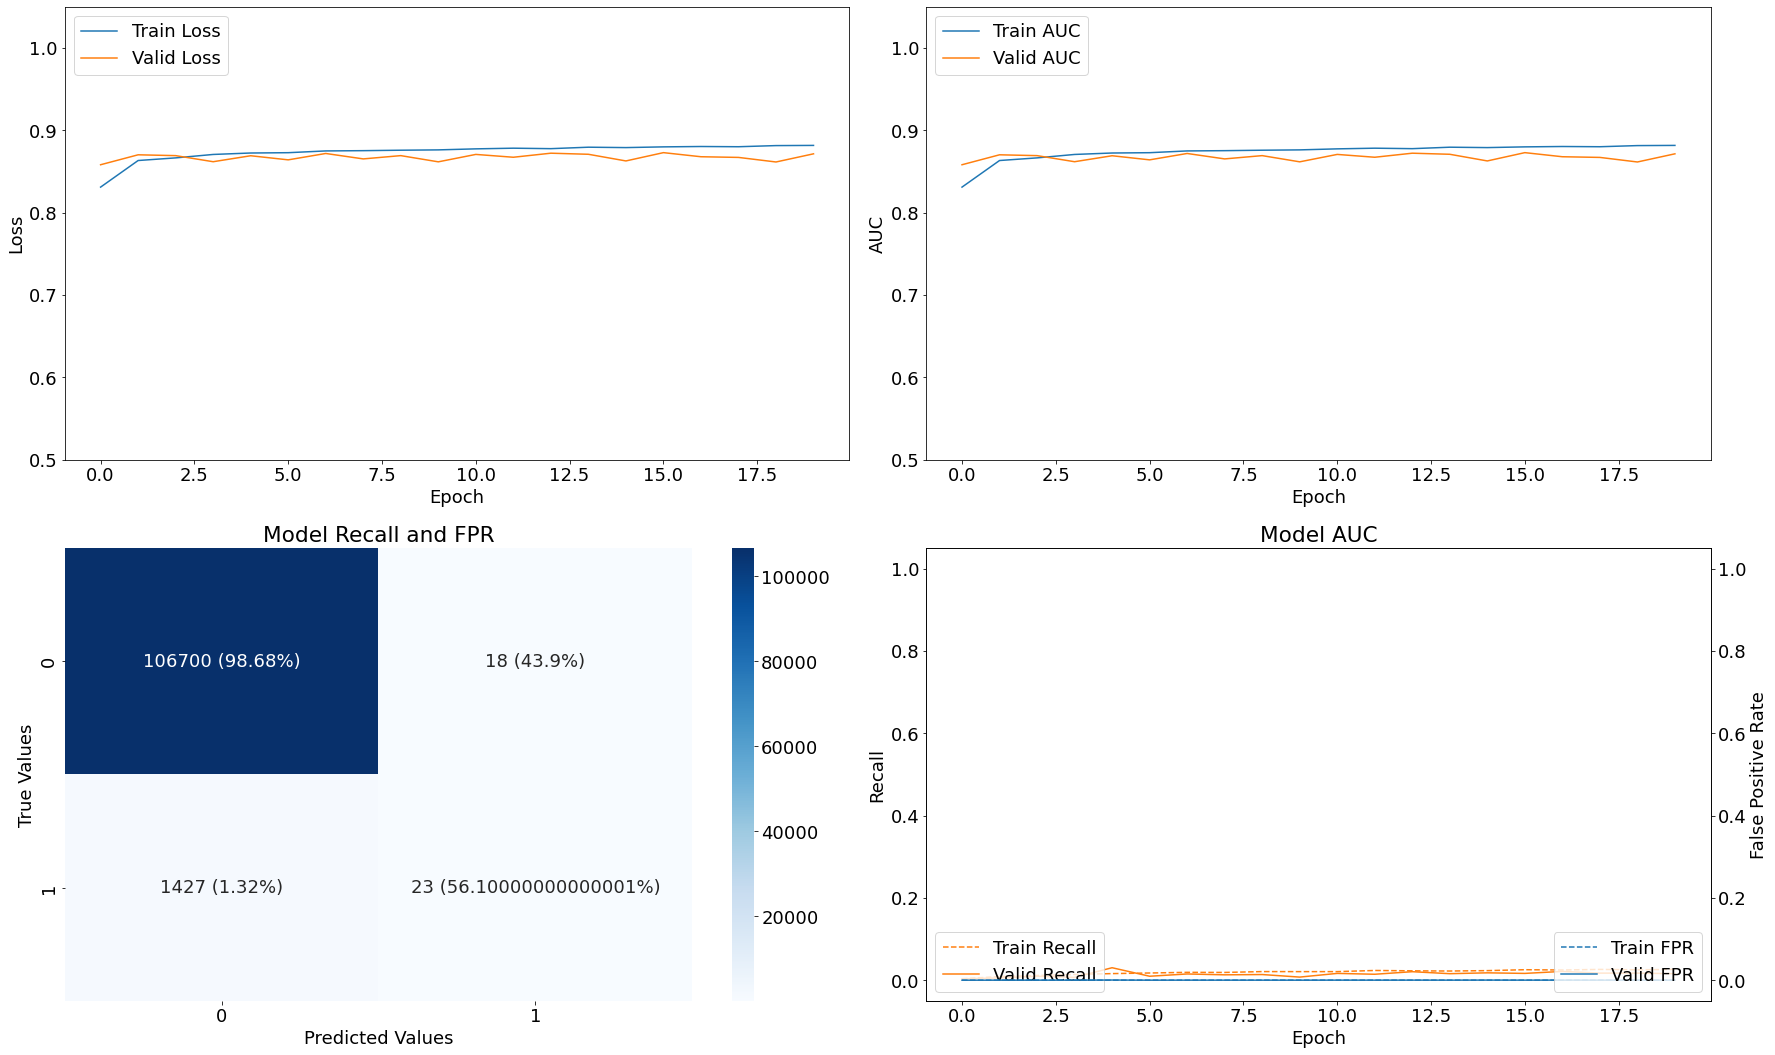

In [14]:
baseline_model()

In [17]:
def model_v1(epochs=20, batch_size=512, threshold=0.5):
    b_model_v1 = models.Sequential()

    b_model_v1.add(layers.Input(shape=(n_features, )))
    b_model_v1.add(layers.Dense(32, activation='relu'))
    b_model_v1.add(layers.Dropout(0.5))
    b_model_v1.add(layers.Dense(16, activation='relu'))
    b_model_v1.add(layers.Dropout(0.5))
    b_model_v1.add(layers.Dense(1, activation='sigmoid'))

    b_model_v1.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_model_v1_history = b_model_v1.fit(X_train_base_scaled,
                                        y_train_base,
                                        batch_size=batch_size,
                                        validation_data=(X_val_base_scaled, y_val_base),
                                        epochs=epochs, 
                                        verbose=0).history
    
    evaluate(b_model_v1, b_model_v1_history, X_val_base_scaled, y_val_base, threshold=threshold)

Results for model with threshold = 0.5.

 Train recall: 0.00993743073195219 
 Val Recall: 0.0 

 Train FPR: 0.00013725824828725308 
 Val FPR: 0.0


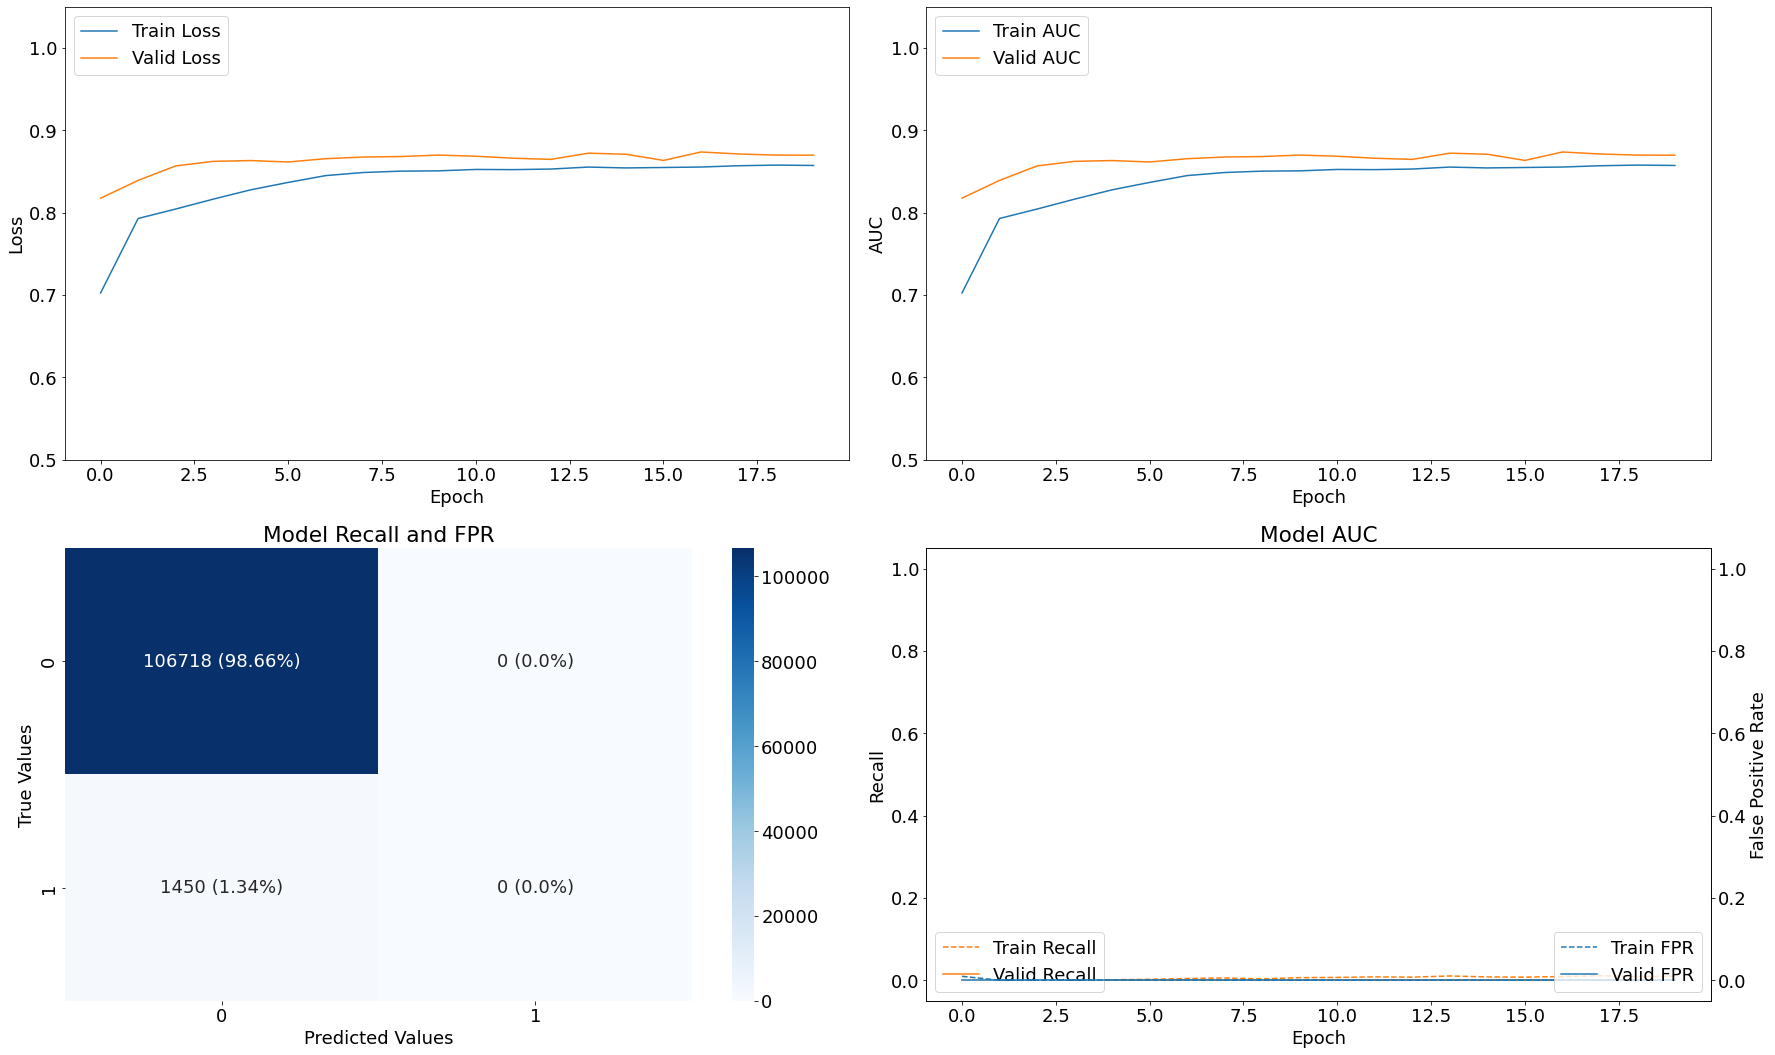

In [18]:
model_v1()

794989

In [26]:
class_weight = create_class_weight({0: len(y_train_base == 0), 1: len(y_train_base == 1)})

In [27]:
def model_v2(epochs=20, batch_size=512, threshold=0.5):
    
    b_model_v2 = models.Sequential()

    b_model_v2.add(layers.Input(shape=(n_features, )))
    b_model_v2.add(layers.Dense(32, activation='relu'))
    b_model_v2.add(layers.Dropout(0.5))
    b_model_v2.add(layers.Dense(16, activation='relu'))
    b_model_v2.add(layers.Dropout(0.5))
    b_model_v2.add(layers.Dense(1, activation='sigmoid'))

    b_model_v2.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_model_v2_history = b_model_v2.fit(X_train_base_scaled,
                                        y_train_base,
                                        batch_size=batch_size,
                                        validation_data=(X_val_base_scaled, y_val_base),
                                        class_weight=class_weight,
                                        epochs=epochs, 
                                        verbose=0).history
    
    evaluate(b_model_v2, b_model_v2_history, X_val_base_scaled, y_val_base, threshold=threshold)

Results for model with threshold = 0.5.

 Train recall: 0.007361060008406639 
 Val Recall: 0.0 

 Train FPR: 0.00011056914081564173 
 Val FPR: 0.0


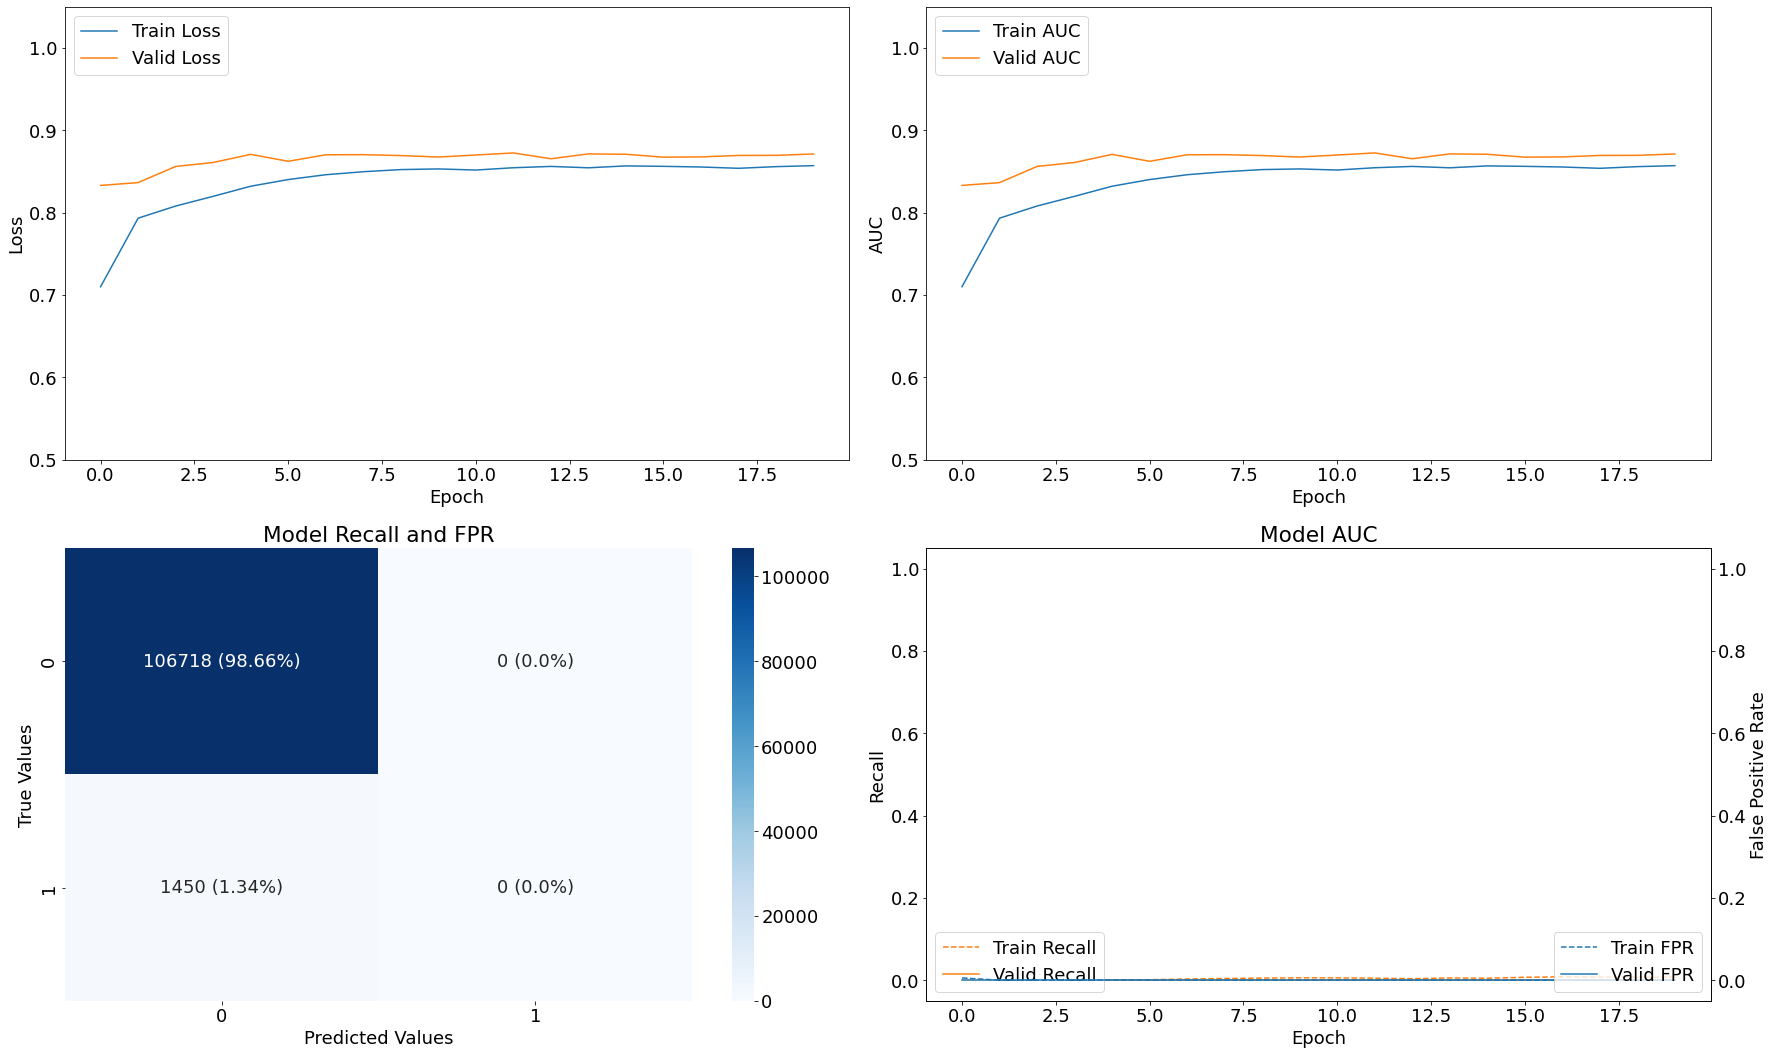

In [28]:
model_v2()

In [19]:
X_train_scaled_resampled, y_train_resampled = \
SMOTE(random_state=21, sampling_strategy=0.25).fit_resample(X_train_scaled,y_train)

In [29]:
y_train_resampled.value_counts()

0    786838
1    196709
Name: fraud_bool, dtype: int64

In [35]:
X_train_base_scaled_resampled = pd.read_csv('Data/base/X_train_base_scaled_resampled.csv')
y_train_base_resampled = pd.read_csv('Data/base/y_train_base_resampled.csv')

In [36]:
def model_v3(epochs=20, batch_size=512, threshold=0.5):    
    
    b_model_v3 = models.Sequential()

    b_model_v3.add(layers.Input(shape=(n_features, )))
    b_model_v3.add(layers.Dense(32, activation='relu'))
    b_model_v3.add(layers.Dropout(0.5))
    b_model_v3.add(layers.Dense(16, activation='relu'))
    b_model_v3.add(layers.Dropout(0.5))
    b_model_v3.add(layers.Dense(1, activation='sigmoid'))

    b_model_v3.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_model_v3_history = b_model_v3.fit(X_train_base_scaled_resampled,
                                        y_train_base_resampled,
                                        batch_size=batch_size,
                                        validation_data=(X_val_base_scaled, y_val_base),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=1).history

    print(b_model_v3_history)
    
    evaluate(b_model_v3, b_model_v3_history, X_val_base_scaled, y_val_base, threshold=threshold)

In [37]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]

Epoch 1/20
1921/1921 [==============================] - 3s 1ms/step - loss: 0.3416 - auc: 0.8734 - recall_9: 0.4677 - false_positive_rate: 0.0484 - val_loss: 0.1406 - val_auc: 0.8778 - val_recall_9: 0.4786 - val_false_positive_rate: 0.0477
Epoch 2/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.3031 - auc: 0.9034 - recall_9: 0.5708 - false_positive_rate: 0.0534 - val_loss: 0.1377 - val_auc: 0.8786 - val_recall_9: 0.4800 - val_false_positive_rate: 0.0494
Epoch 3/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.2956 - auc: 0.9084 - recall_9: 0.5961 - false_positive_rate: 0.0557 - val_loss: 0.1344 - val_auc: 0.8787 - val_recall_9: 0.4766 - val_false_positive_rate: 0.0477
Epoch 4/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.2912 - auc: 0.9115 - recall_9: 0.6006 - false_positive_rate: 0.0543 - val_loss: 0.1314 - val_auc: 0.8776 - val_recall_9: 0.4524 - val_false_positive_rate: 0.0436
Epoch 5/20
1921/1921 [==================


 Train recall: 0.6197225451469421 
 Val Recall: 0.43103447556495667 

 Train FPR: 0.045504920184612274 
 Val FPR: 0.03801608085632324


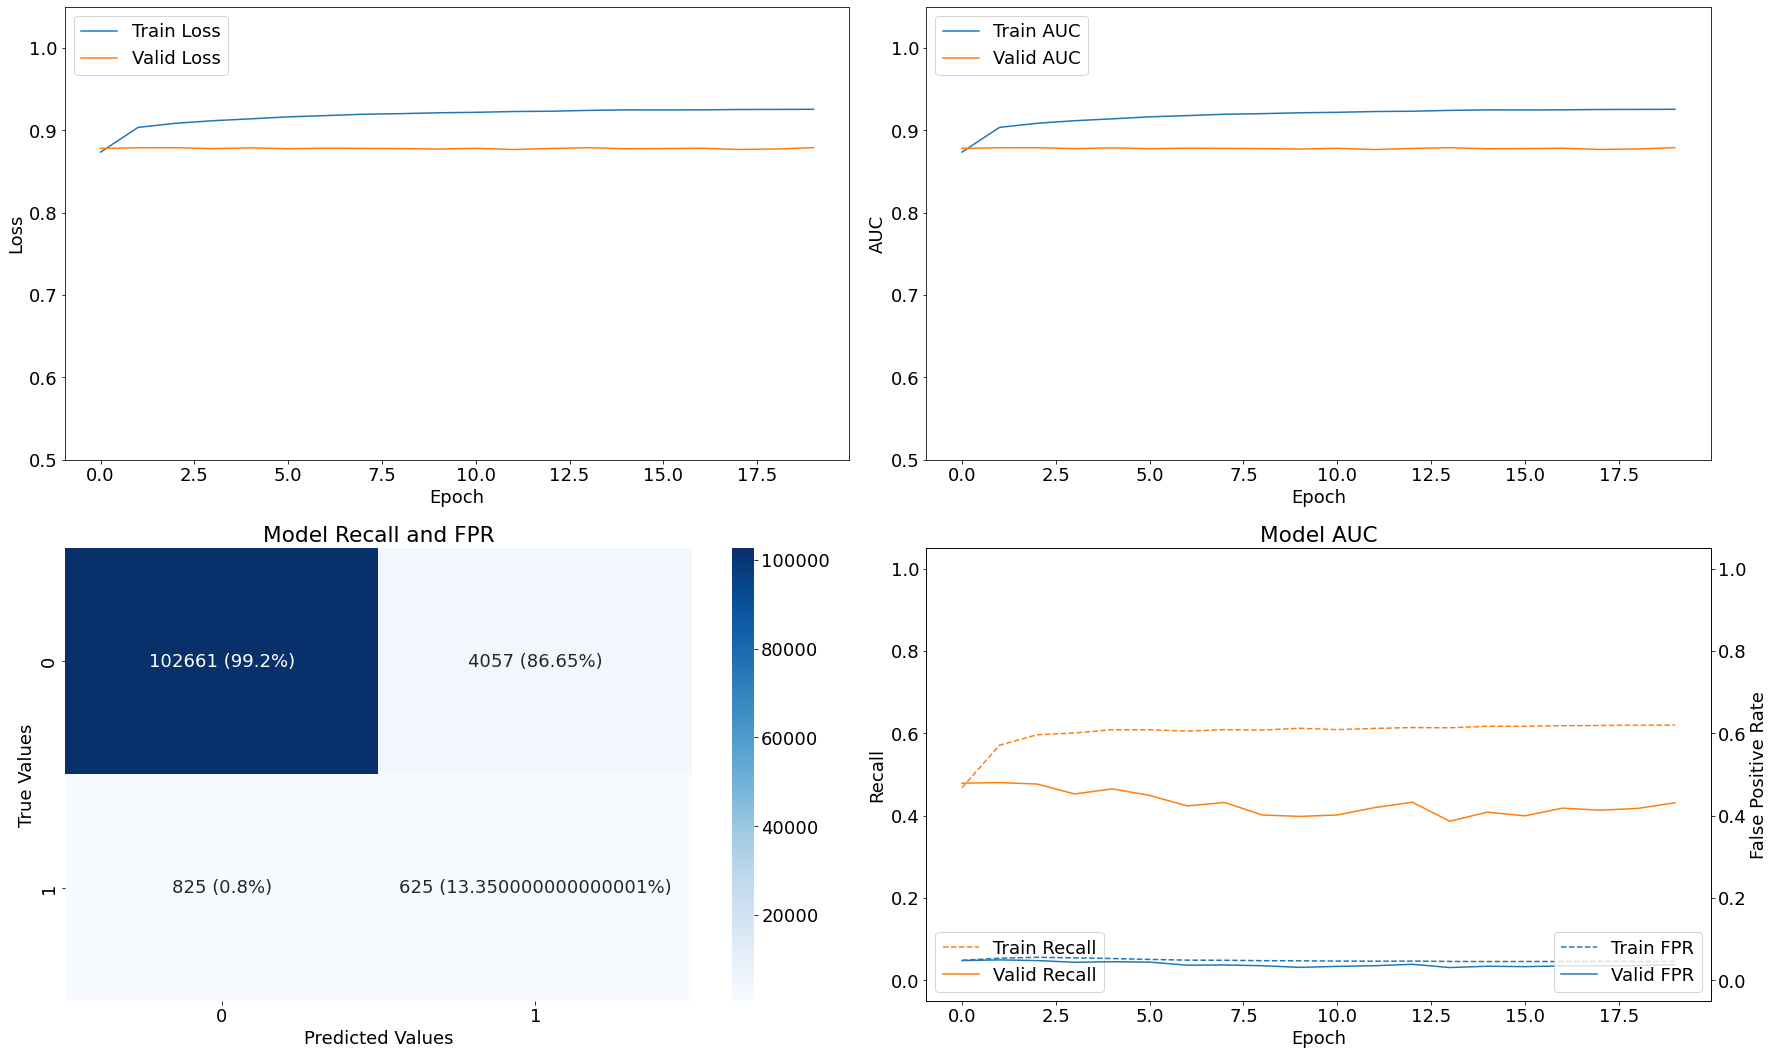

In [38]:
model_v3()

Epoch 1/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.6204 - auc: 0.8600 - recall_7: 0.7025 - false_positive_rate: 0.1588 - val_loss: 0.2909 - val_auc: 0.8773 - val_recall_7: 0.7055 - val_false_positive_rate: 0.1362
Epoch 2/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5333 - auc: 0.8992 - recall_7: 0.7793 - false_positive_rate: 0.1340 - val_loss: 0.2750 - val_auc: 0.8785 - val_recall_7: 0.6786 - val_false_positive_rate: 0.1158
Epoch 3/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5177 - auc: 0.9049 - recall_7: 0.7904 - false_positive_rate: 0.1318 - val_loss: 0.2721 - val_auc: 0.8781 - val_recall_7: 0.6586 - val_false_positive_rate: 0.1103
Epoch 4/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5113 - auc: 0.9073 - recall_7: 0.7911 - false_positive_rate: 0.1287 - val_loss: 0.2643 - val_auc: 0.8785 - val_recall_7: 0.6372 - val_false_positive_rate: 0.1025
Epoch 5/20
1921/1921 [==================


 Train recall: 0.7993736863136292 
 Val Recall: 0.634482741355896 

 Train FPR: 0.12507784366607666 
 Val FPR: 0.1026349812746048


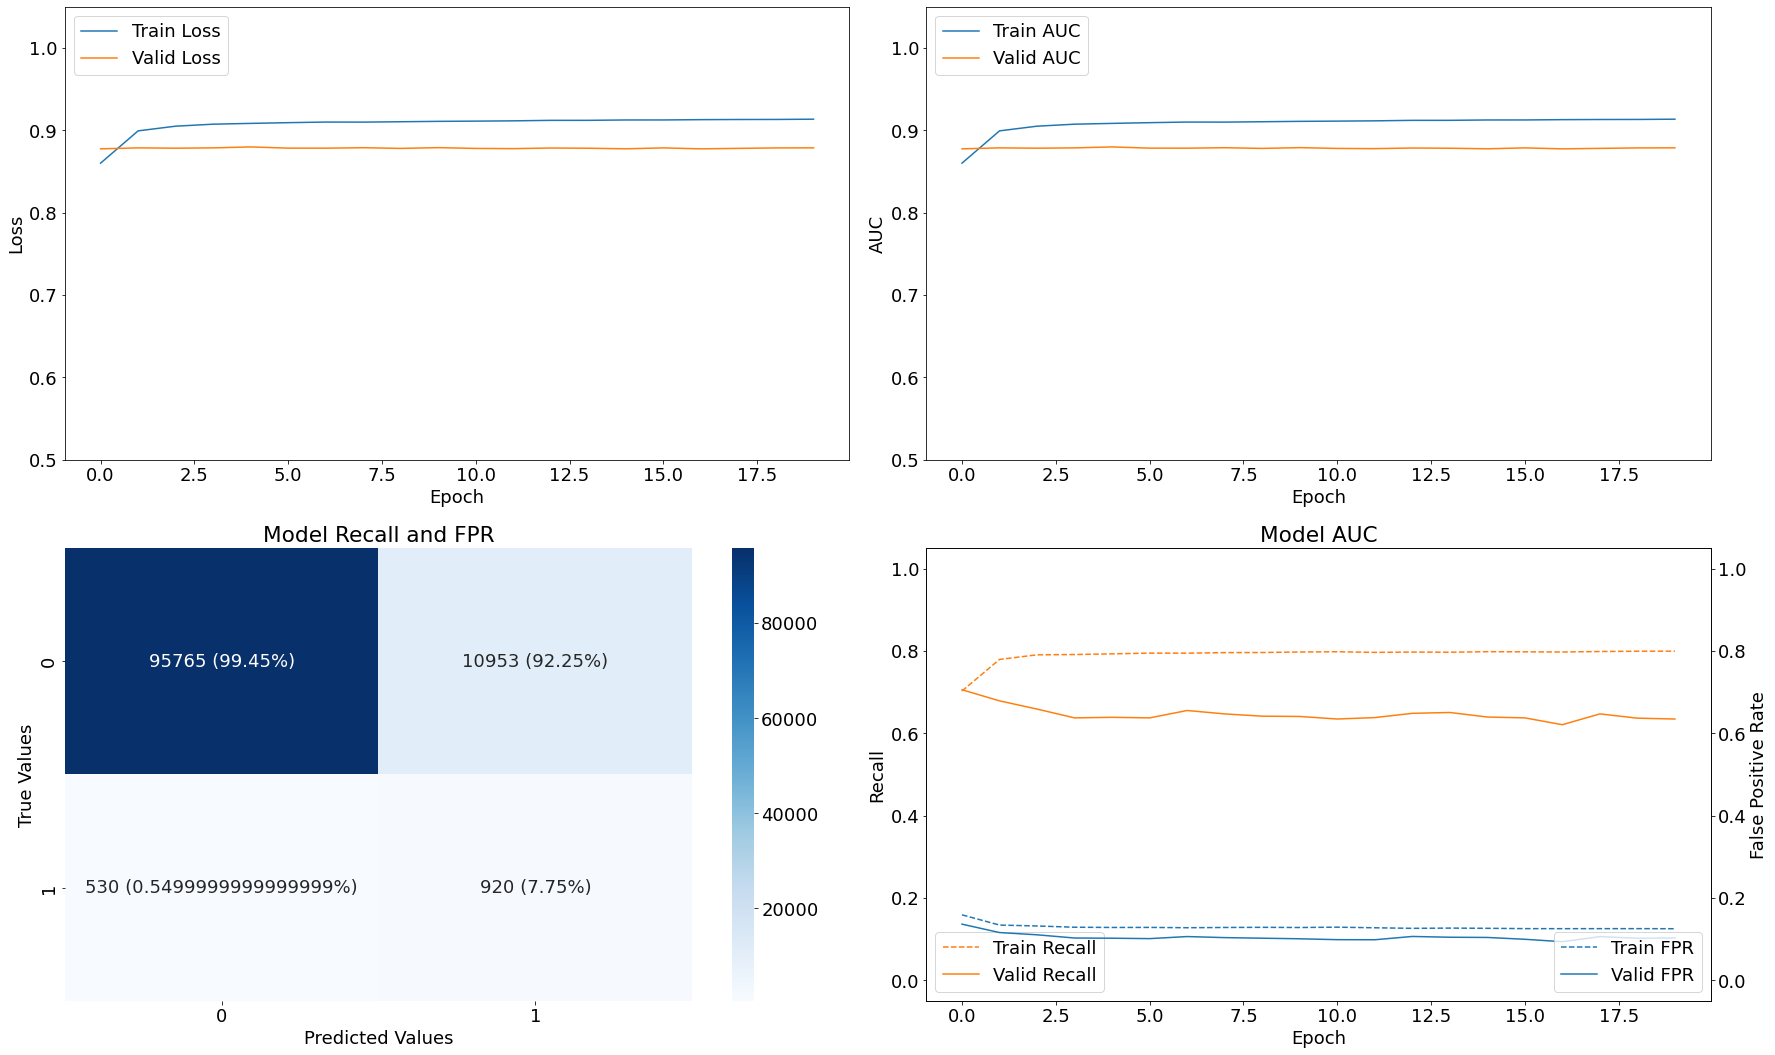

Epoch 1/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.6237 - auc: 0.8597 - recall_8: 0.6591 - false_positive_rate: 0.1279 - val_loss: 0.2787 - val_auc: 0.8756 - val_recall_8: 0.6166 - val_false_positive_rate: 0.0960
Epoch 2/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5433 - auc: 0.8952 - recall_8: 0.7105 - false_positive_rate: 0.1044 - val_loss: 0.2803 - val_auc: 0.8787 - val_recall_8: 0.6441 - val_false_positive_rate: 0.1002
Epoch 3/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5257 - auc: 0.9015 - recall_8: 0.7345 - false_positive_rate: 0.1090 - val_loss: 0.2606 - val_auc: 0.8788 - val_recall_8: 0.6124 - val_false_positive_rate: 0.0891
Epoch 4/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5206 - auc: 0.9039 - recall_8: 0.7368 - false_positive_rate: 0.1087 - val_loss: 0.2613 - val_auc: 0.8780 - val_recall_8: 0.6048 - val_false_positive_rate: 0.0884
Epoch 5/20
1921/1921 [==================


 Train recall: 0.7422029376029968 
 Val Recall: 0.5903448462486267 

 Train FPR: 0.10543593764305115 
 Val FPR: 0.08332239836454391


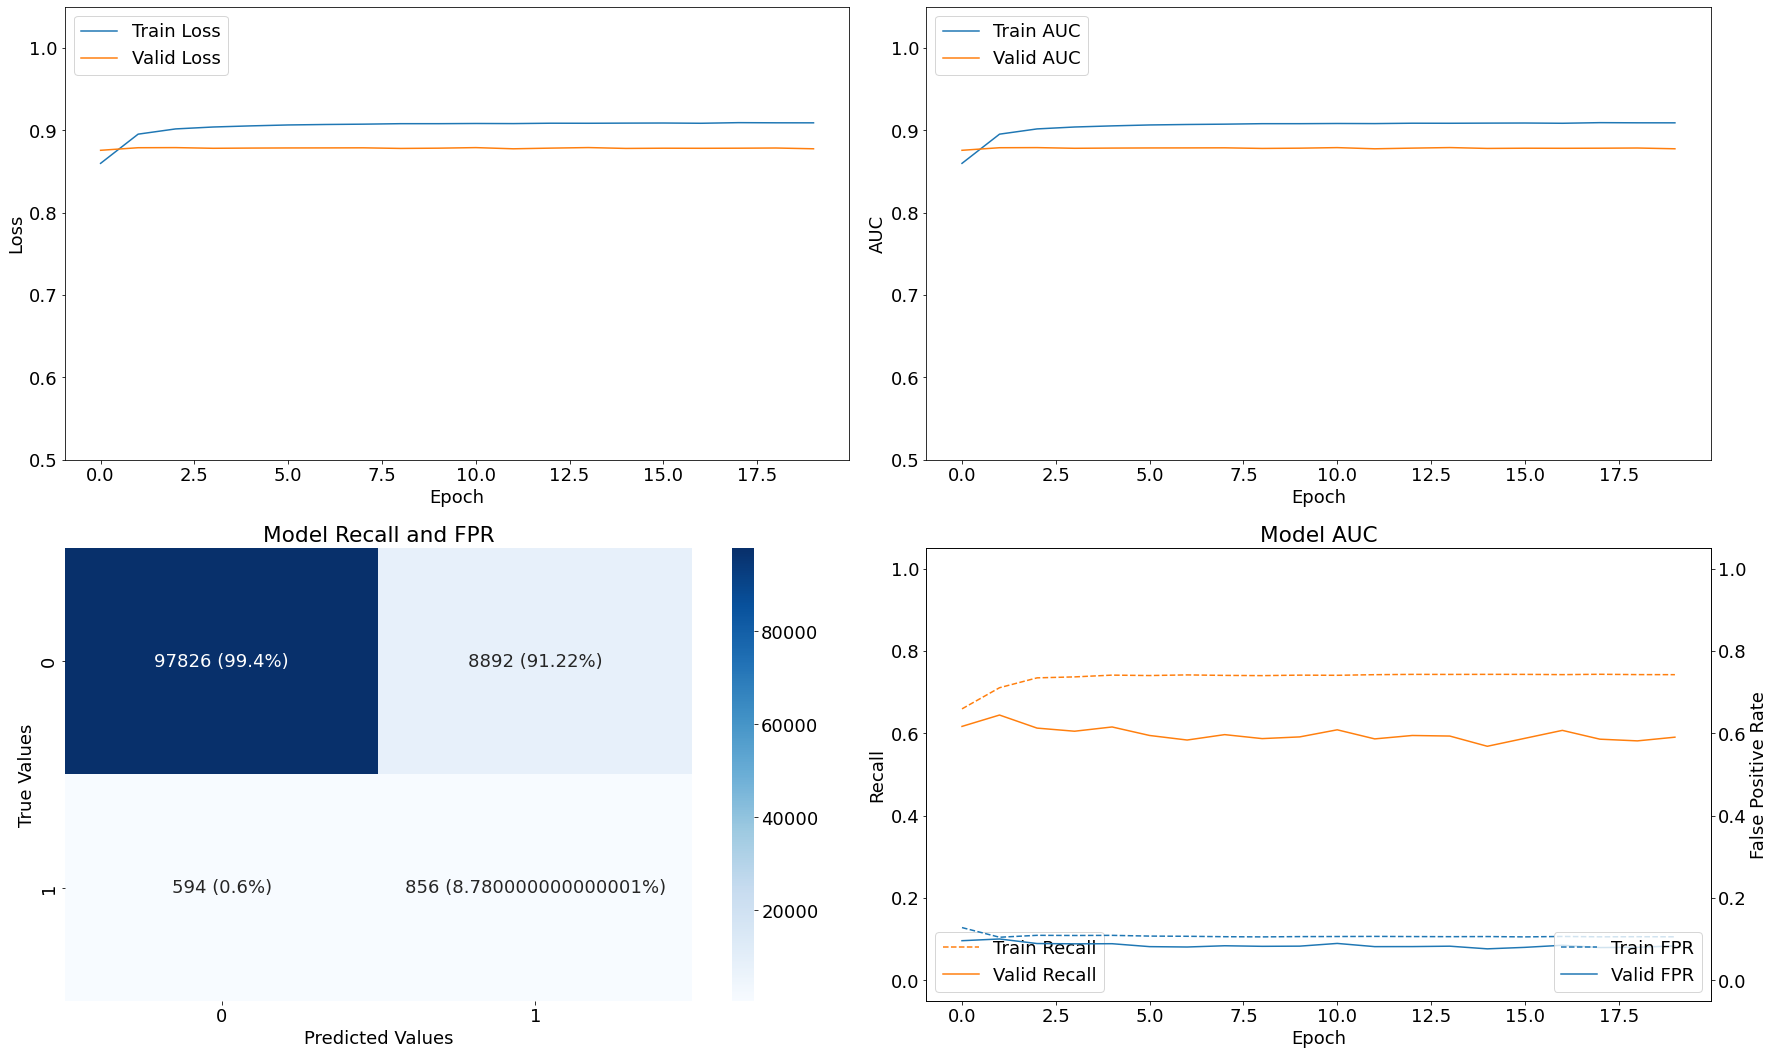

Epoch 1/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.6071 - auc: 0.8664 - recall_9: 0.5856 - false_positive_rate: 0.0953 - val_loss: 0.2723 - val_auc: 0.8768 - val_recall_9: 0.6131 - val_false_positive_rate: 0.0893
Epoch 2/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5307 - auc: 0.9001 - recall_9: 0.6889 - false_positive_rate: 0.0913 - val_loss: 0.2536 - val_auc: 0.8784 - val_recall_9: 0.5793 - val_false_positive_rate: 0.0792
Epoch 3/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5151 - auc: 0.9058 - recall_9: 0.7076 - false_positive_rate: 0.0907 - val_loss: 0.2553 - val_auc: 0.8785 - val_recall_9: 0.5579 - val_false_positive_rate: 0.0743
Epoch 4/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5078 - auc: 0.9086 - recall_9: 0.7107 - false_positive_rate: 0.0891 - val_loss: 0.2498 - val_auc: 0.8783 - val_recall_9: 0.5421 - val_false_positive_rate: 0.0685
Epoch 5/20
1921/1921 [==================


 Train recall: 0.7224377393722534 
 Val Recall: 0.5537931323051453 

 Train FPR: 0.08719583600759506 
 Val FPR: 0.06975392997264862


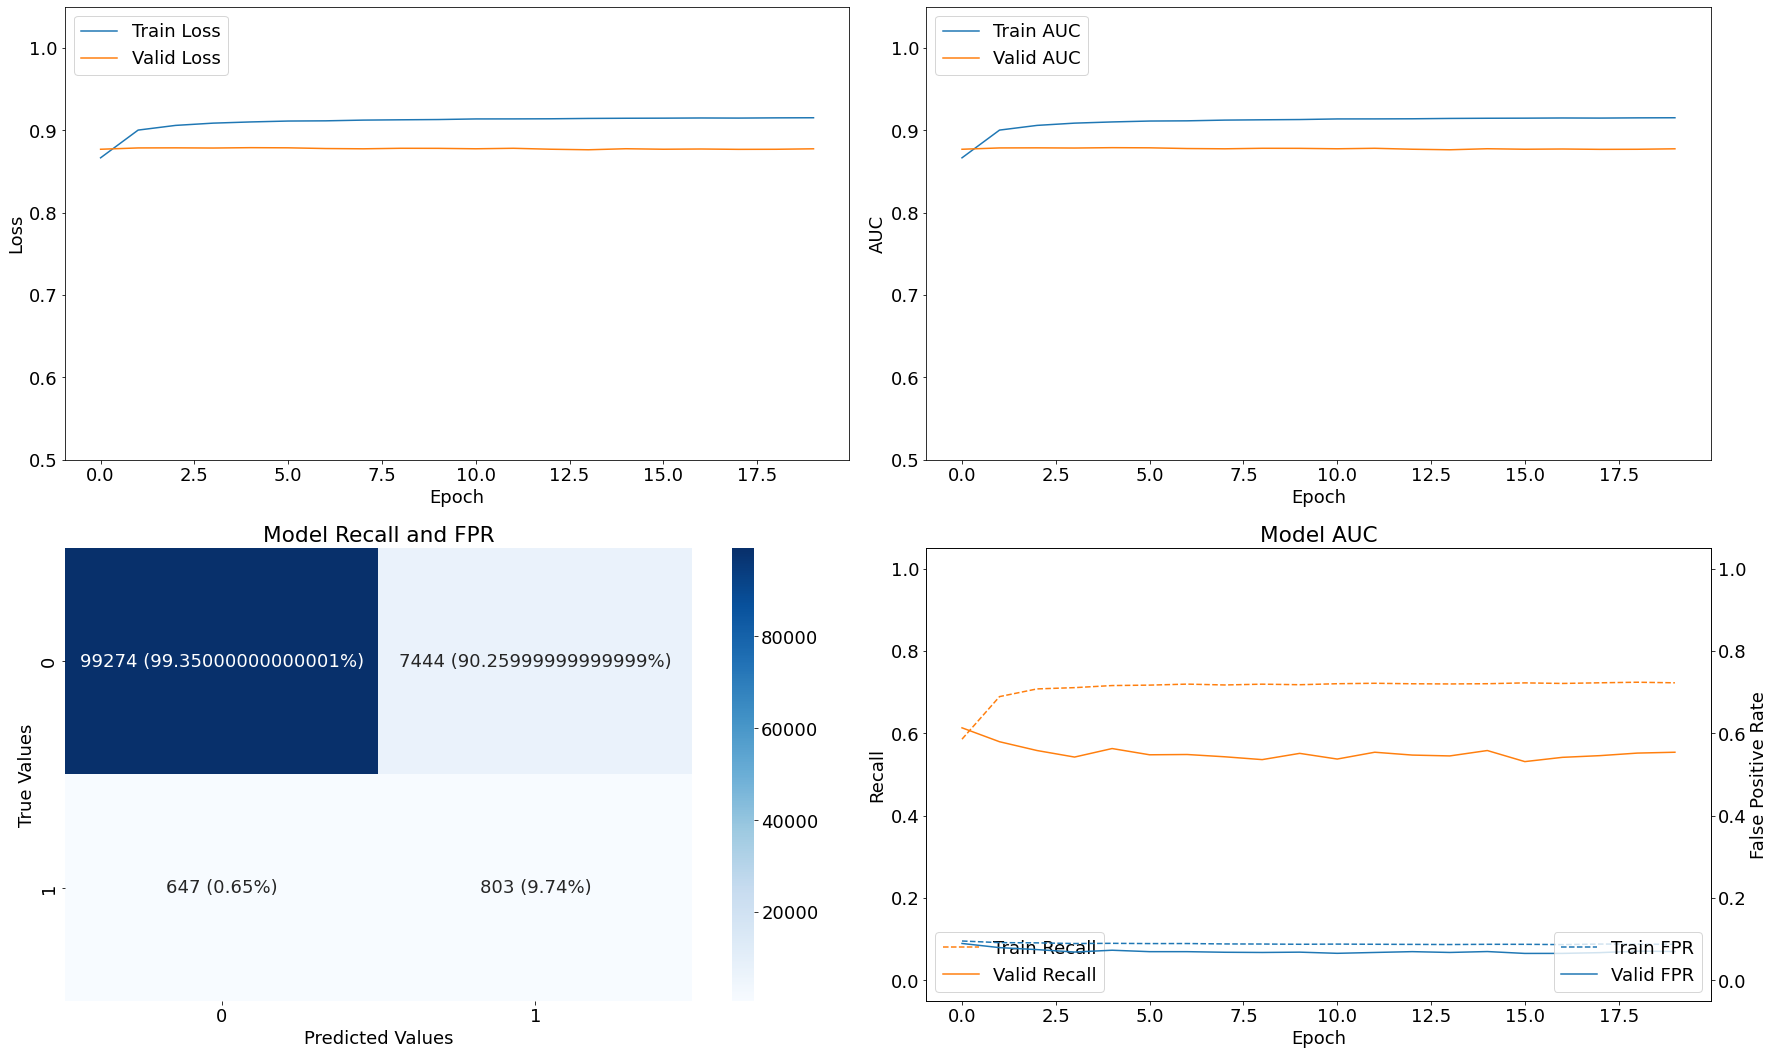

Epoch 1/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.6161 - auc: 0.8623 - recall_10: 0.5212 - false_positive_rate: 0.0781 - val_loss: 0.2930 - val_auc: 0.8765 - val_recall_10: 0.5586 - val_false_positive_rate: 0.0738
Epoch 2/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5341 - auc: 0.8990 - recall_10: 0.6097 - false_positive_rate: 0.0707 - val_loss: 0.2811 - val_auc: 0.8786 - val_recall_10: 0.5655 - val_false_positive_rate: 0.0759
Epoch 3/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5182 - auc: 0.9048 - recall_10: 0.6422 - false_positive_rate: 0.0744 - val_loss: 0.2594 - val_auc: 0.8790 - val_recall_10: 0.5379 - val_false_positive_rate: 0.0677
Epoch 4/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5131 - auc: 0.9067 - recall_10: 0.6507 - false_positive_rate: 0.0749 - val_loss: 0.2643 - val_auc: 0.8785 - val_recall_10: 0.5434 - val_false_positive_rate: 0.0688
Epoch 5/20
1921/1921 [==========


 Train recall: 0.6566755771636963 
 Val Recall: 0.5131034255027771 

 Train FPR: 0.0740215927362442 
 Val FPR: 0.06073014810681343


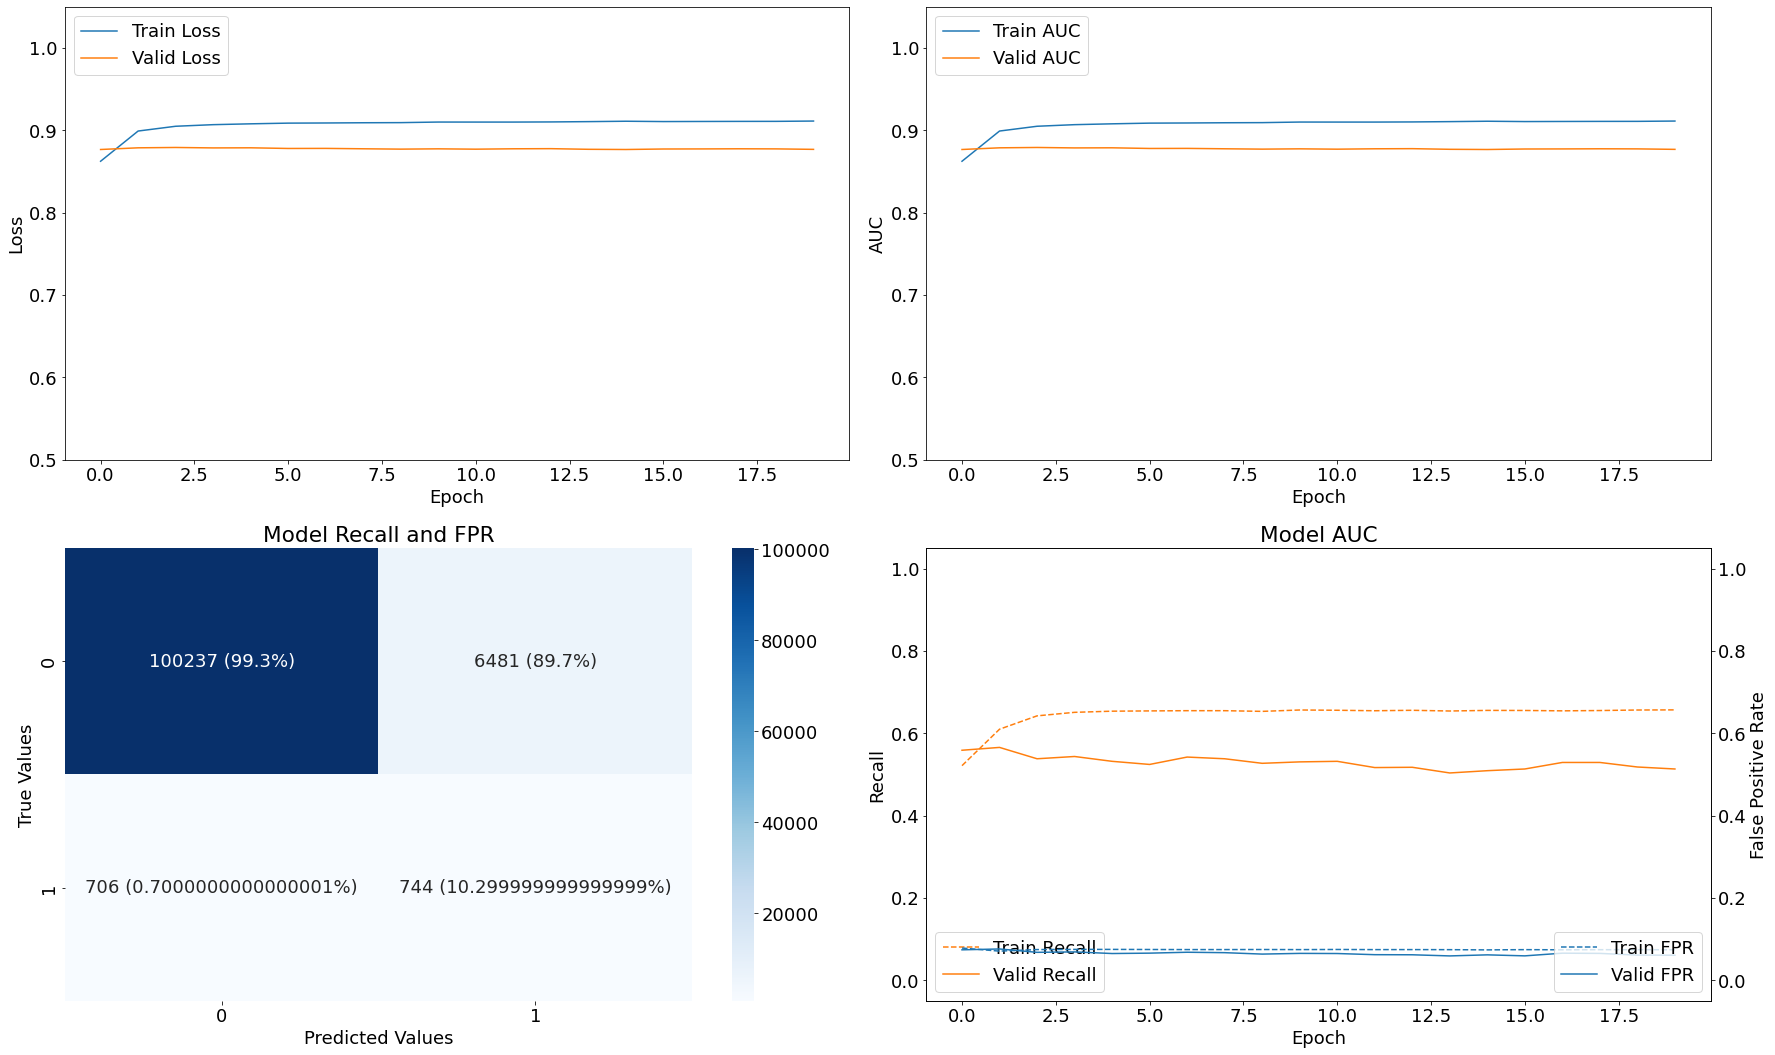

Epoch 1/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.6023 - auc: 0.8684 - recall_11: 0.4614 - false_positive_rate: 0.0582 - val_loss: 0.2836 - val_auc: 0.8756 - val_recall_11: 0.5276 - val_false_positive_rate: 0.0604
Epoch 2/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5298 - auc: 0.9003 - recall_11: 0.5655 - false_positive_rate: 0.0583 - val_loss: 0.2632 - val_auc: 0.8782 - val_recall_11: 0.5097 - val_false_positive_rate: 0.0567
Epoch 3/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5137 - auc: 0.9062 - recall_11: 0.5989 - false_positive_rate: 0.0624 - val_loss: 0.2668 - val_auc: 0.8794 - val_recall_11: 0.5021 - val_false_positive_rate: 0.0569
Epoch 4/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5086 - auc: 0.9082 - recall_11: 0.6075 - false_positive_rate: 0.0633 - val_loss: 0.2605 - val_auc: 0.8789 - val_recall_11: 0.5193 - val_false_positive_rate: 0.0564
Epoch 5/20
1921/1921 [==========


 Train recall: 0.6168248653411865 
 Val Recall: 0.4820689558982849 

 Train FPR: 0.06259738653898239 
 Val FPR: 0.051650144159793854


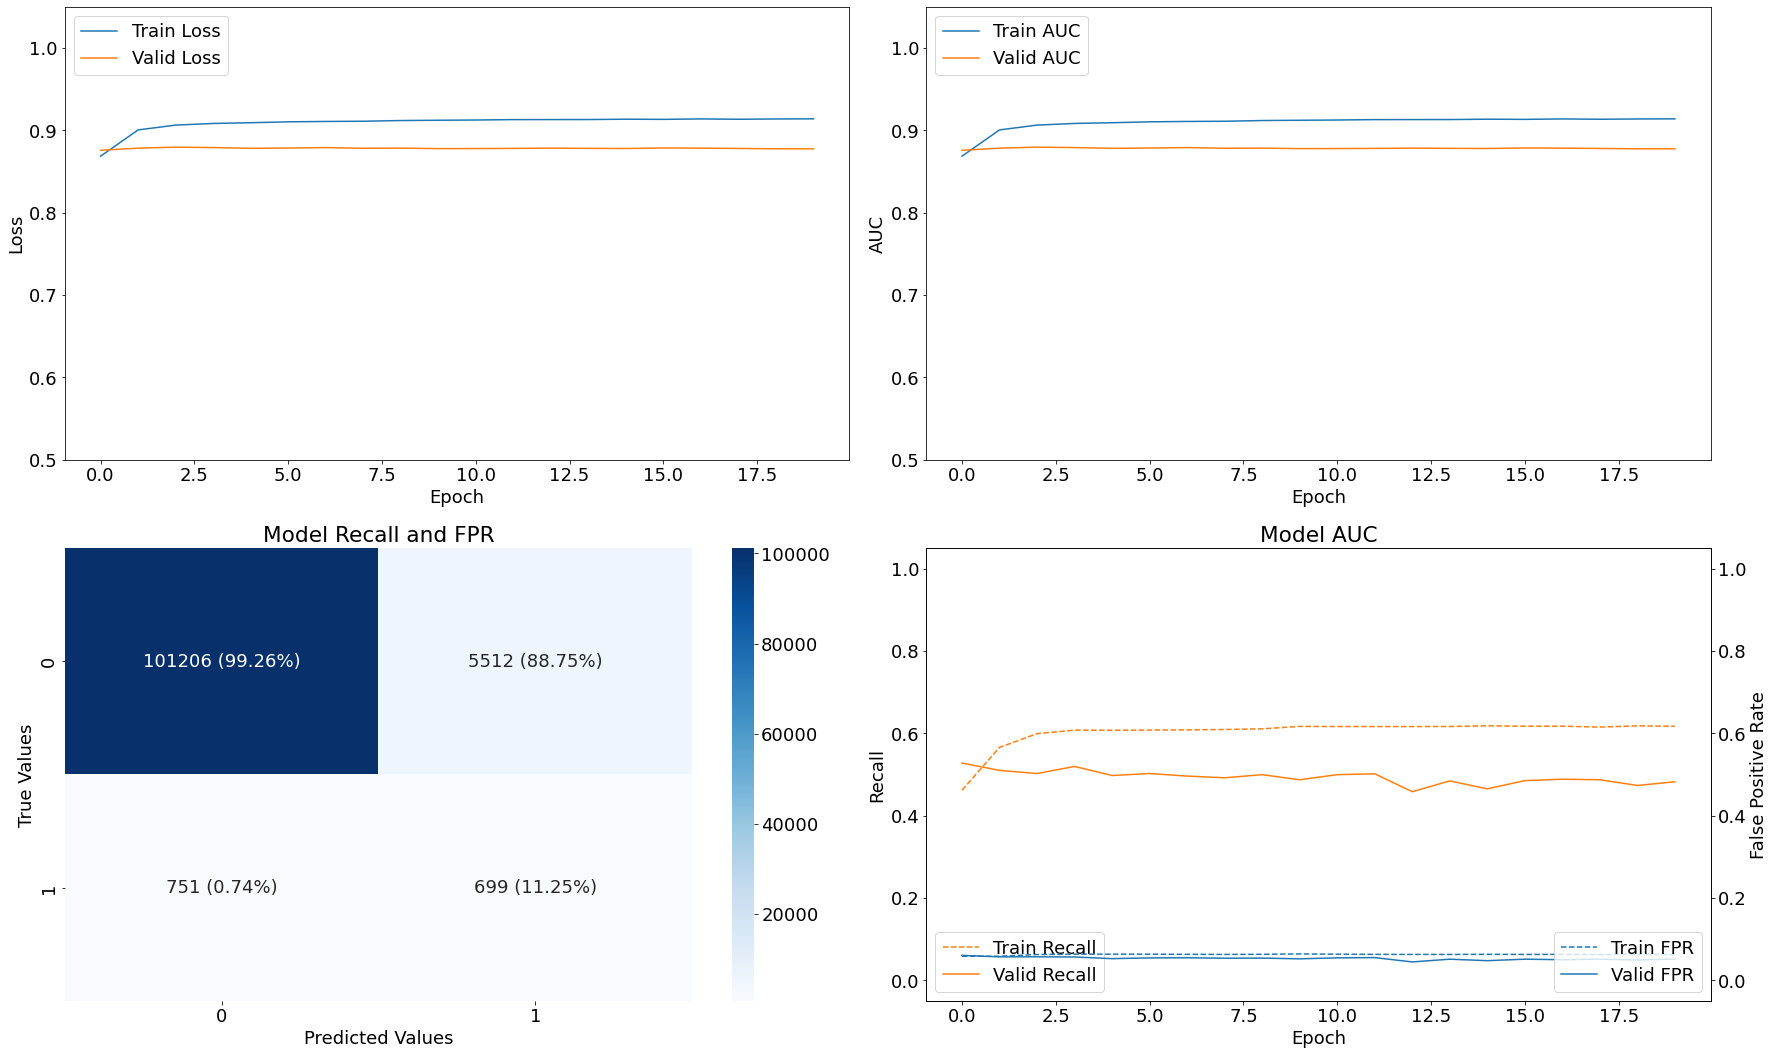

Epoch 1/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.6165 - auc: 0.8621 - recall_12: 0.3753 - false_positive_rate: 0.0426 - val_loss: 0.2750 - val_auc: 0.8767 - val_recall_12: 0.4379 - val_false_positive_rate: 0.0372
Epoch 2/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5361 - auc: 0.8979 - recall_12: 0.4727 - false_positive_rate: 0.0435 - val_loss: 0.2721 - val_auc: 0.8790 - val_recall_12: 0.4662 - val_false_positive_rate: 0.0444
Epoch 3/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5197 - auc: 0.9041 - recall_12: 0.5042 - false_positive_rate: 0.0457 - val_loss: 0.2630 - val_auc: 0.8795 - val_recall_12: 0.4669 - val_false_positive_rate: 0.0450
Epoch 4/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5137 - auc: 0.9065 - recall_12: 0.5169 - false_positive_rate: 0.0468 - val_loss: 0.2487 - val_auc: 0.8792 - val_recall_12: 0.4531 - val_false_positive_rate: 0.0419
Epoch 5/20
1921/1921 [==========


 Train recall: 0.5462484955787659 
 Val Recall: 0.4227586090564728 

 Train FPR: 0.0479704849421978 
 Val FPR: 0.037125881761312485


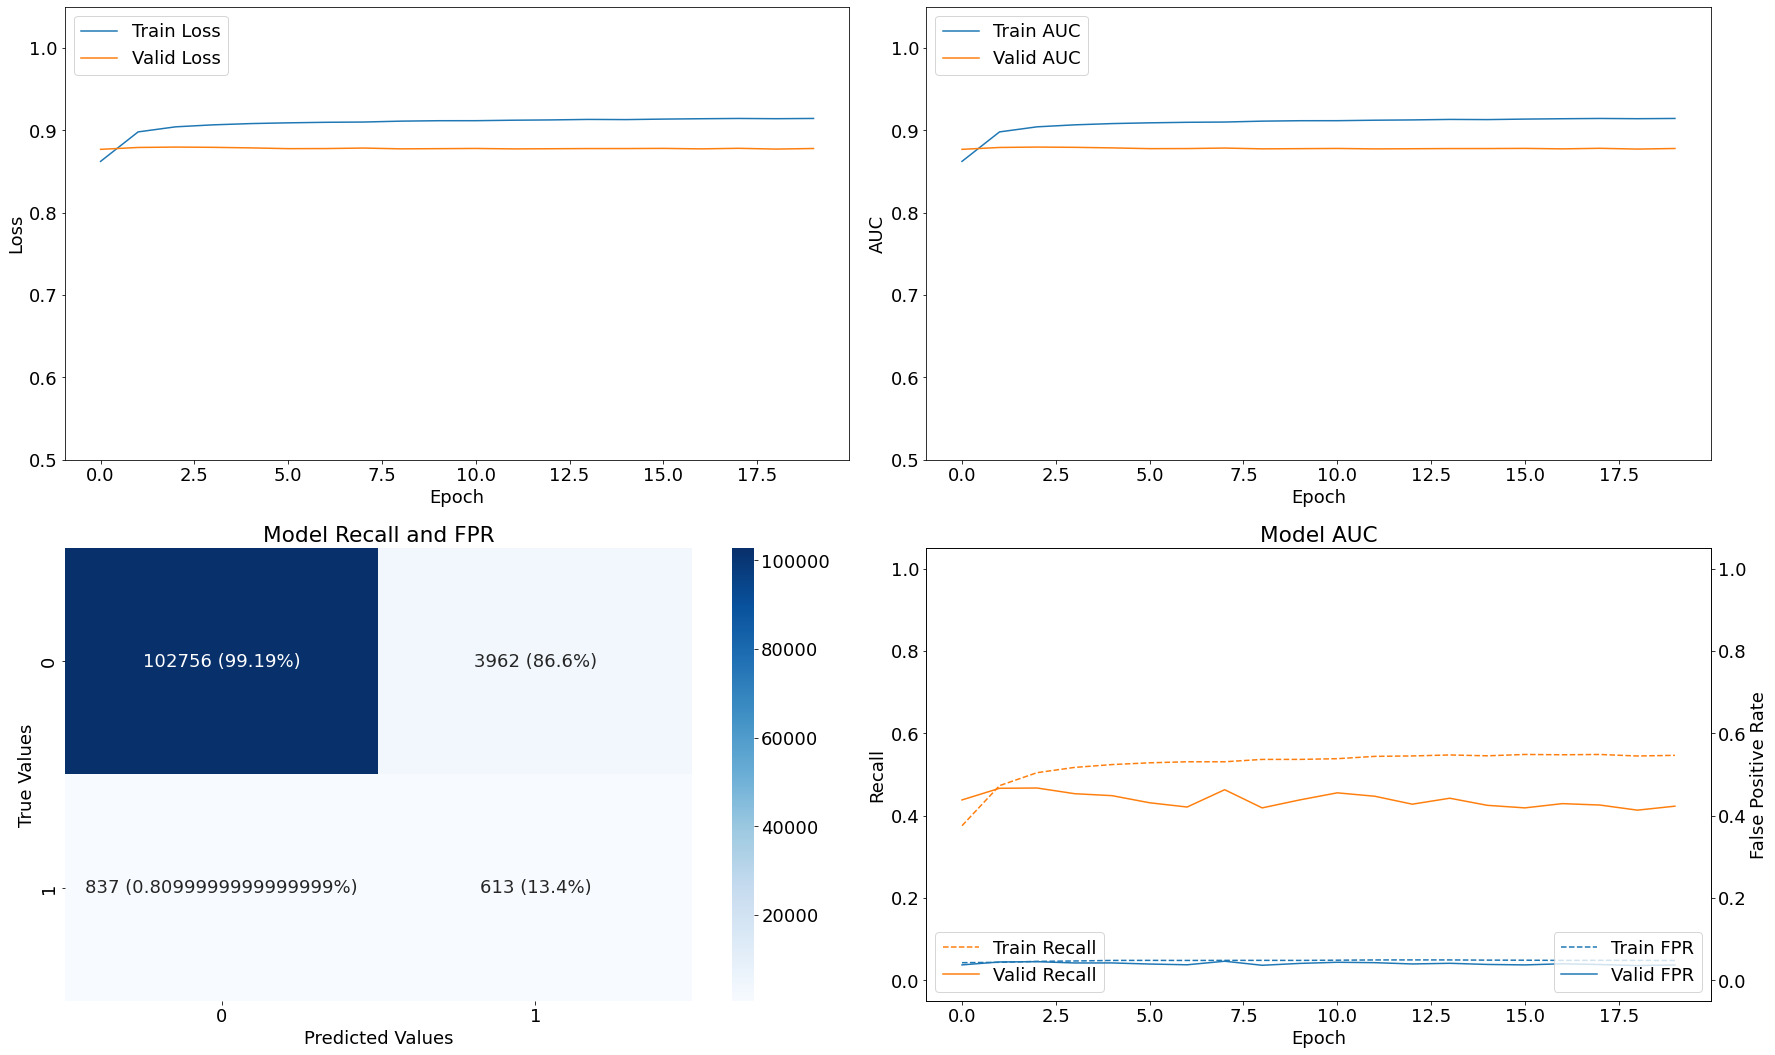

Epoch 1/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.6062 - auc: 0.8668 - recall_13: 0.3159 - false_positive_rate: 0.0312 - val_loss: 0.2875 - val_auc: 0.8748 - val_recall_13: 0.3869 - val_false_positive_rate: 0.0289
Epoch 2/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5303 - auc: 0.9002 - recall_13: 0.4001 - false_positive_rate: 0.0312 - val_loss: 0.2737 - val_auc: 0.8780 - val_recall_13: 0.4159 - val_false_positive_rate: 0.0347
Epoch 3/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5145 - auc: 0.9059 - recall_13: 0.4270 - false_positive_rate: 0.0330 - val_loss: 0.2616 - val_auc: 0.8783 - val_recall_13: 0.4069 - val_false_positive_rate: 0.0342
Epoch 4/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.5093 - auc: 0.9080 - recall_13: 0.4360 - false_positive_rate: 0.0335 - val_loss: 0.2575 - val_auc: 0.8785 - val_recall_13: 0.3952 - val_false_positive_rate: 0.0311
Epoch 5/20
1921/1921 [==========


 Train recall: 0.45797091722488403 
 Val Recall: 0.37655171751976013 

 Train FPR: 0.034140445291996 
 Val FPR: 0.027999024838209152


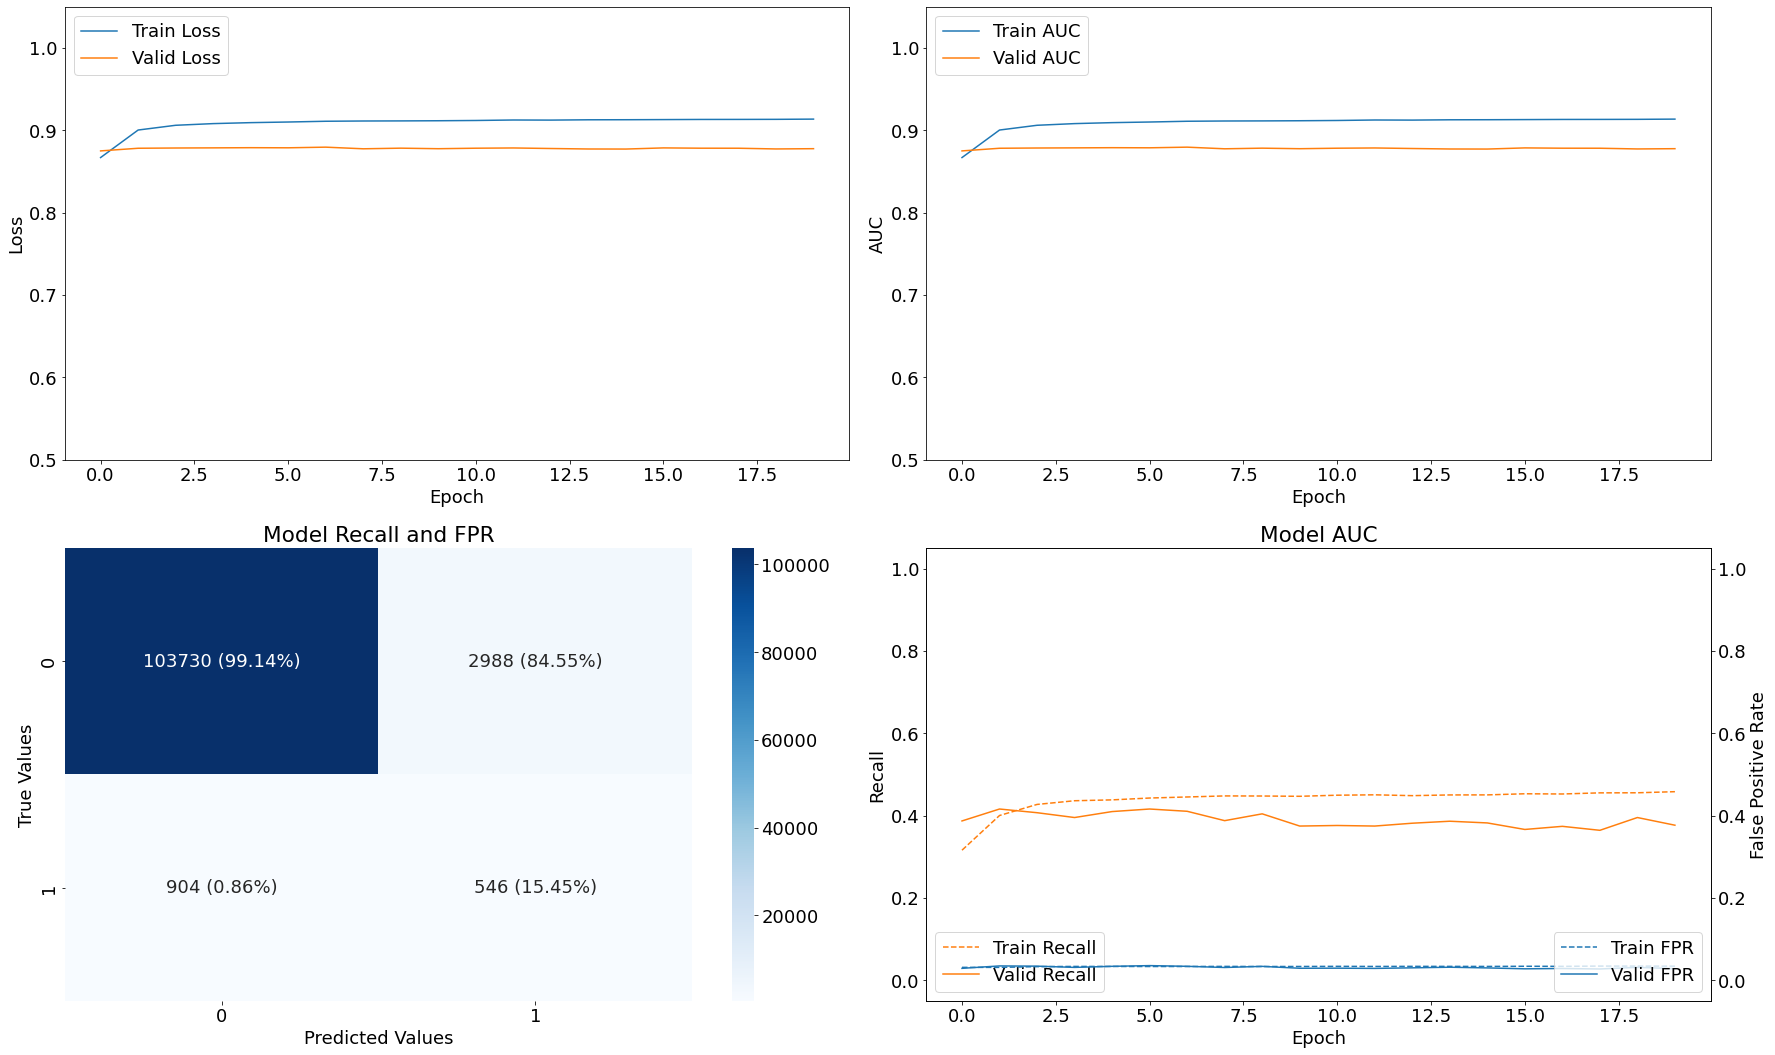

In [39]:
for t in thresholds:
    model_v3(threshold=t)

In [39]:
def model_v4(epochs=20, batch_size=512, threshold=0.5):   

    b_model_v4 = models.Sequential()

    b_model_v4.add(layers.Input(shape=(n_features, )))
    b_model_v4.add(layers.Dense(32, activation='relu'))
    b_model_v4.add(layers.Dropout(0.5))
    b_model_v4.add(layers.Dense(16, activation='relu'))
    b_model_v4.add(layers.Dropout(0.5))
    b_model_v4.add(layers.Dense(8, activation='relu'))
    b_model_v4.add(layers.Dropout(0.5))
    b_model_v4.add(layers.Dense(4, activation='relu'))
    b_model_v4.add(layers.Dense(2, activation='relu'))
    b_model_v4.add(layers.Dense(1, activation='sigmoid'))

    b_model_v4.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_model_v4_history = b_model_v4.fit(X_train_base_scaled_resampled,
                                        y_train_base_resampled,
                                        batch_size=batch_size,
                                        validation_data=(X_val_base_scaled, y_val_base),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=0).history
    
    evaluate(b_model_v4, b_model_v4_history, X_val_base_scaled, y_val_base, threshold=threshold)

Results for model with threshold = 0.5.

 Train recall: 0.7039840817451477 
 Val Recall: 0.4868965446949005 

 Train FPR: 0.07102351635694504 
 Val FPR: 0.05111602693796158


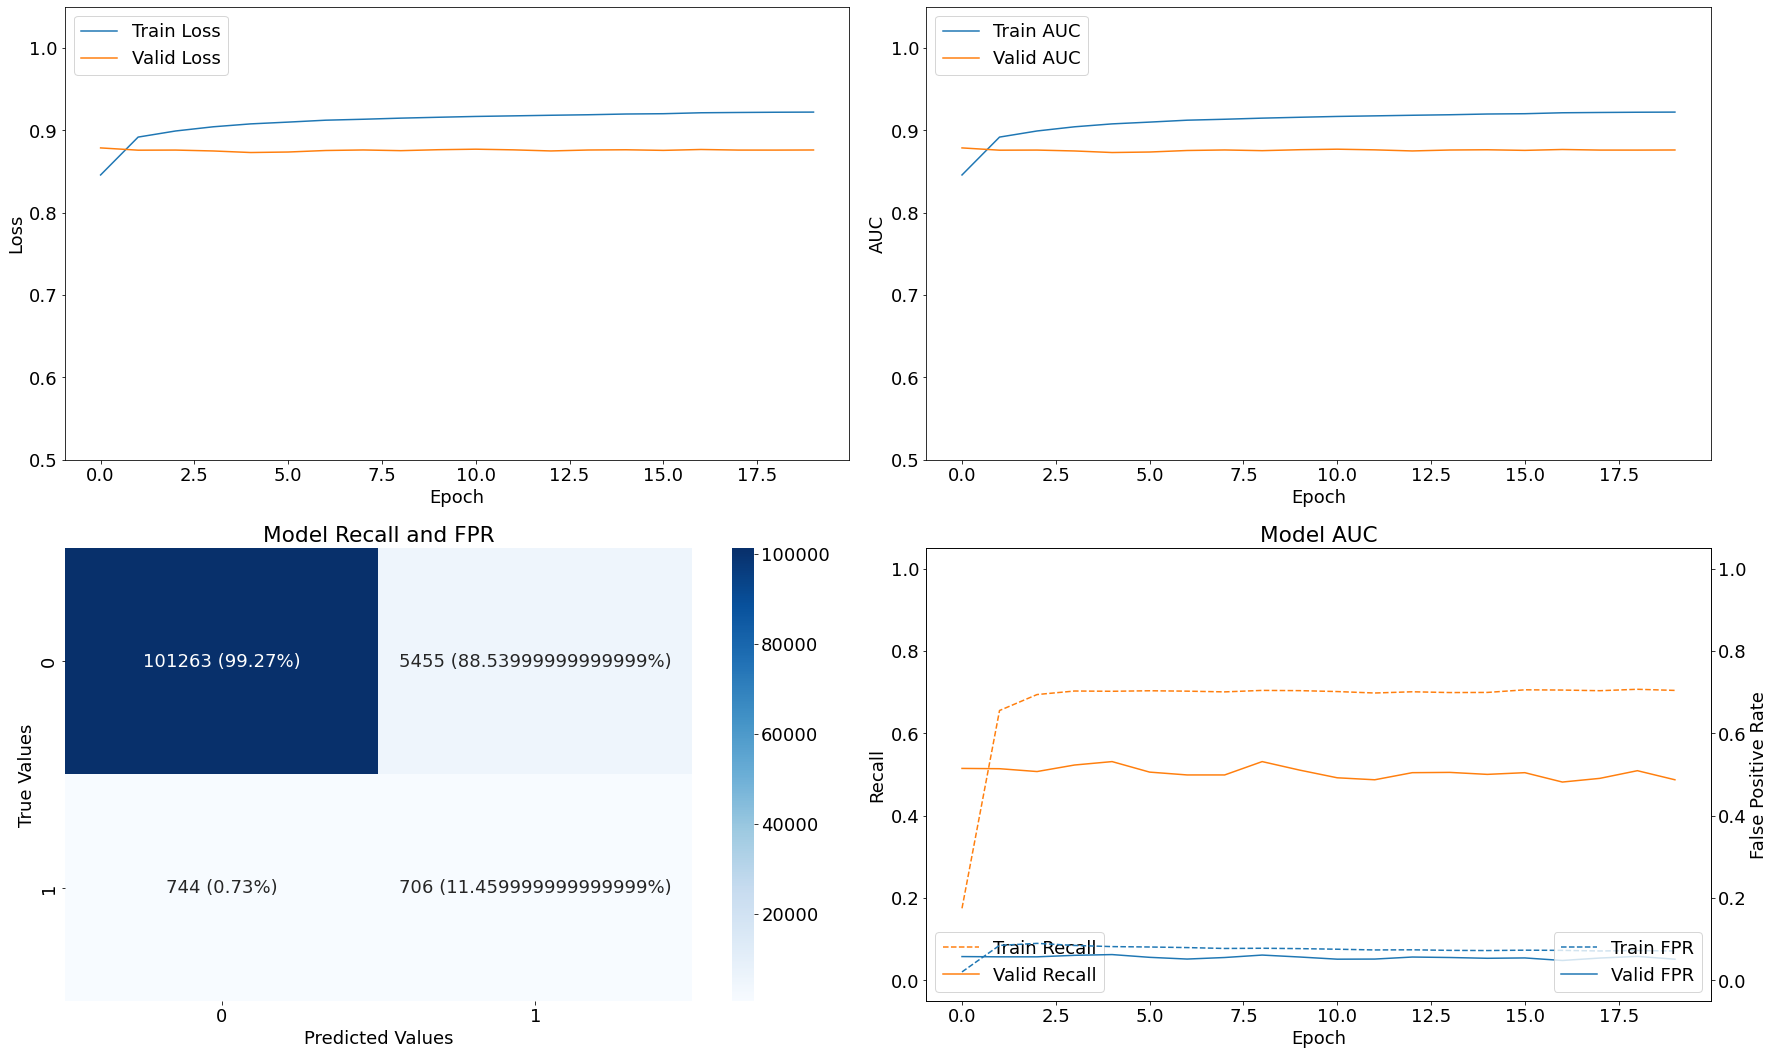

In [40]:
model_v4()

Results for model with threshold = 0.5.

 Train recall: 0.7999684810638428 
 Val Recall: 0.7365517020225525 

 Train FPR: 0.14856043457984924 
 Val FPR: 0.1469855159521103


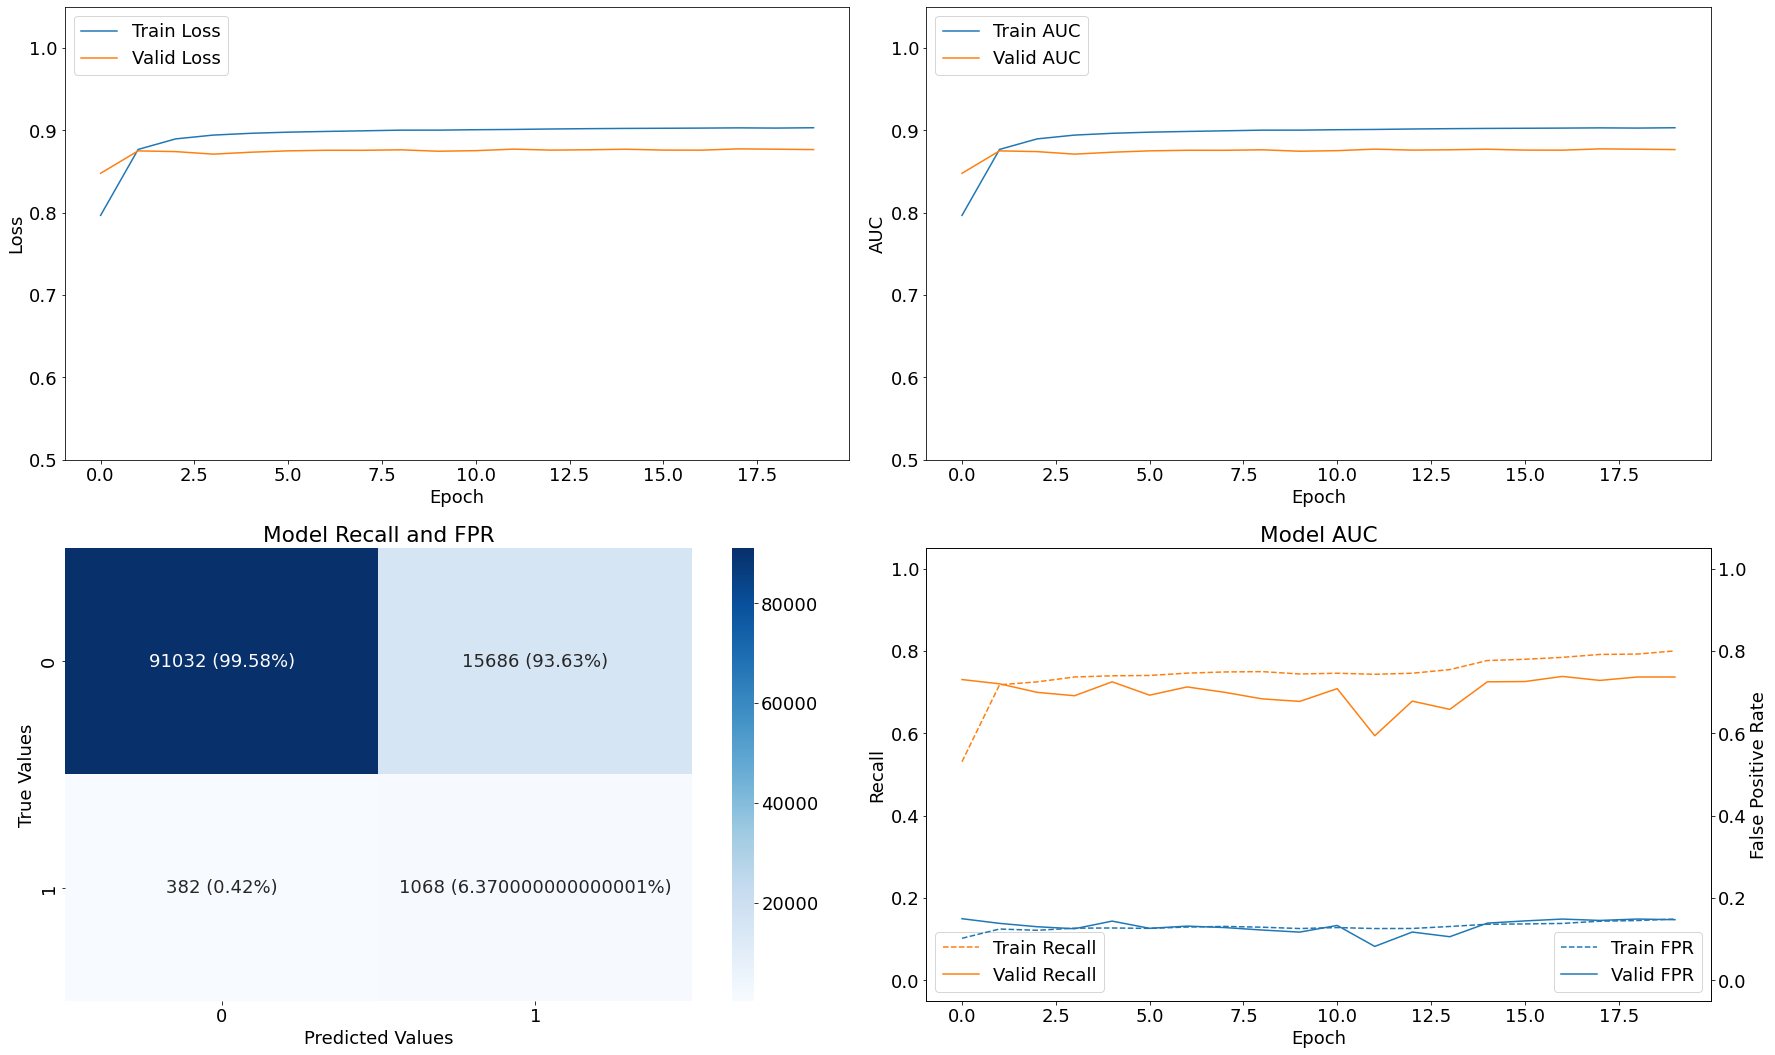

Results for model with threshold = 0.55.

 Train recall: 0.7855919003486633 
 Val Recall: 0.7351723909378052 

 Train FPR: 0.13993985950946808 
 Val FPR: 0.14896269142627716


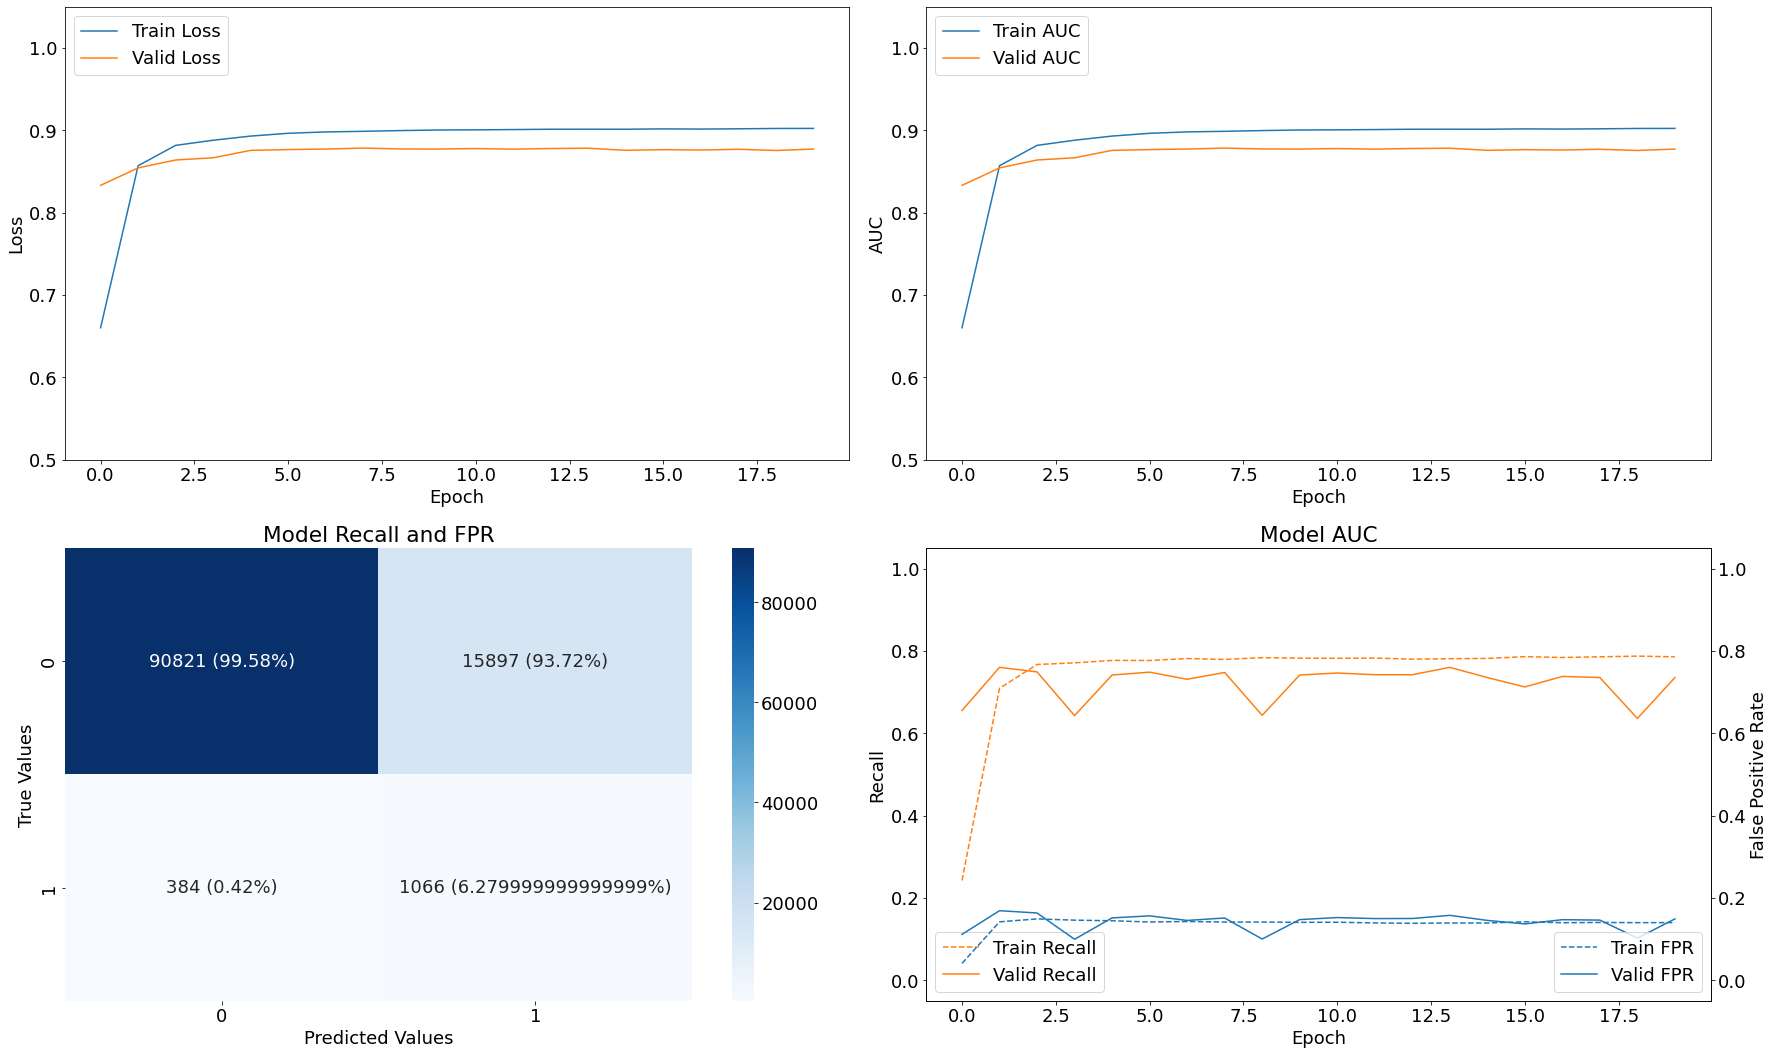

Results for model with threshold = 0.6.

 Train recall: 0.8112084269523621 
 Val Recall: 0.6462069153785706 

 Train FPR: 0.14303579926490784 
 Val FPR: 0.1056147962808609


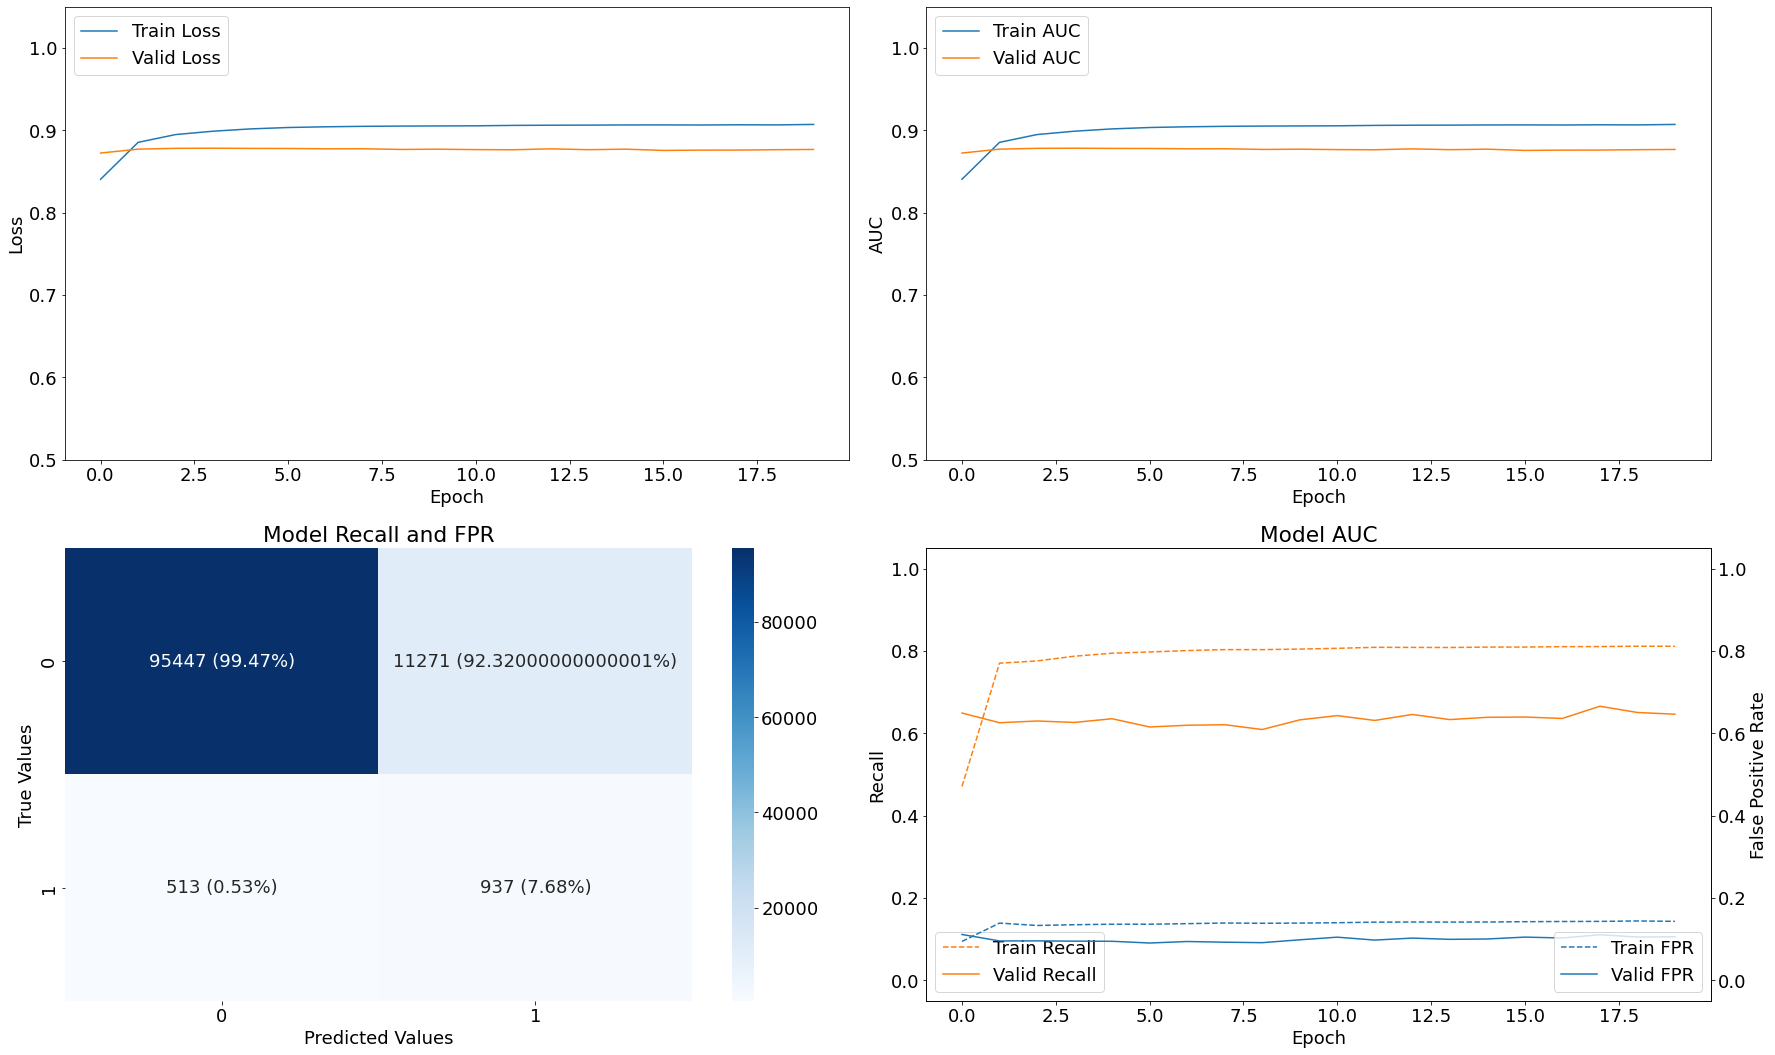

Results for model with threshold = 0.65.

 Train recall: 0.74125736951828 
 Val Recall: 0.6000000238418579 

 Train FPR: 0.1029513031244278 
 Val FPR: 0.08788582682609558


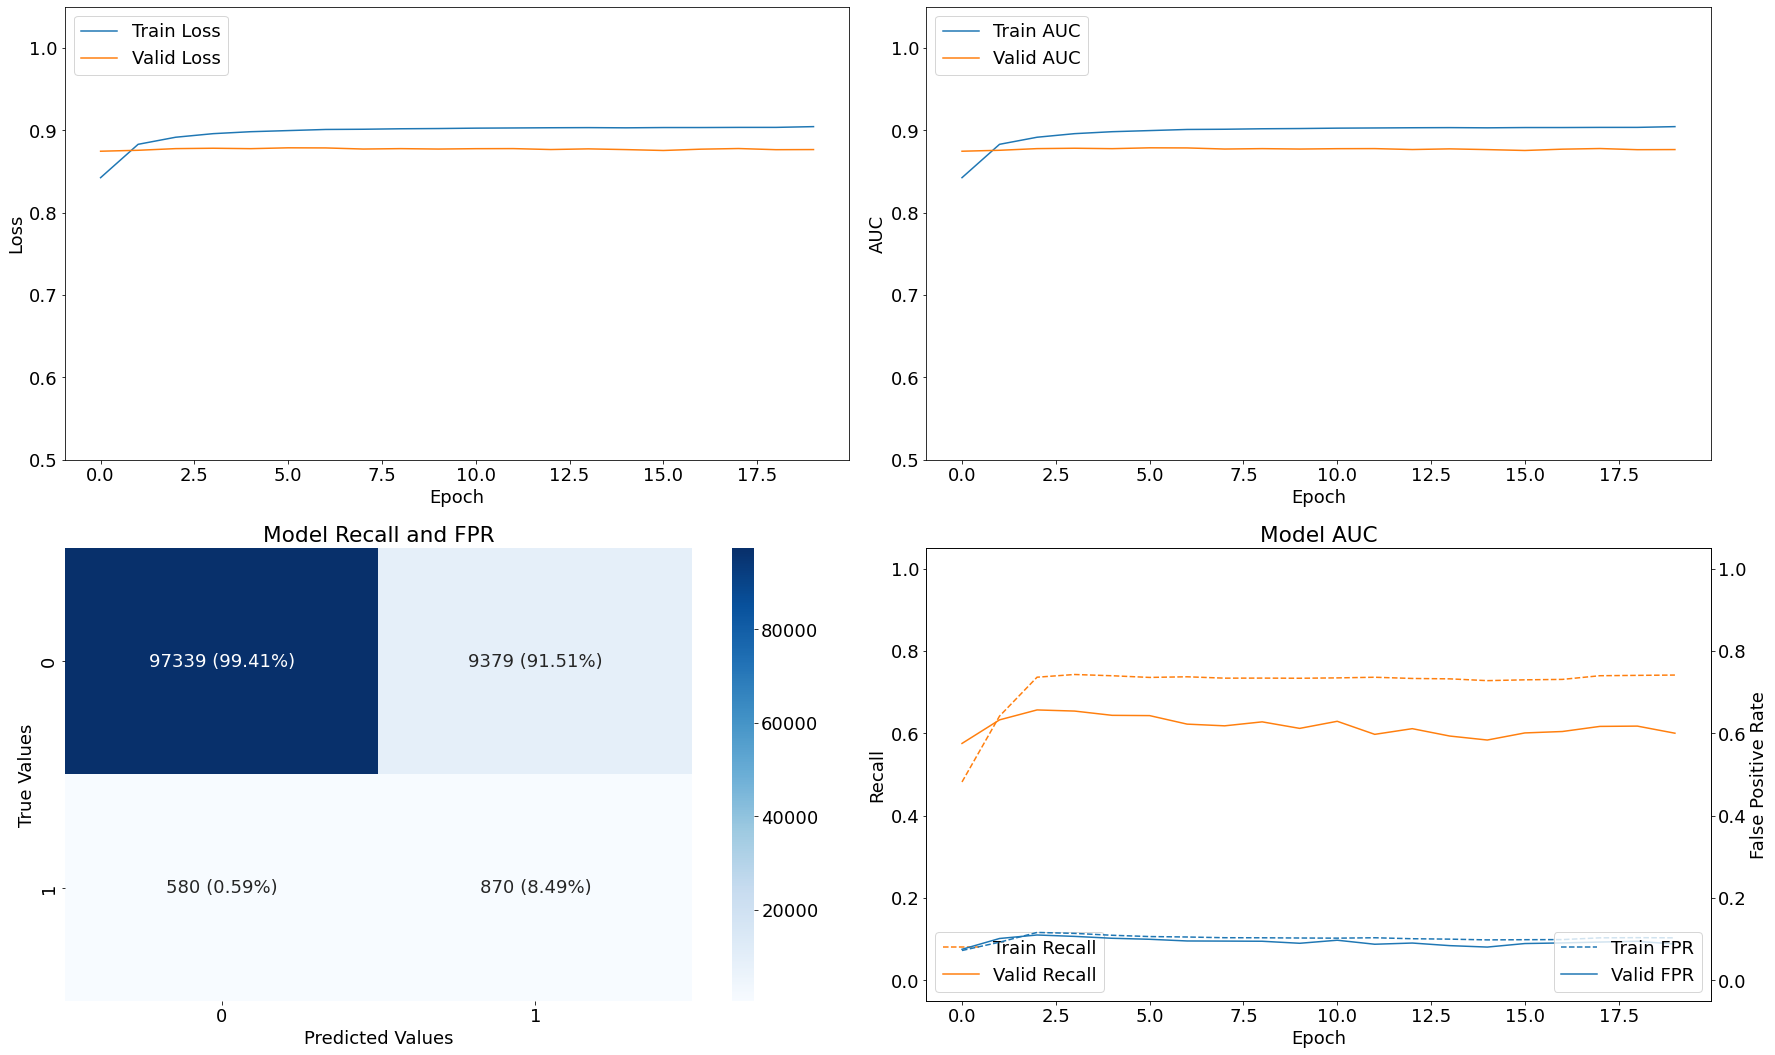

Results for model with threshold = 0.7.

 Train recall: 0.6177754998207092 
 Val Recall: 0.5324137806892395 

 Train FPR: 0.0633726418018341 
 Val FPR: 0.06268858164548874


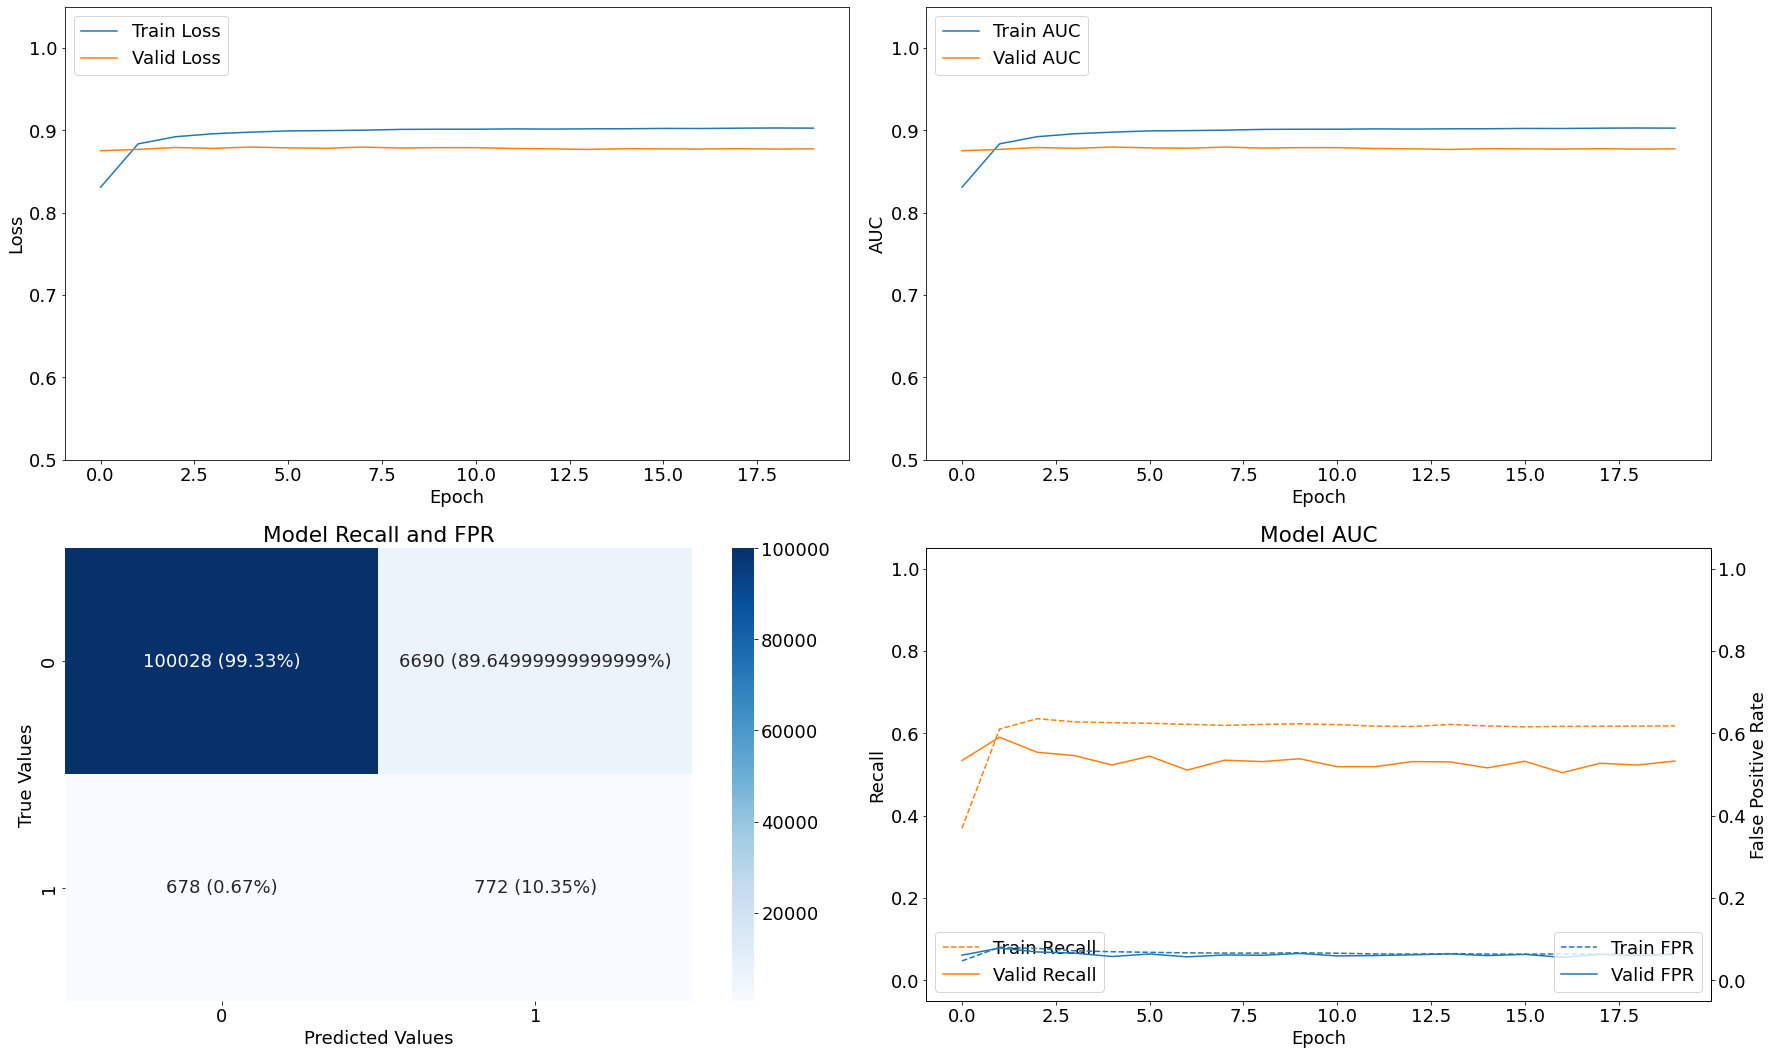

Results for model with threshold = 0.75.

 Train recall: 0.48437032103538513 
 Val Recall: 0.3820689618587494 

 Train FPR: 0.03827725723385811 
 Val FPR: 0.028786147013306618


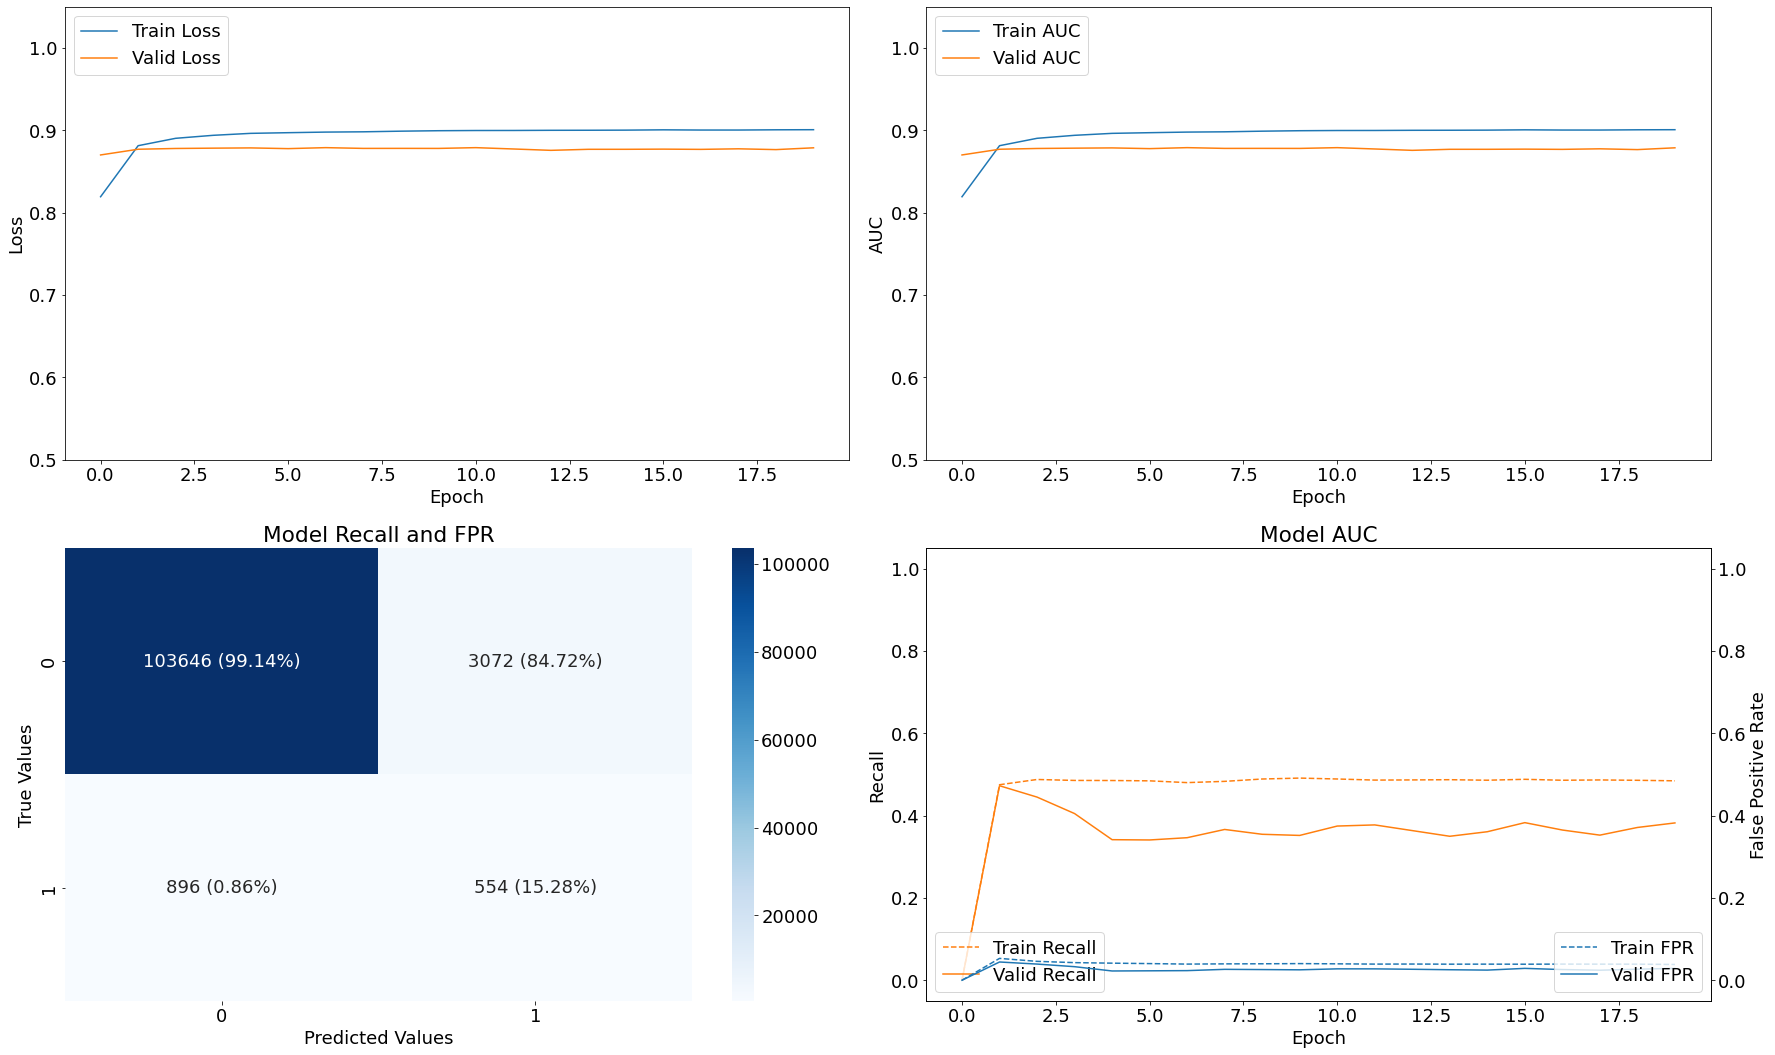

Results for model with threshold = 0.8.

 Train recall: 0.464406818151474 
 Val Recall: 0.5158620476722717 

 Train FPR: 0.04137192294001579 
 Val FPR: 0.060598962008953094


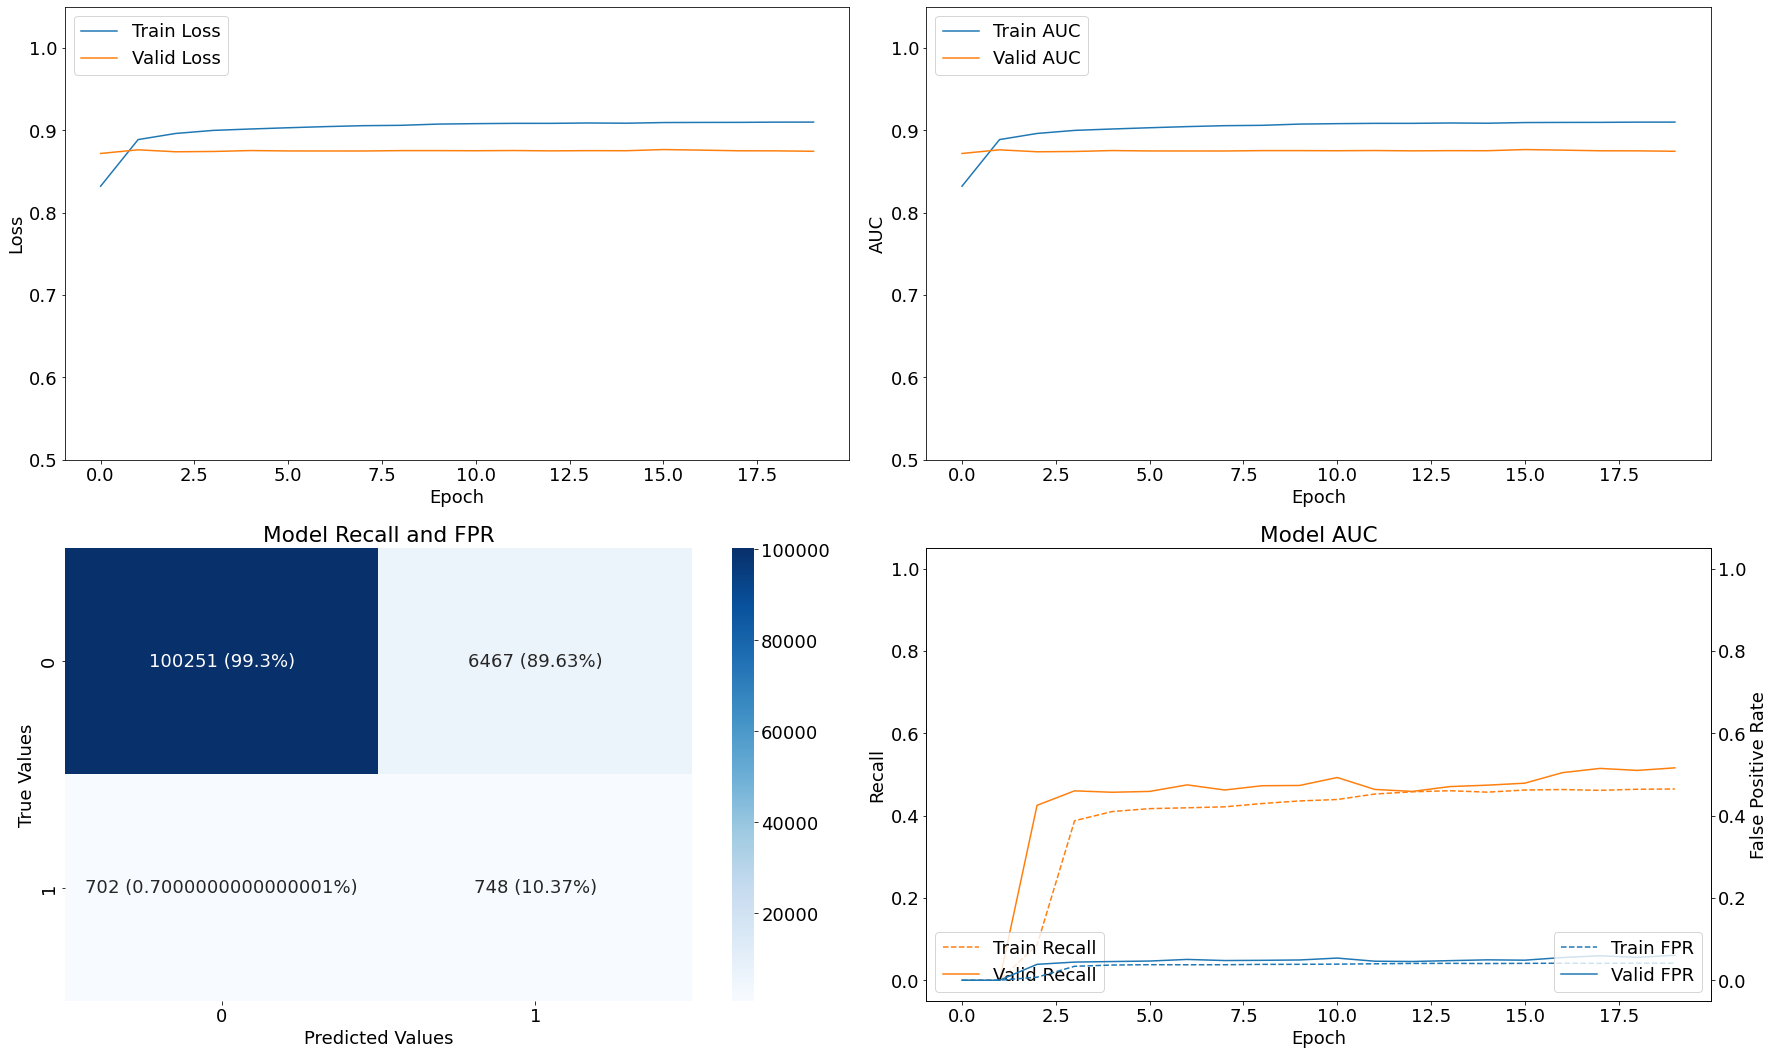

In [41]:
for t in thresholds:
    model_v4(threshold=t)

In [41]:
def model_v5(epochs=20, batch_size=512, threshold=0.5):      
    
    b_model_v5 = models.Sequential()

    b_model_v5.add(layers.Input(shape=(n_features, )))
    b_model_v5.add(layers.Dense(32, kernel_initializer='lecun_normal', activation='selu'))
    b_model_v5.add(layers.AlphaDropout(0.25))
    b_model_v5.add(layers.Dense(16, kernel_initializer='lecun_normal', activation='selu'))
    b_model_v5.add(layers.AlphaDropout(0.25))
    b_model_v5.add(layers.Dense(1, activation='sigmoid'))

    b_model_v5.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_model_v5_history = b_model_v5.fit(X_train_base_scaled_resampled,
                                        y_train_base_resampled,
                                        batch_size=batch_size,
                                        validation_data=(X_val_base_scaled, y_val_base),
                                        class_weight=class_weight,
                                        epochs=epochs, 
                                        verbose=0).history
    
    evaluate(b_model_v5, b_model_v5_history, X_val_base_scaled, y_val_base, threshold=threshold)

Results for model with threshold = 0.5.

 Train recall: 0.660244345664978 
 Val Recall: 0.522068977355957 

 Train FPR: 0.049589622765779495 
 Val FPR: 0.05611986666917801


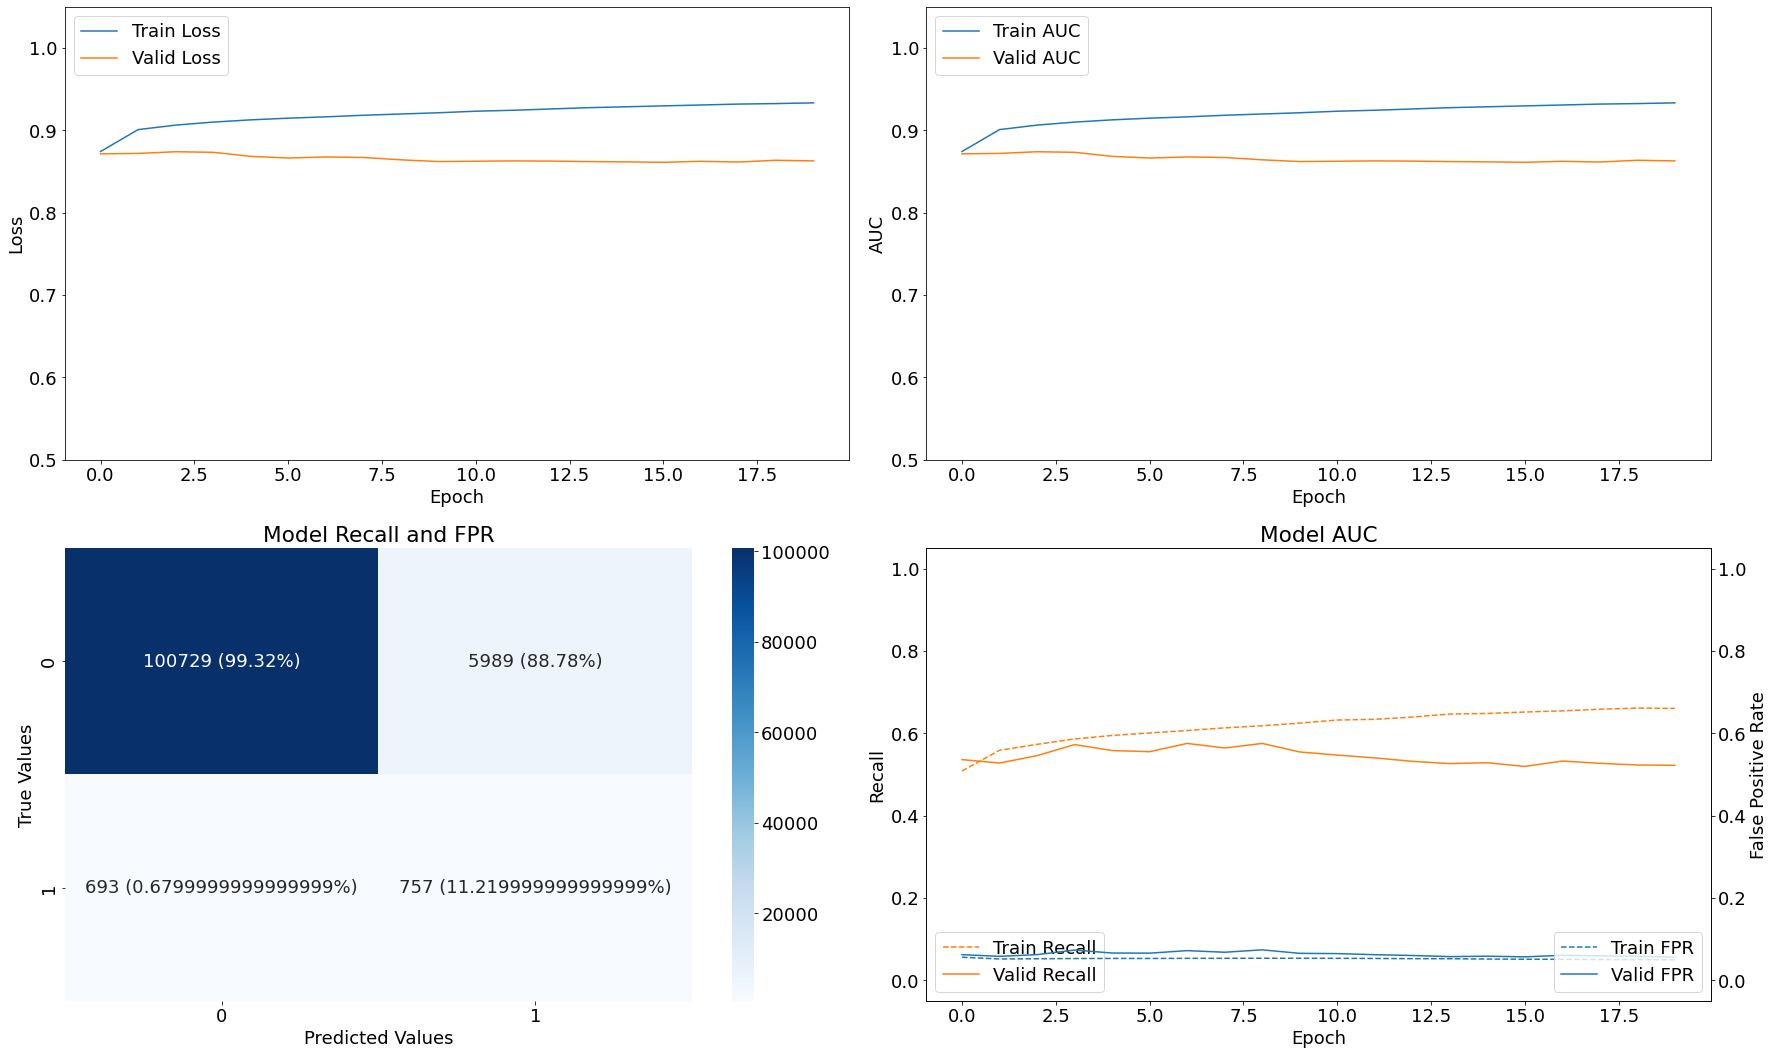

In [42]:
model_v5()

Results for model with threshold = 0.5.

 Train recall: 0.814807653427124 
 Val Recall: 0.7675862312316895 

 Train FPR: 0.12516172230243683 
 Val FPR: 0.16999943554401398


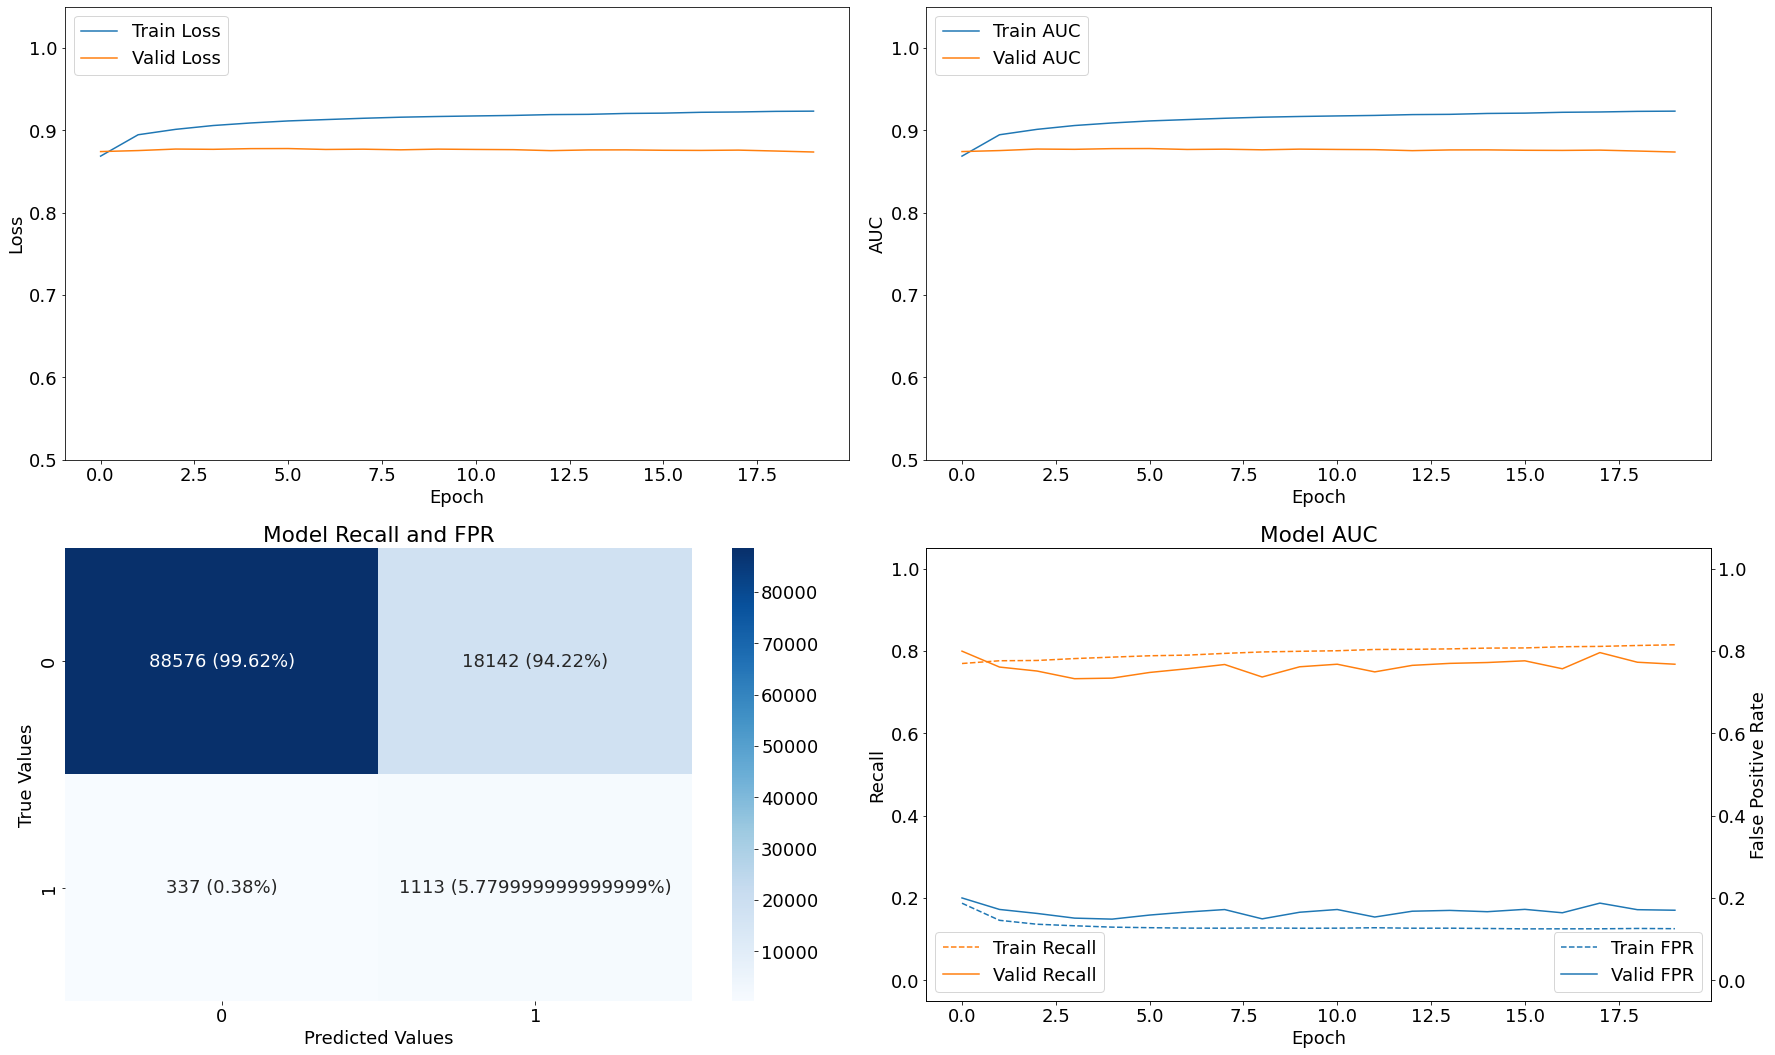

Results for model with threshold = 0.55.

 Train recall: 0.7793847918510437 
 Val Recall: 0.7165517210960388 

 Train FPR: 0.099564328789711 
 Val FPR: 0.13885192573070526


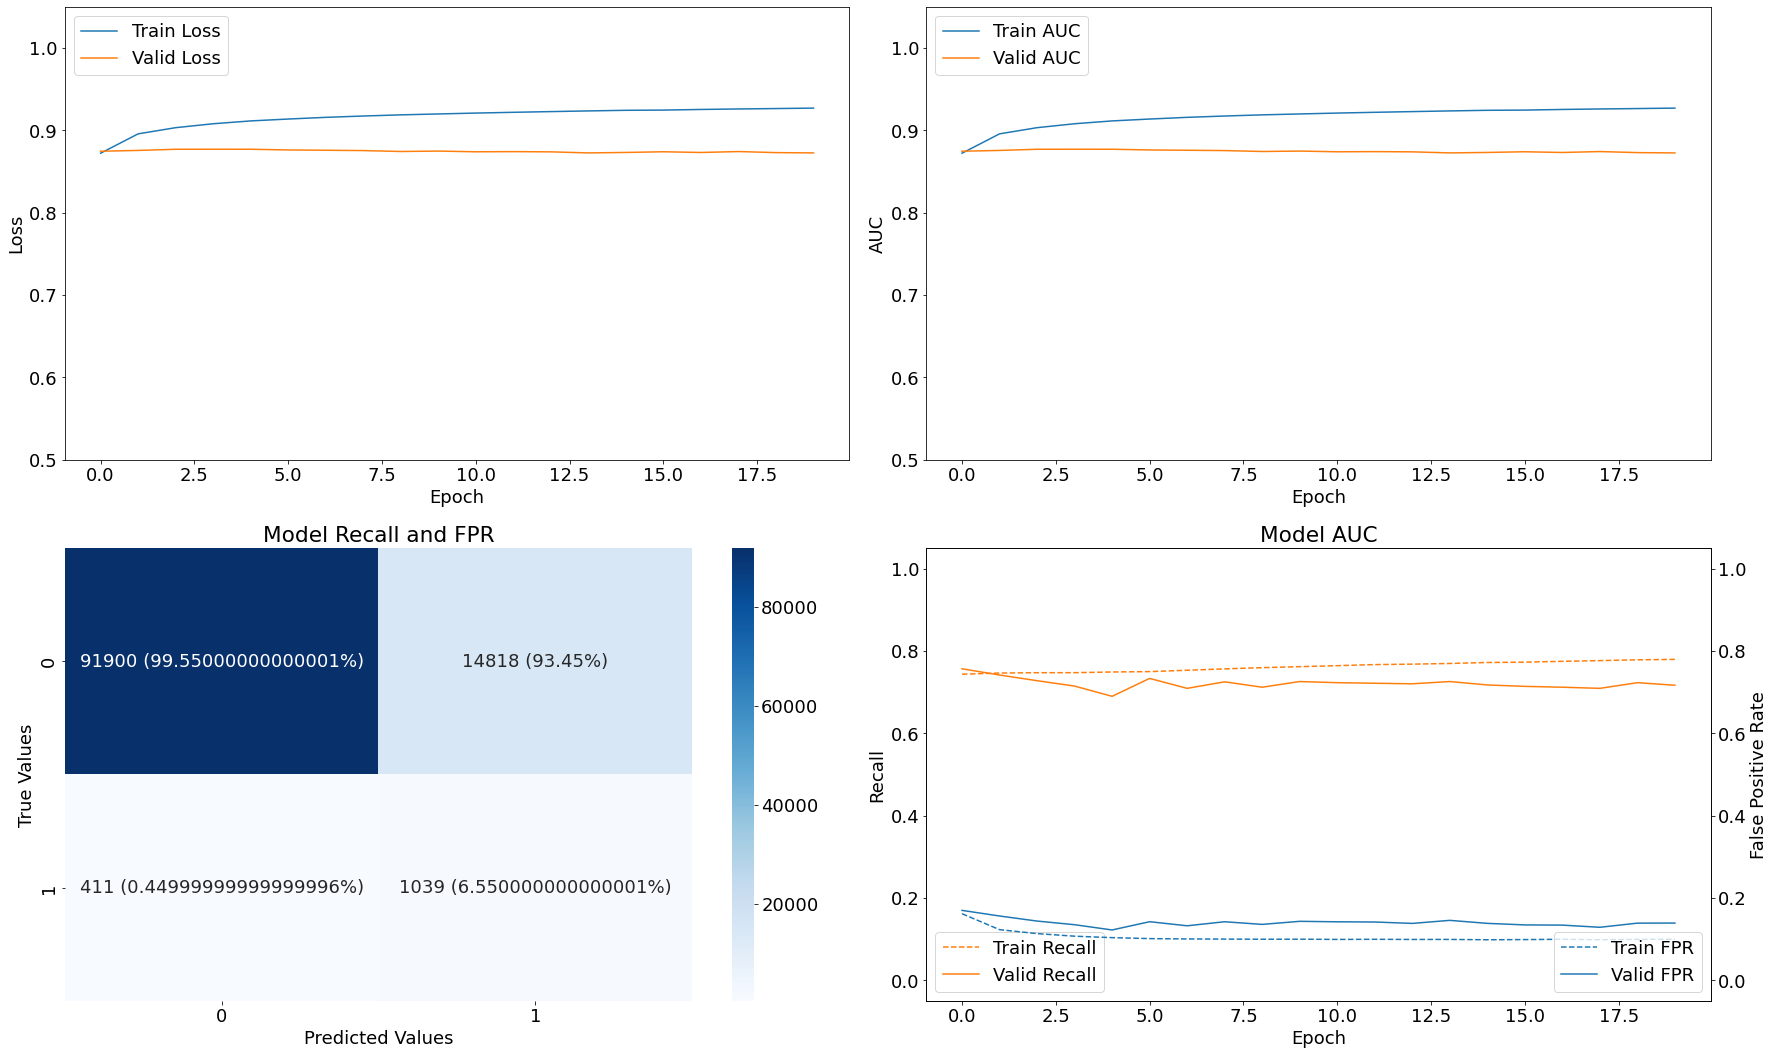

Results for model with threshold = 0.6.

 Train recall: 0.7375513911247253 
 Val Recall: 0.6737930774688721 

 Train FPR: 0.08300565183162689 
 Val FPR: 0.1209917739033699


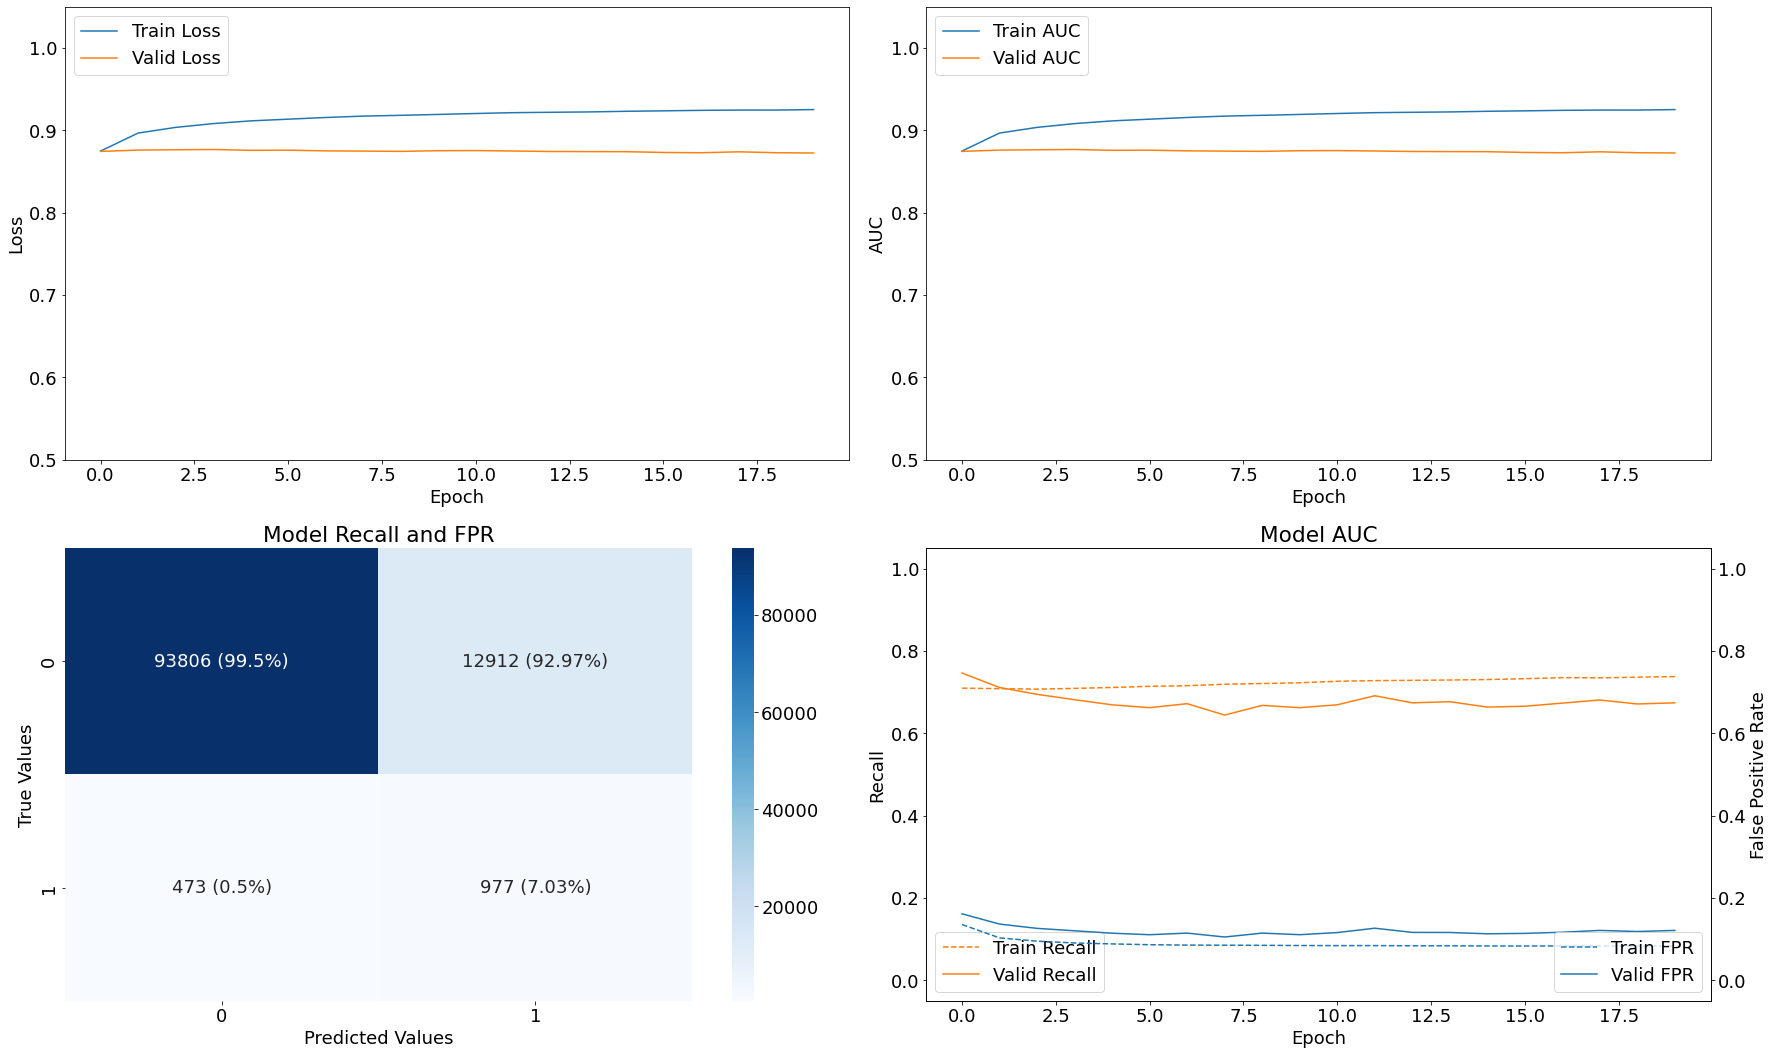

Results for model with threshold = 0.65.

 Train recall: 0.6979599595069885 
 Val Recall: 0.6634482741355896 

 Train FPR: 0.06950858980417252 
 Val FPR: 0.1077512726187706


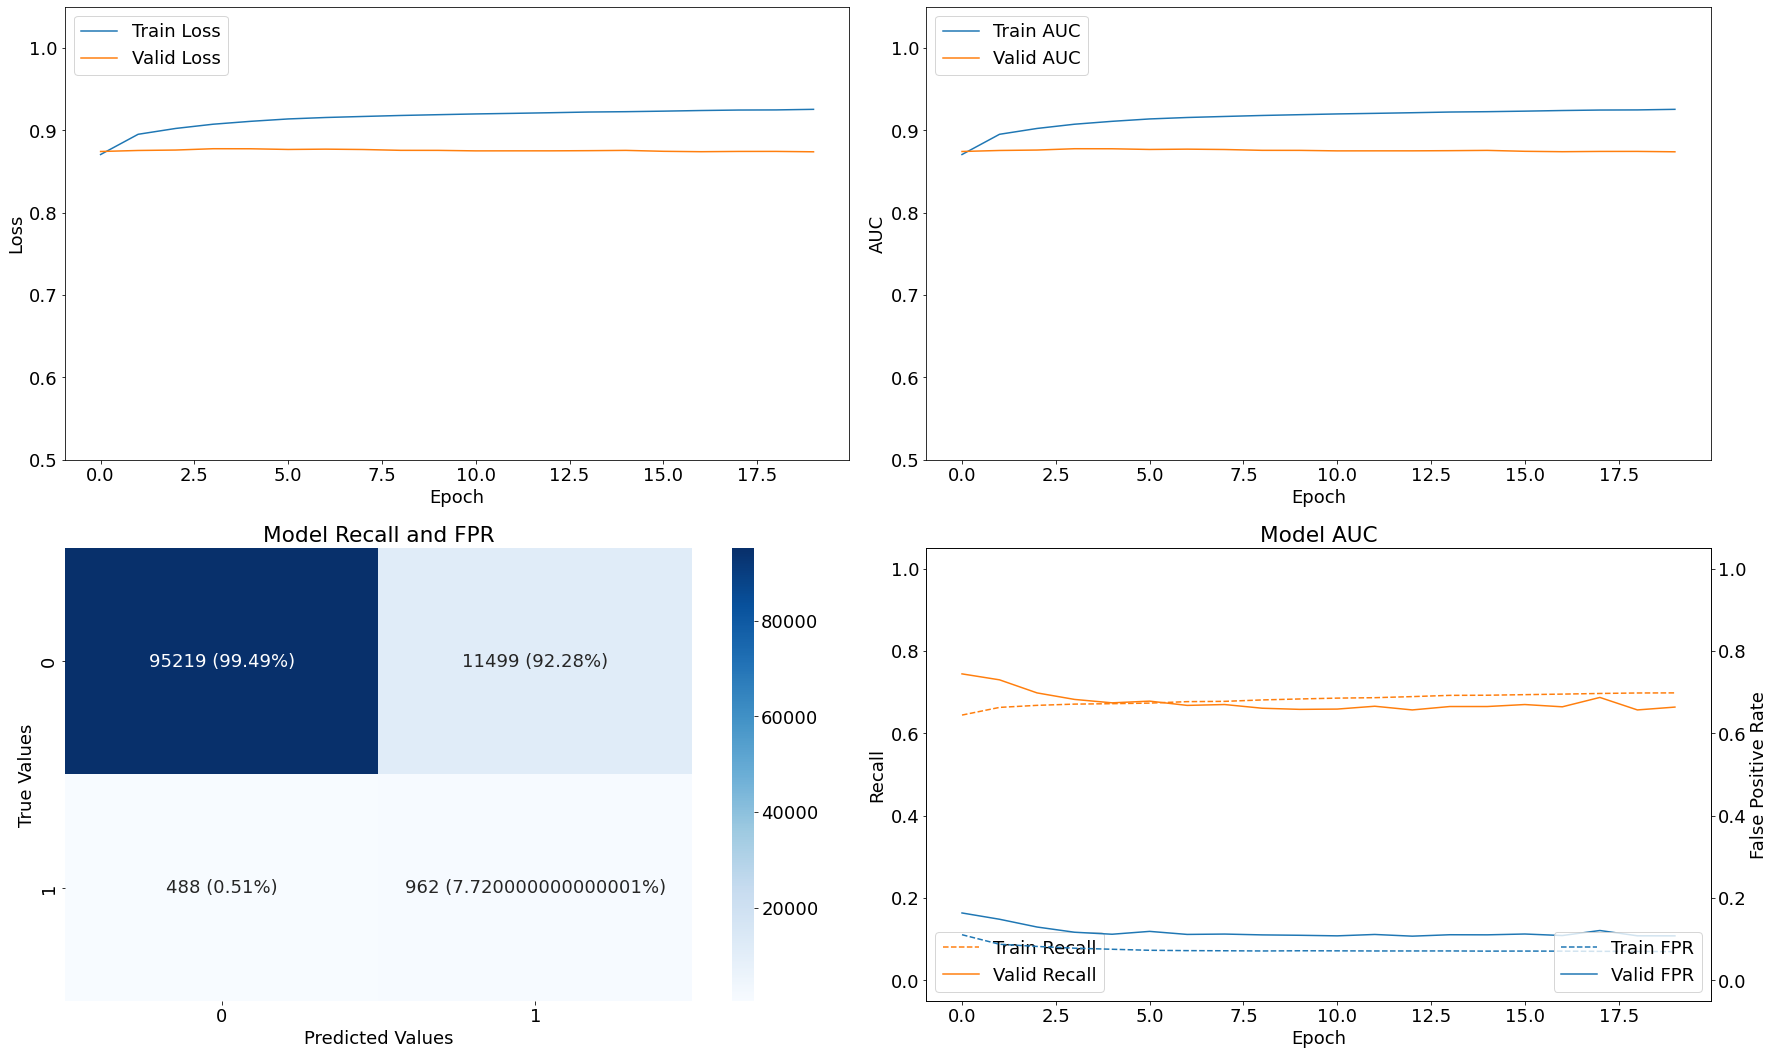

Results for model with threshold = 0.7.

 Train recall: 0.6611695289611816 
 Val Recall: 0.6648275852203369 

 Train FPR: 0.05773361399769783 
 Val FPR: 0.11114338785409927


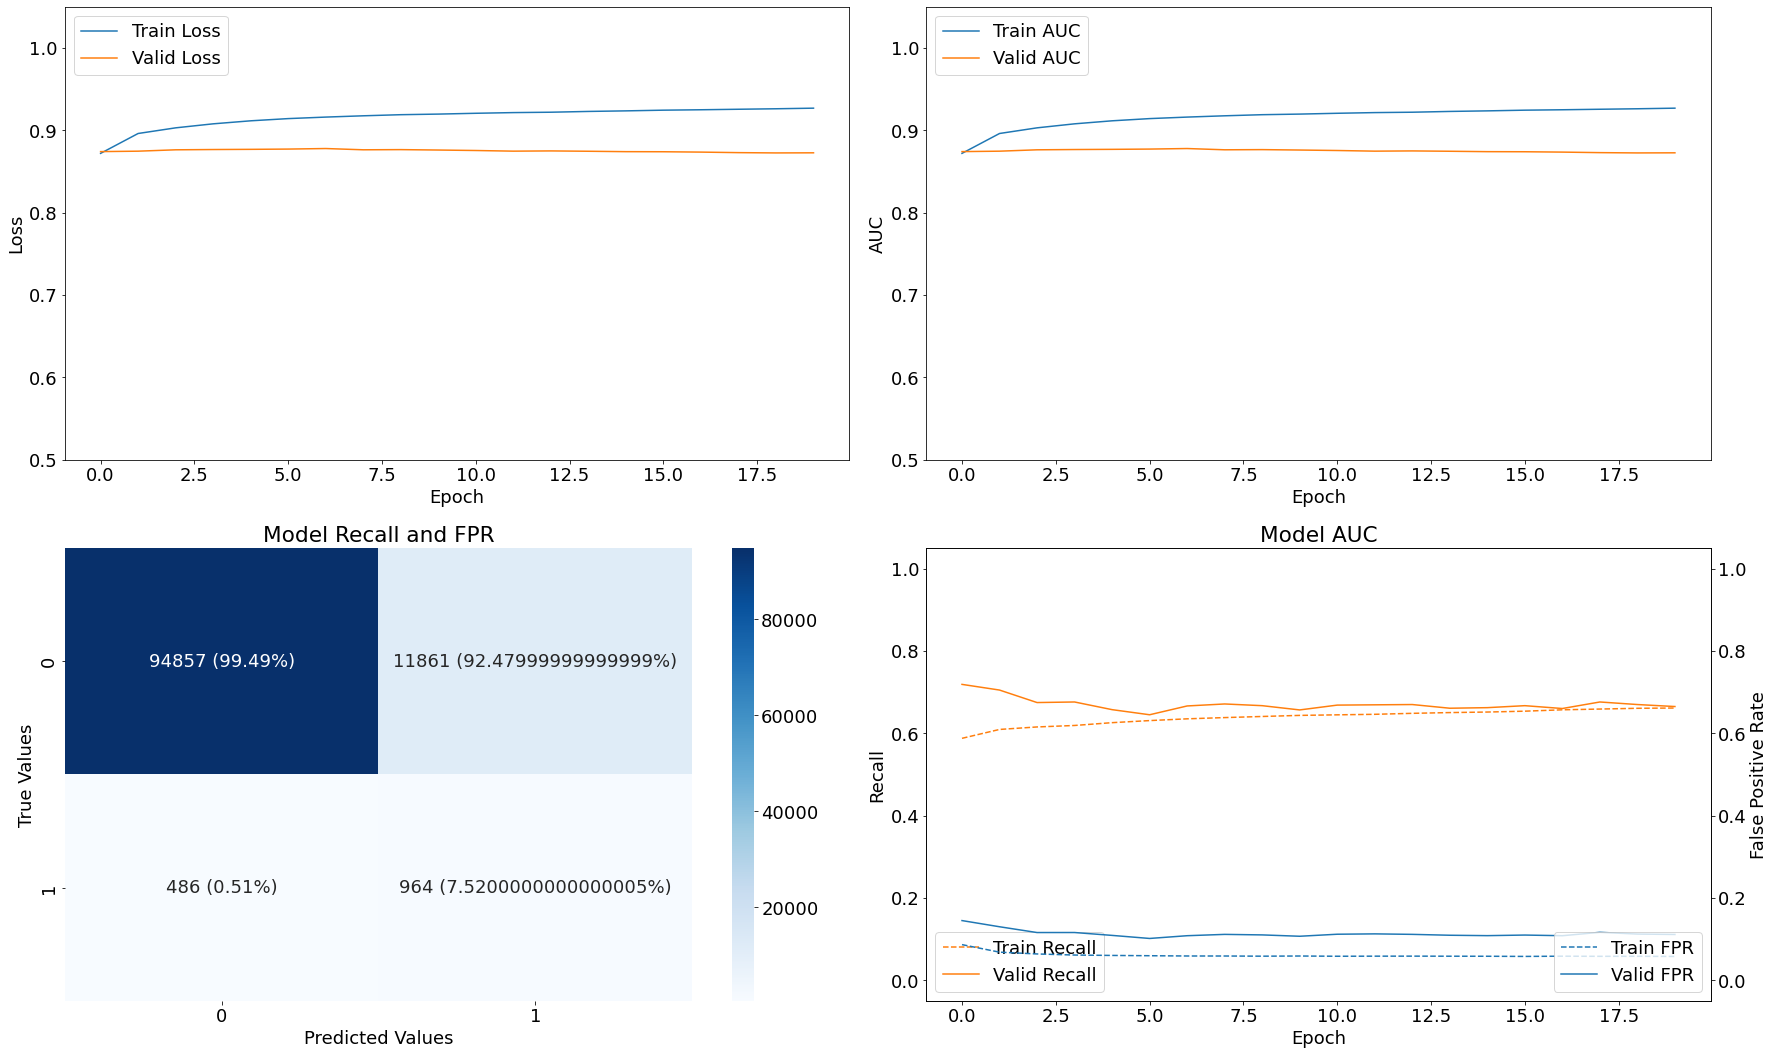

Results for model with threshold = 0.75.

 Train recall: 0.6093518733978271 
 Val Recall: 0.656551718711853 

 Train FPR: 0.04936213046312332 
 Val FPR: 0.10829475522041321


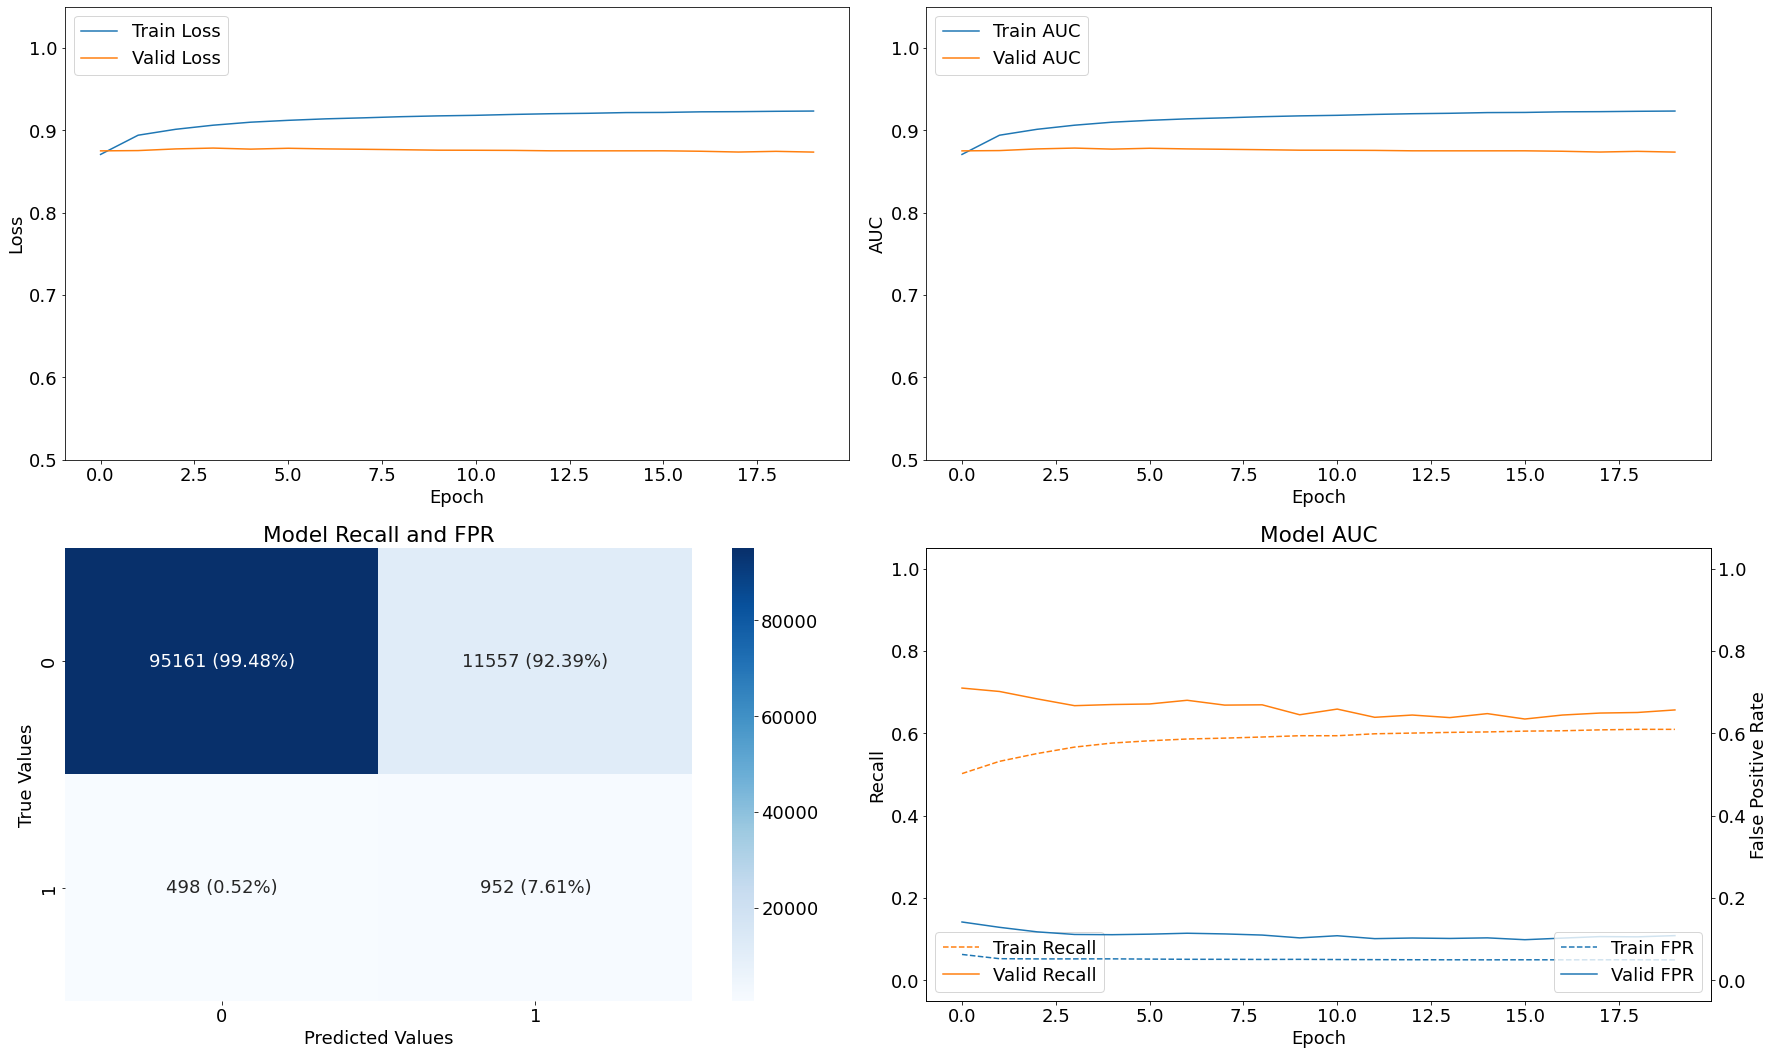

Results for model with threshold = 0.8.

 Train recall: 0.5414800643920898 
 Val Recall: 0.6013793349266052 

 Train FPR: 0.03660601004958153 
 Val FPR: 0.08498097956180573


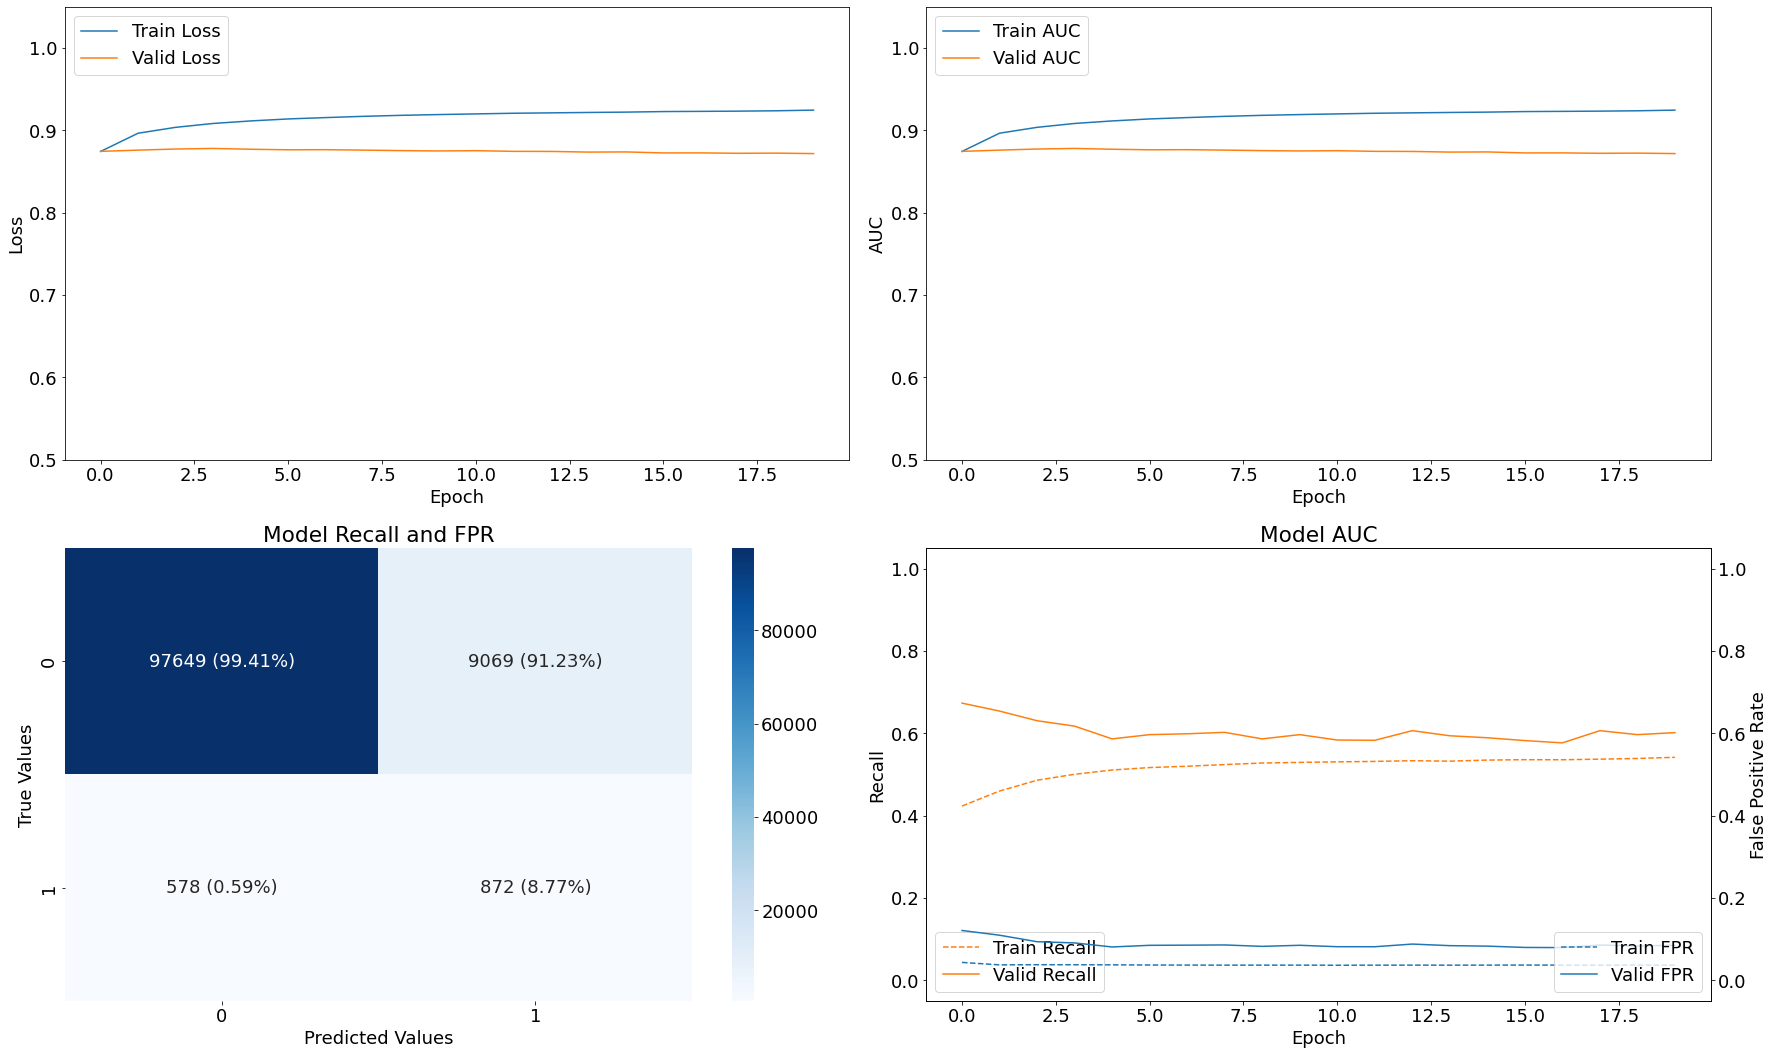

In [43]:
for t in thresholds:
    model_v5(threshold=t)

In [43]:
def model_v6(epochs=20, batch_size=512, threshold=0.5):

    b_model_v6 = models.Sequential()

    b_model_v6.add(layers.Input(shape=(n_features, )))
    b_model_v6.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2()))
    b_model_v6.add(layers.Dropout(0.5))
    b_model_v6.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.L2()))
    b_model_v6.add(layers.Dropout(0.5))
    b_model_v6.add(layers.Dense(8, activation='relu', kernel_regularizer=regularizers.L2()))
    b_model_v6.add(layers.Dropout(0.5))
    b_model_v6.add(layers.Dense(4, activation='relu', kernel_regularizer=regularizers.L2()))
    b_model_v6.add(layers.Dense(2, activation='relu', kernel_regularizer=regularizers.L2()))
    b_model_v6.add(layers.Dense(1, activation='sigmoid'))

    b_model_v6.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['AUC',
                              tf.keras.metrics.Recall(thresholds=threshold),
                              FalsePositiveRate(threshold=threshold)])

    b_model_v6_history = b_model_v6.fit(X_train_base_scaled_resampled,
                                        y_train_base_resampled,
                                        batch_size=batch_size,
                                        validation_data=(X_val_base_scaled, y_val_base),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=0).history
    
    evaluate(b_model_v6, b_model_v6_history, X_val_base_scaled, y_val_base, threshold=threshold)

Results for model with threshold = 0.5.

 Train recall: 0.4370669424533844 
 Val Recall: 0.36206895112991333 

 Train FPR: 0.04828440025448799 
 Val FPR: 0.02649974636733532


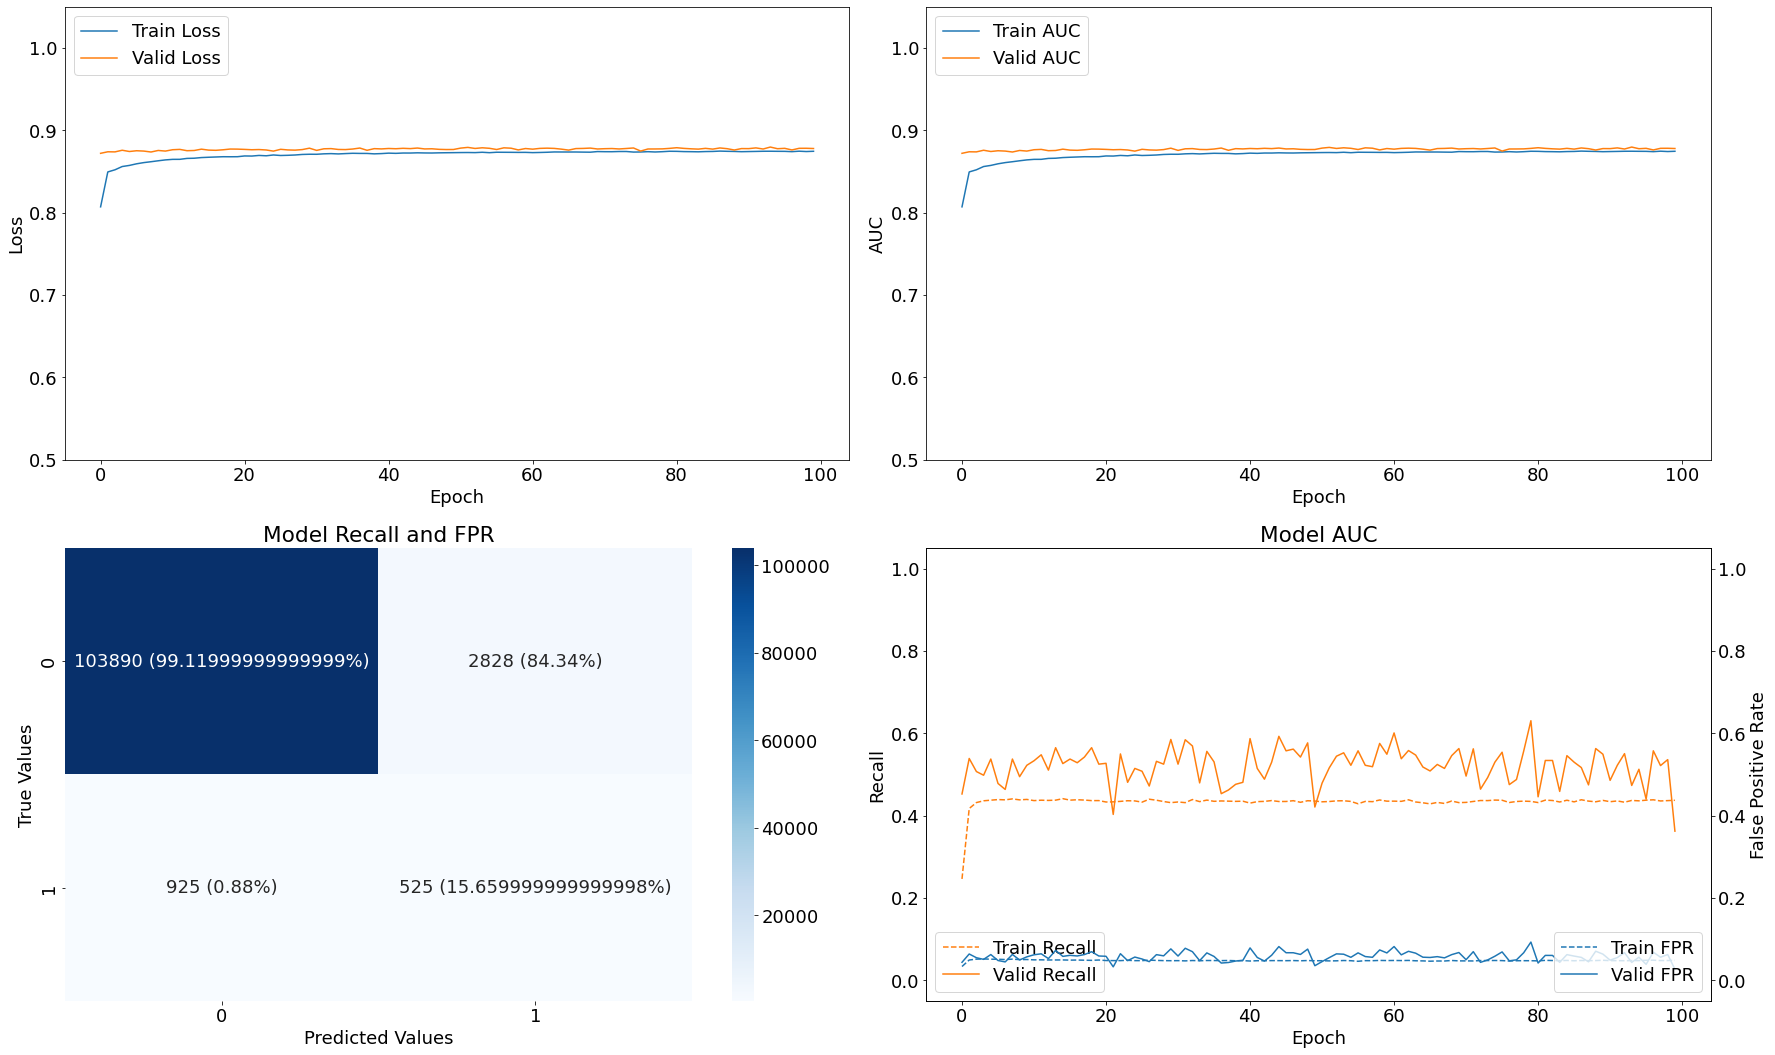

In [46]:
model_v6(epochs=100)

Results for model with threshold = 0.5.

 Train recall: 0.77098149061203 
 Val Recall: 0.7924137711524963 

 Train FPR: 0.16239048540592194 
 Val FPR: 0.19492493569850922


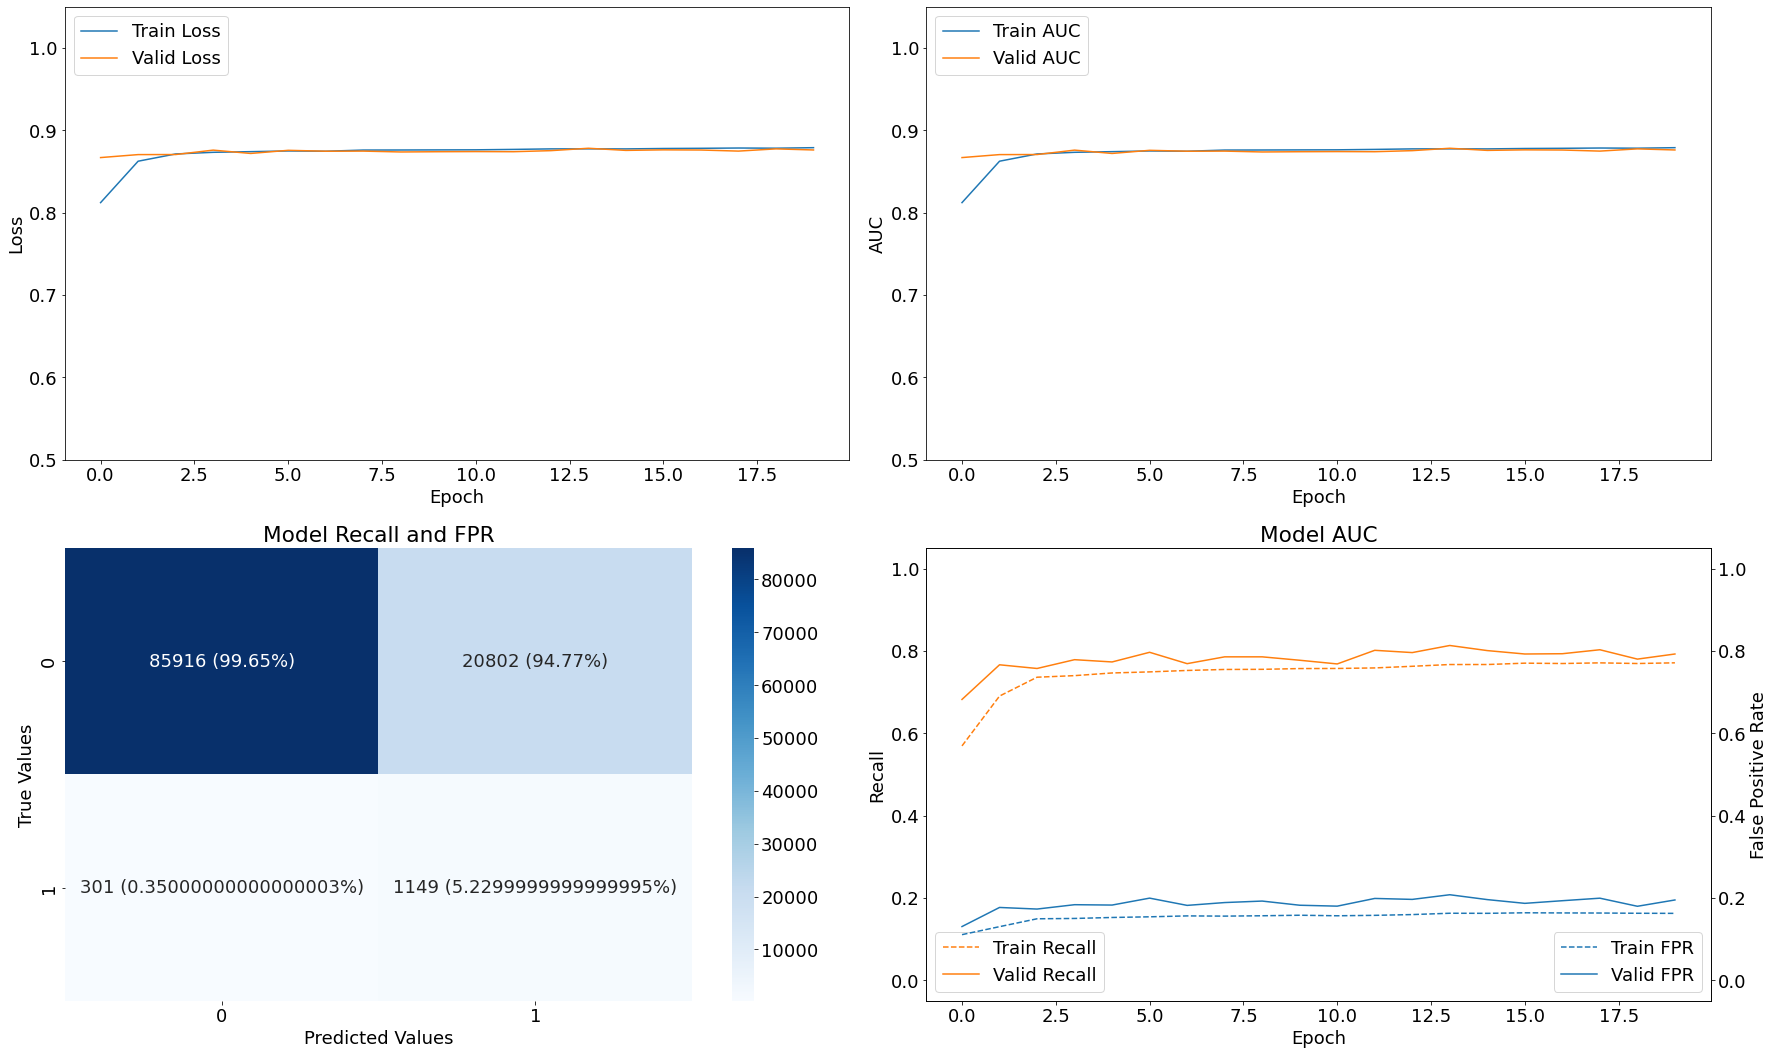

Results for model with threshold = 0.55.

 Train recall: 0.7998464703559875 
 Val Recall: 0.6634482741355896 

 Train FPR: 0.16083107888698578 
 Val FPR: 0.10935362428426743


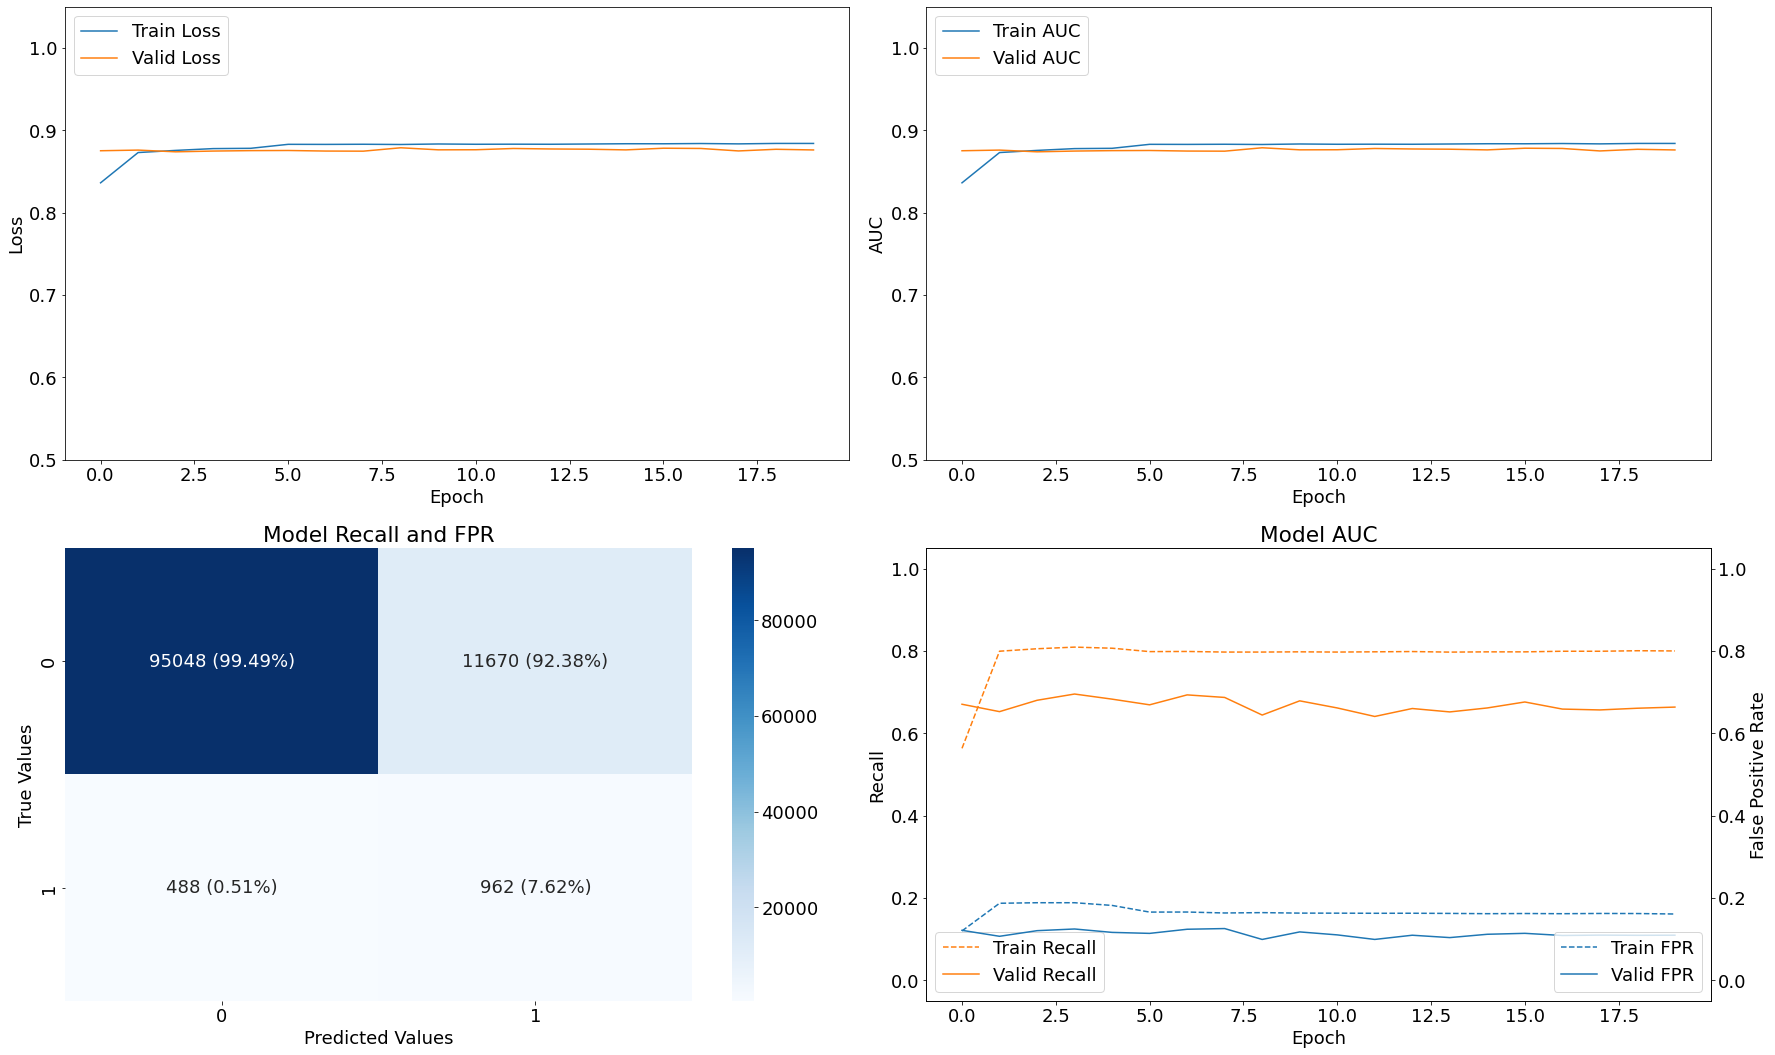

Results for model with threshold = 0.6.

 Train recall: 0.5403769016265869 
 Val Recall: 0.6282758712768555 

 Train FPR: 0.08011560142040253 
 Val FPR: 0.0973406583070755


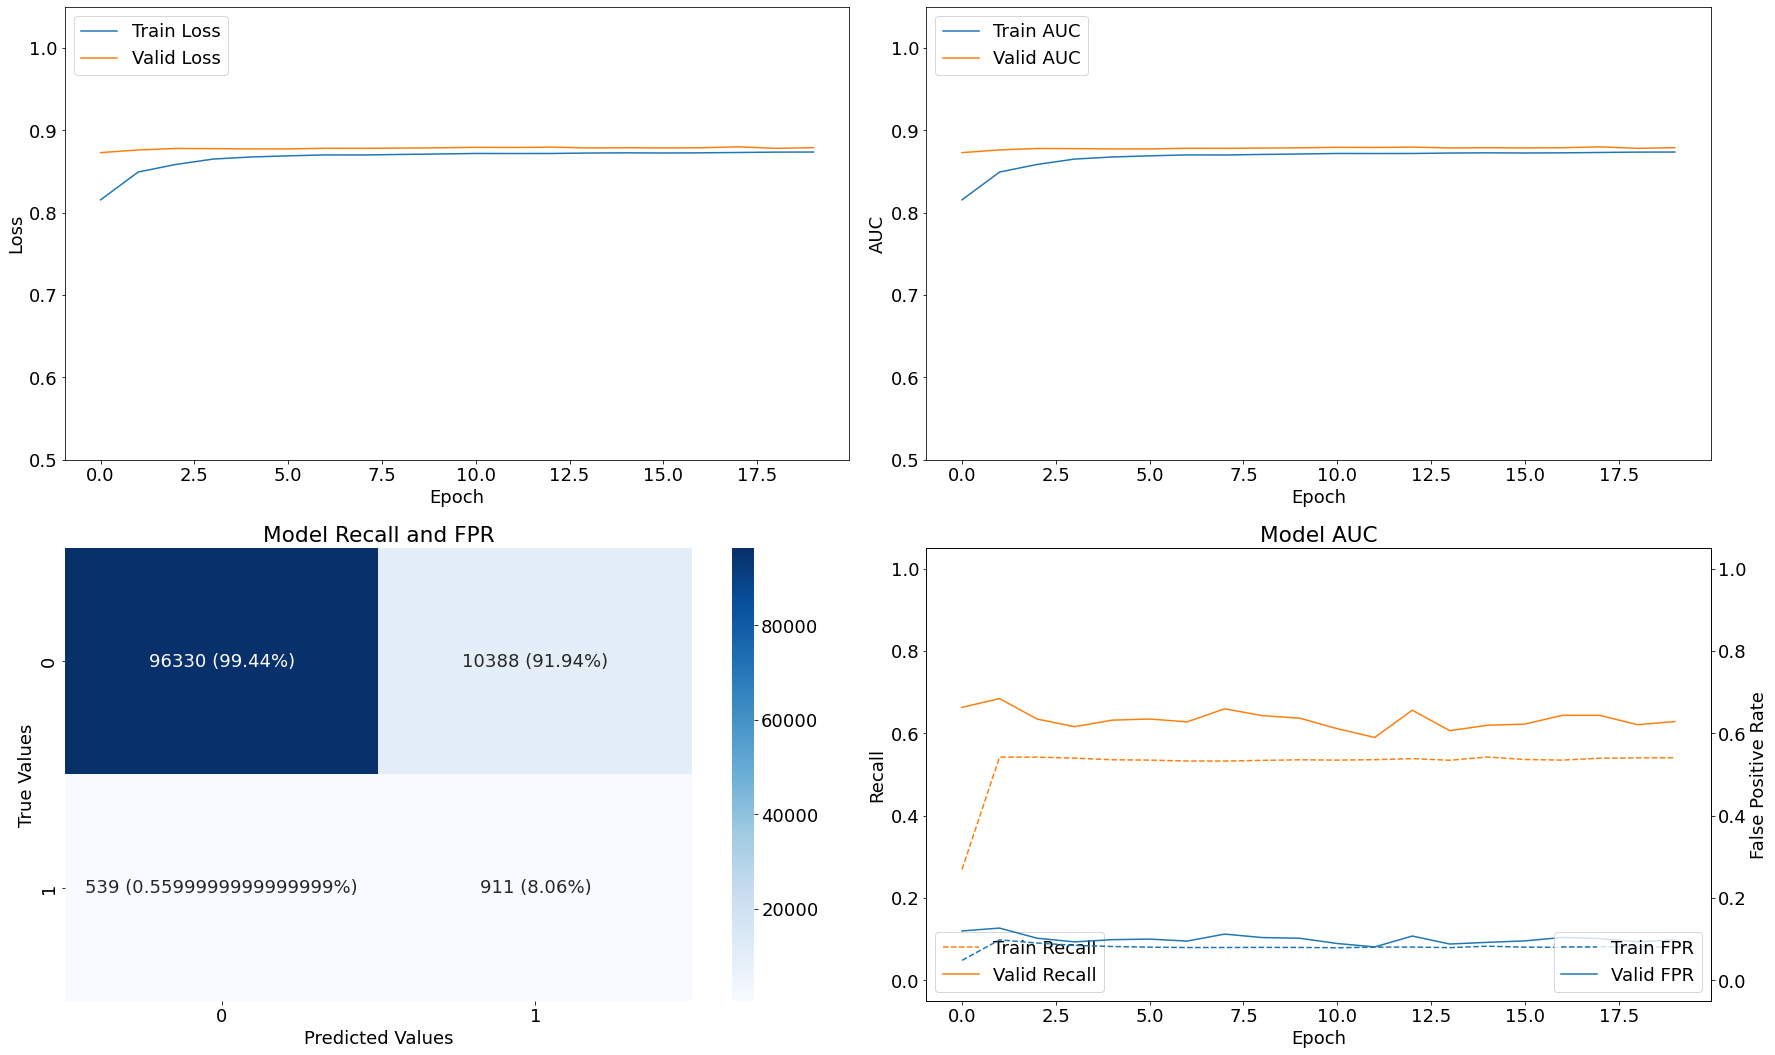

Results for model with threshold = 0.65.

 Train recall: 0.5945940613746643 
 Val Recall: 0.6531034708023071 

 Train FPR: 0.08171440660953522 
 Val FPR: 0.10806049406528473


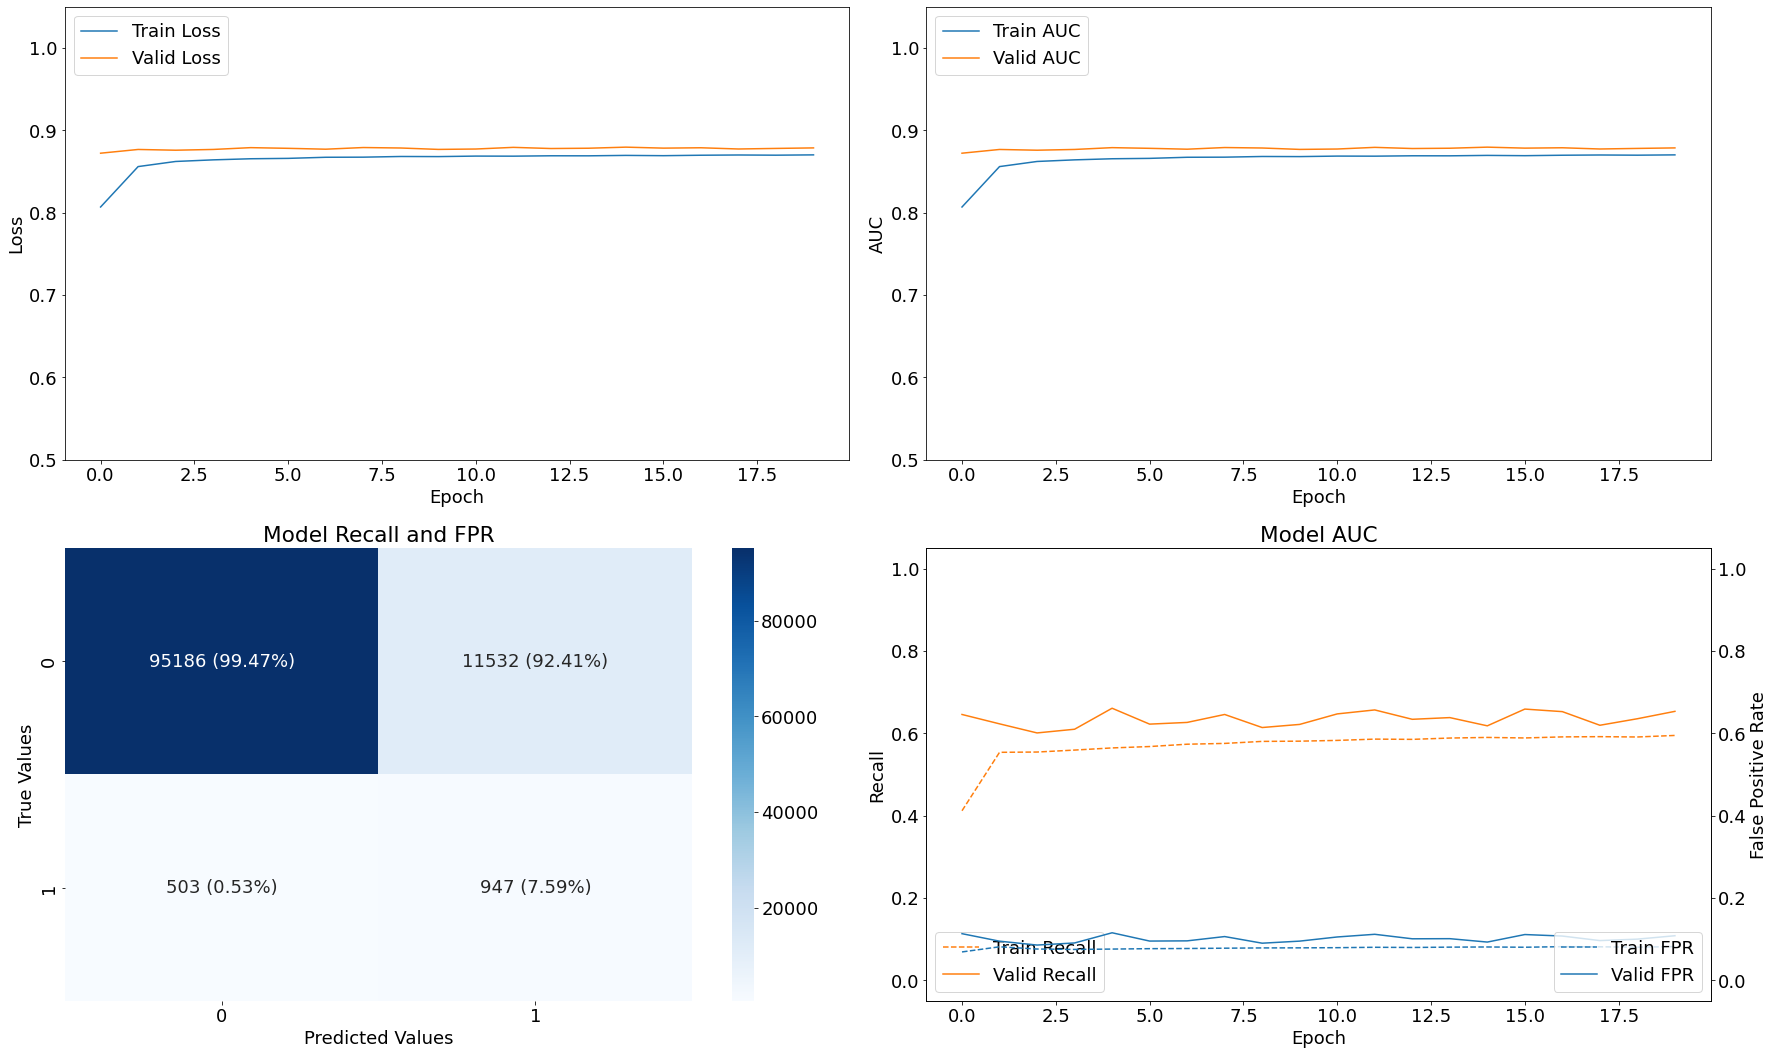

Results for model with threshold = 0.7.

 Train recall: 0.6183347105979919 
 Val Recall: 0.6420689821243286 

 Train FPR: 0.08859129995107651 
 Val FPR: 0.10404055565595627


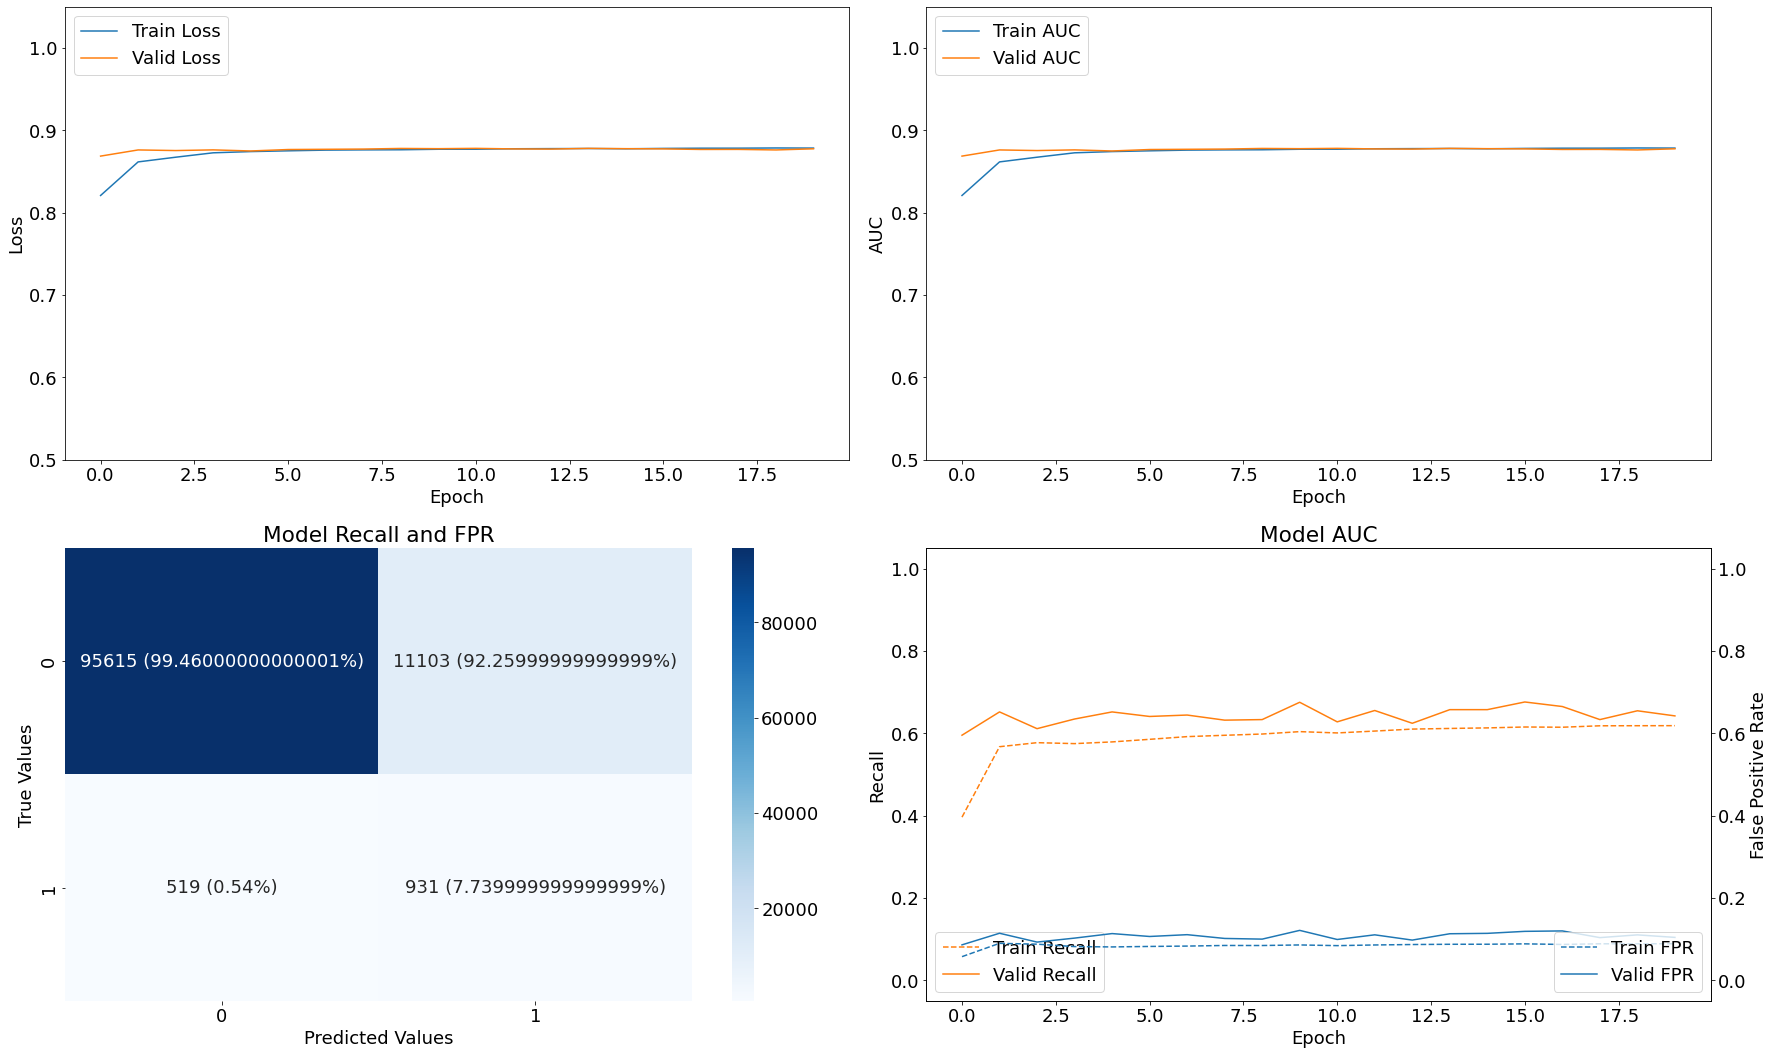

Results for model with threshold = 0.75.

 Train recall: 0.24626225233078003 
 Val Recall: 0.28206896781921387 

 Train FPR: 0.024986082687973976 
 Val FPR: 0.016473323106765747


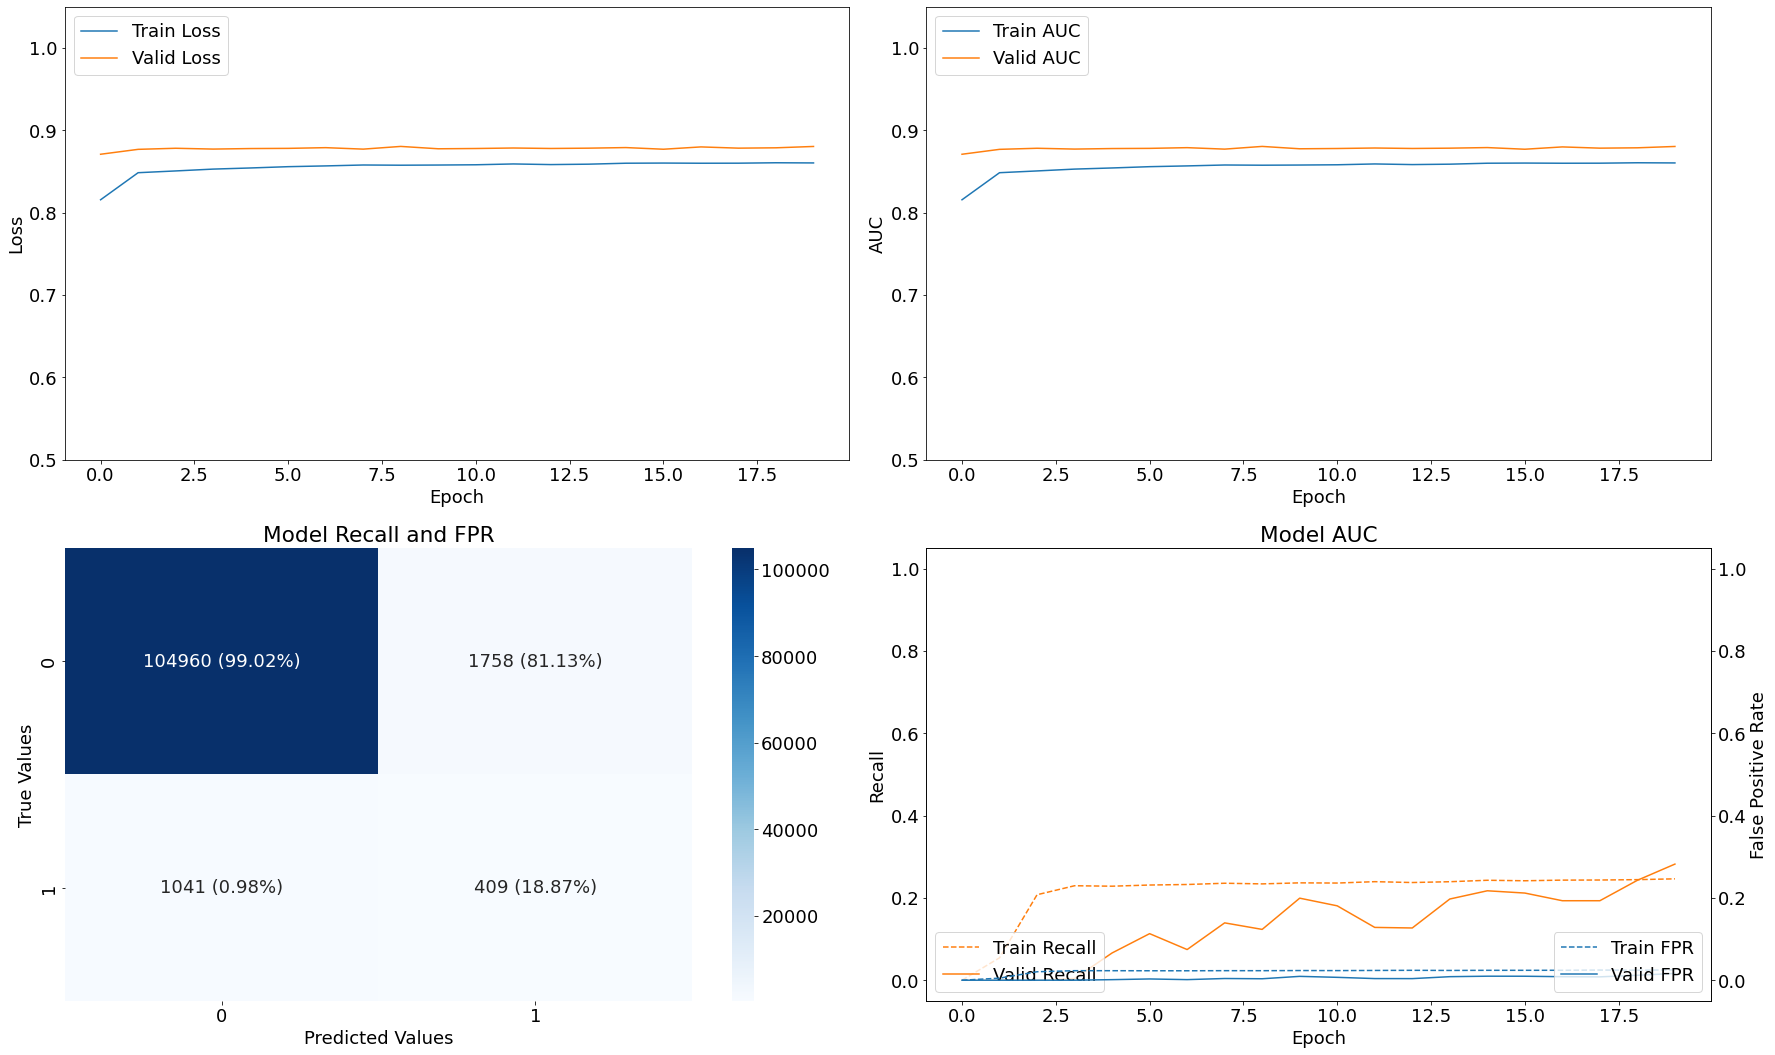

Results for model with threshold = 0.8.

 Train recall: 0.3569130003452301 
 Val Recall: 0.44275861978530884 

 Train FPR: 0.03276532143354416 
 Val FPR: 0.038119155913591385


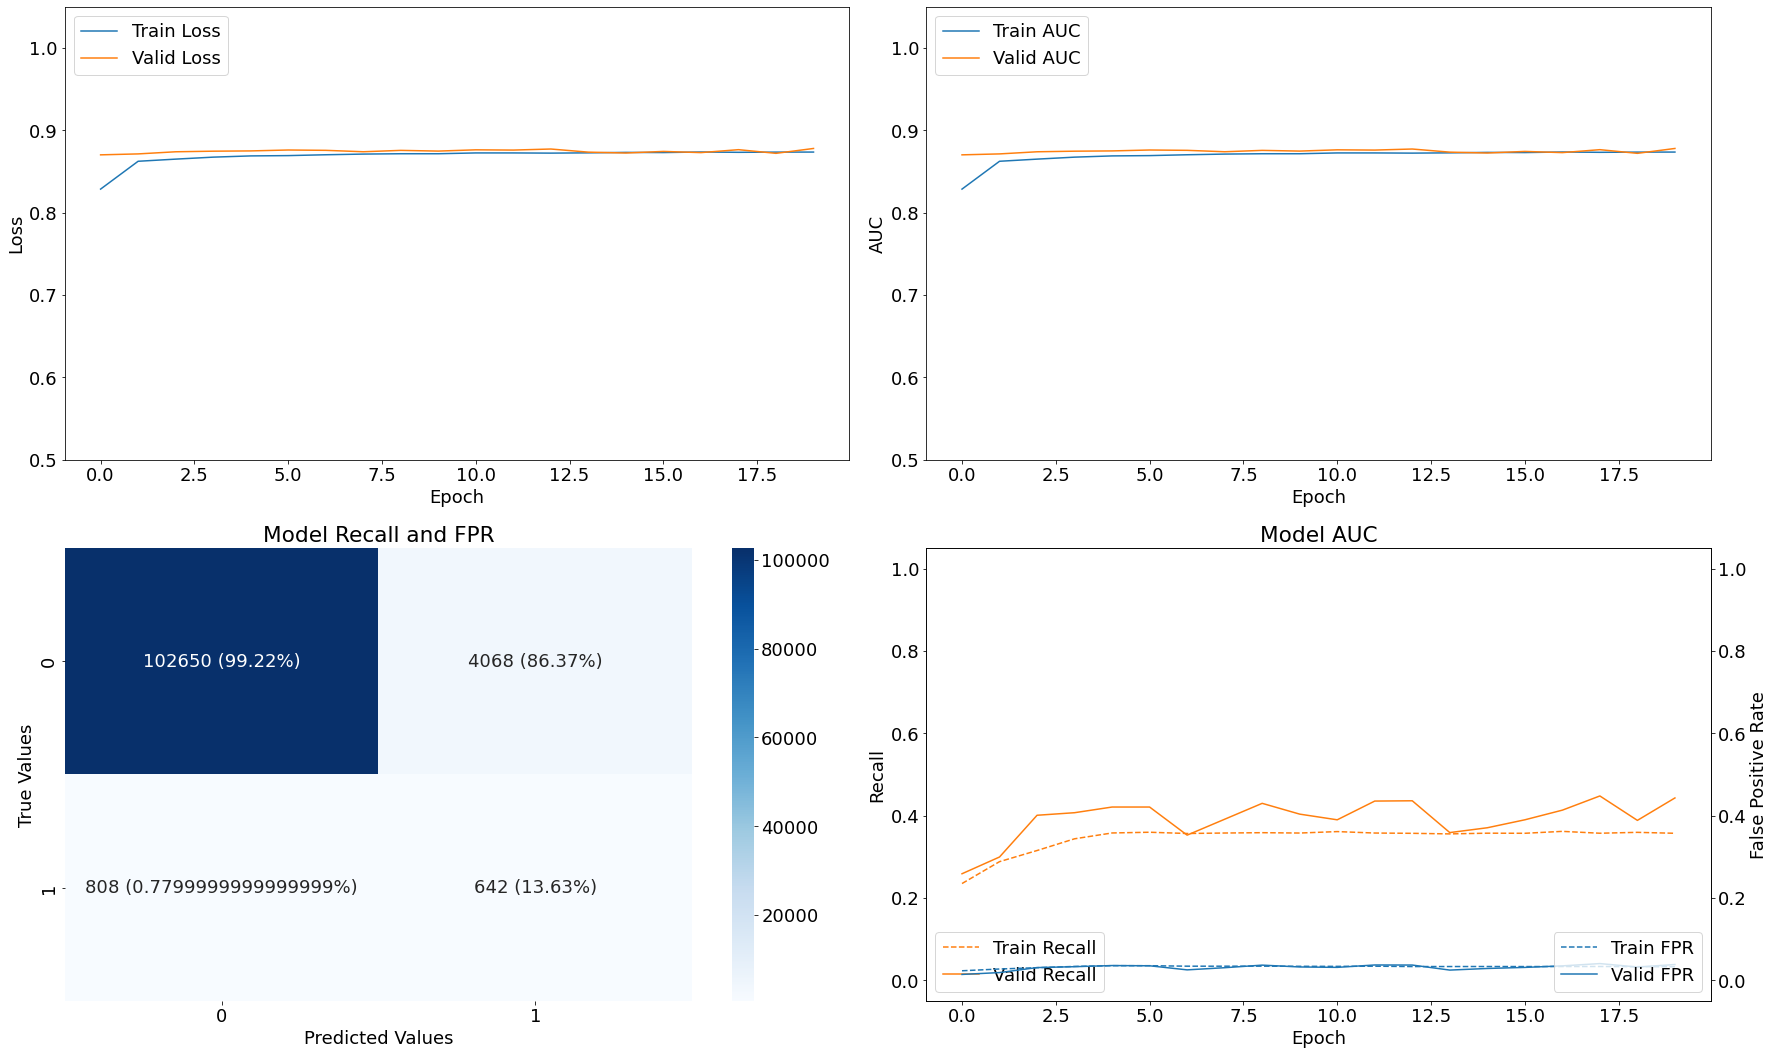

In [45]:
for t in thresholds:
    model_v6(threshold=t)

In [46]:
def model_v7(epochs=20, batch_size=512, threshold=0.5):   
    
    b_model_v7 = models.Sequential()

    b_model_v7.add(layers.Input(shape=(n_features, )))
    b_model_v7.add(layers.Dense(32,
                                activation='relu',
                                kernel_regularizer=regularizers.L2(l2=0.025)))
    b_model_v7.add(layers.Dropout(0.5))
    b_model_v7.add(layers.Dense(16,
                                activation='relu',
                                kernel_regularizer=regularizers.L2(l2=0.025)))
    b_model_v7.add(layers.Dropout(0.5))
    b_model_v7.add(layers.Dense(8,
                                activation='relu',
                                kernel_regularizer=regularizers.L2(l2=0.025)))
    b_model_v7.add(layers.Dropout(0.5))
    b_model_v7.add(layers.Dense(4,
                                activation='relu',
                                kernel_regularizer=regularizers.L2(l2=0.025)))
    b_model_v7.add(layers.Dense(2,
                                activation='relu',
                                kernel_regularizer=regularizers.L2(l2=0.025)))
    b_model_v7.add(layers.Dense(1, activation='sigmoid'))

    b_model_v7.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_model_v7_history = b_model_v7.fit(X_train_scaled_resampled,
                                        y_train_resampled,
                                        batch_size=batch_size,
                                        validation_data=(X_val_scaled, y_val),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=0).history
    
    evaluate(b_model_v7, b_model_v7_history, X_val_scaled, y_val, threshold=threshold)

Results for model with threshold = 0.5.

 Train recall: 0.0 
 Val Recall: 0.0 

 Train FPR: 0.0 
 Val FPR: 0.0


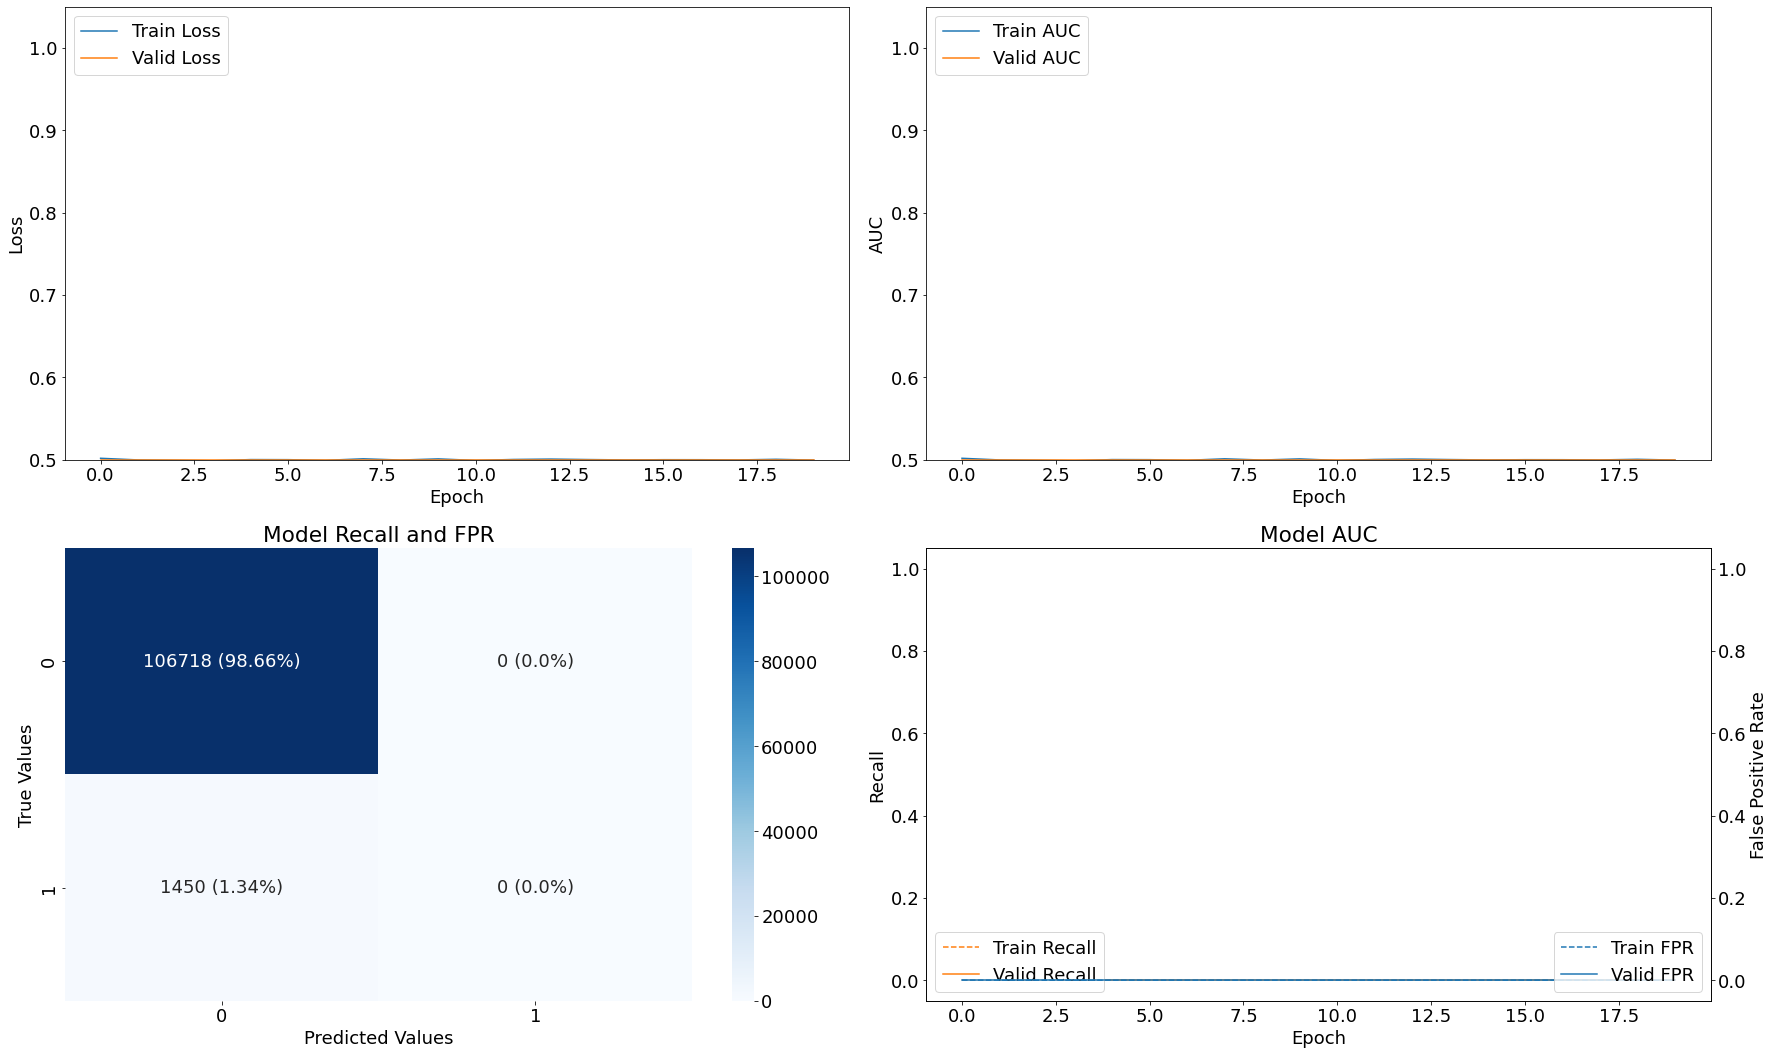

Results for model with threshold = 0.55.

 Train recall: 0.0 
 Val Recall: 0.0 

 Train FPR: 0.0 
 Val FPR: 0.0


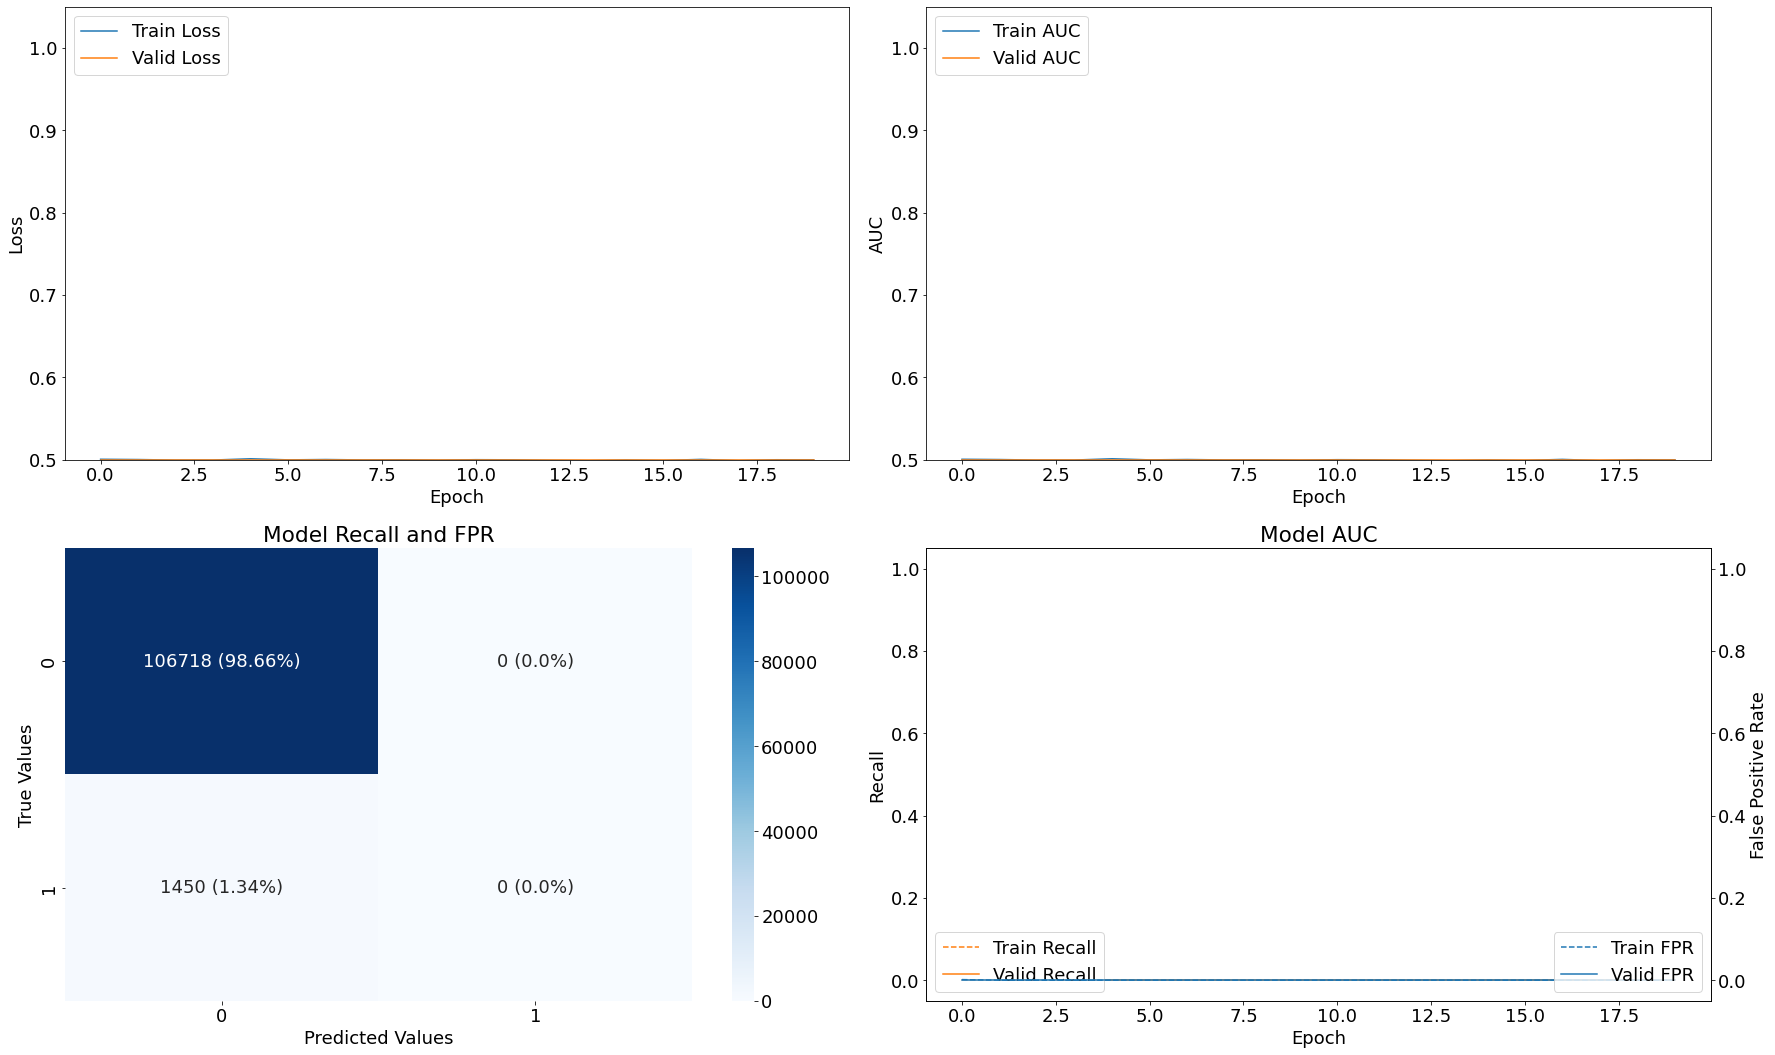

Results for model with threshold = 0.6.

 Train recall: 0.6662735342979431 
 Val Recall: 0.7434482574462891 

 Train FPR: 0.12097916007041931 
 Val FPR: 0.16152851283550262


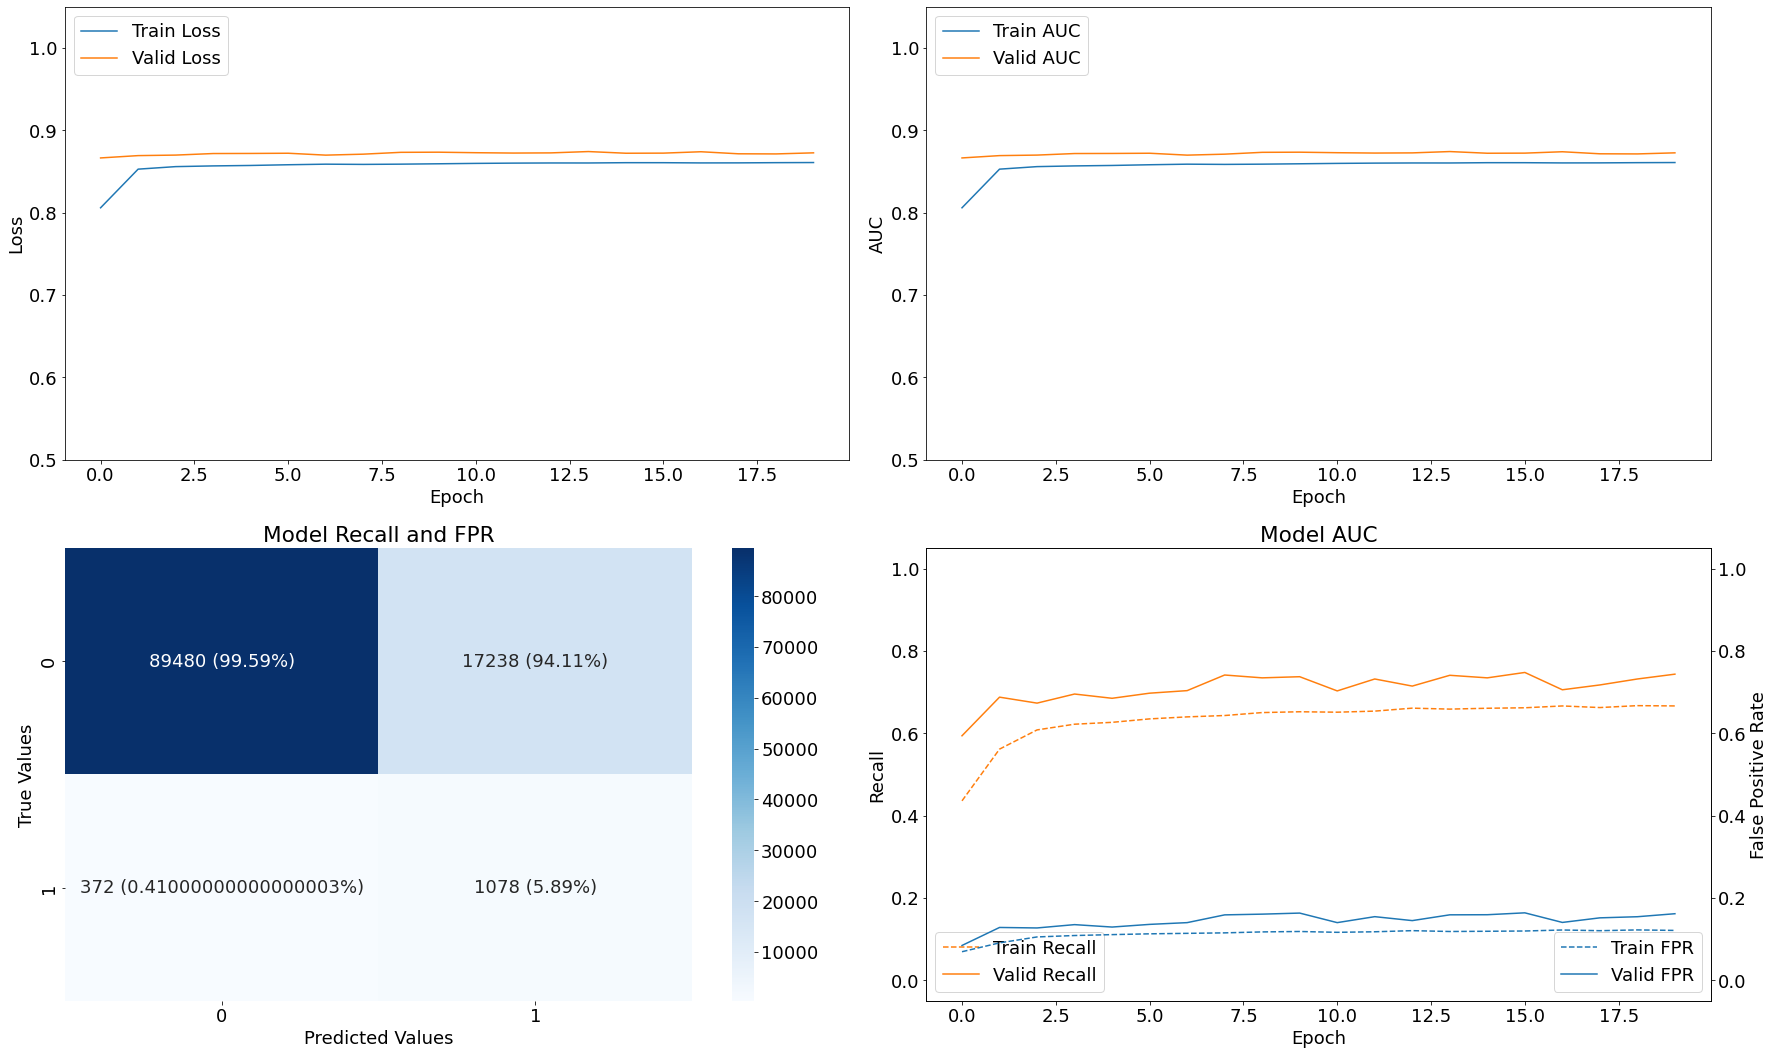

Results for model with threshold = 0.65.

 Train recall: 0.620632529258728 
 Val Recall: 0.6531034708023071 

 Train FPR: 0.10021504014730453 
 Val FPR: 0.11460109800100327


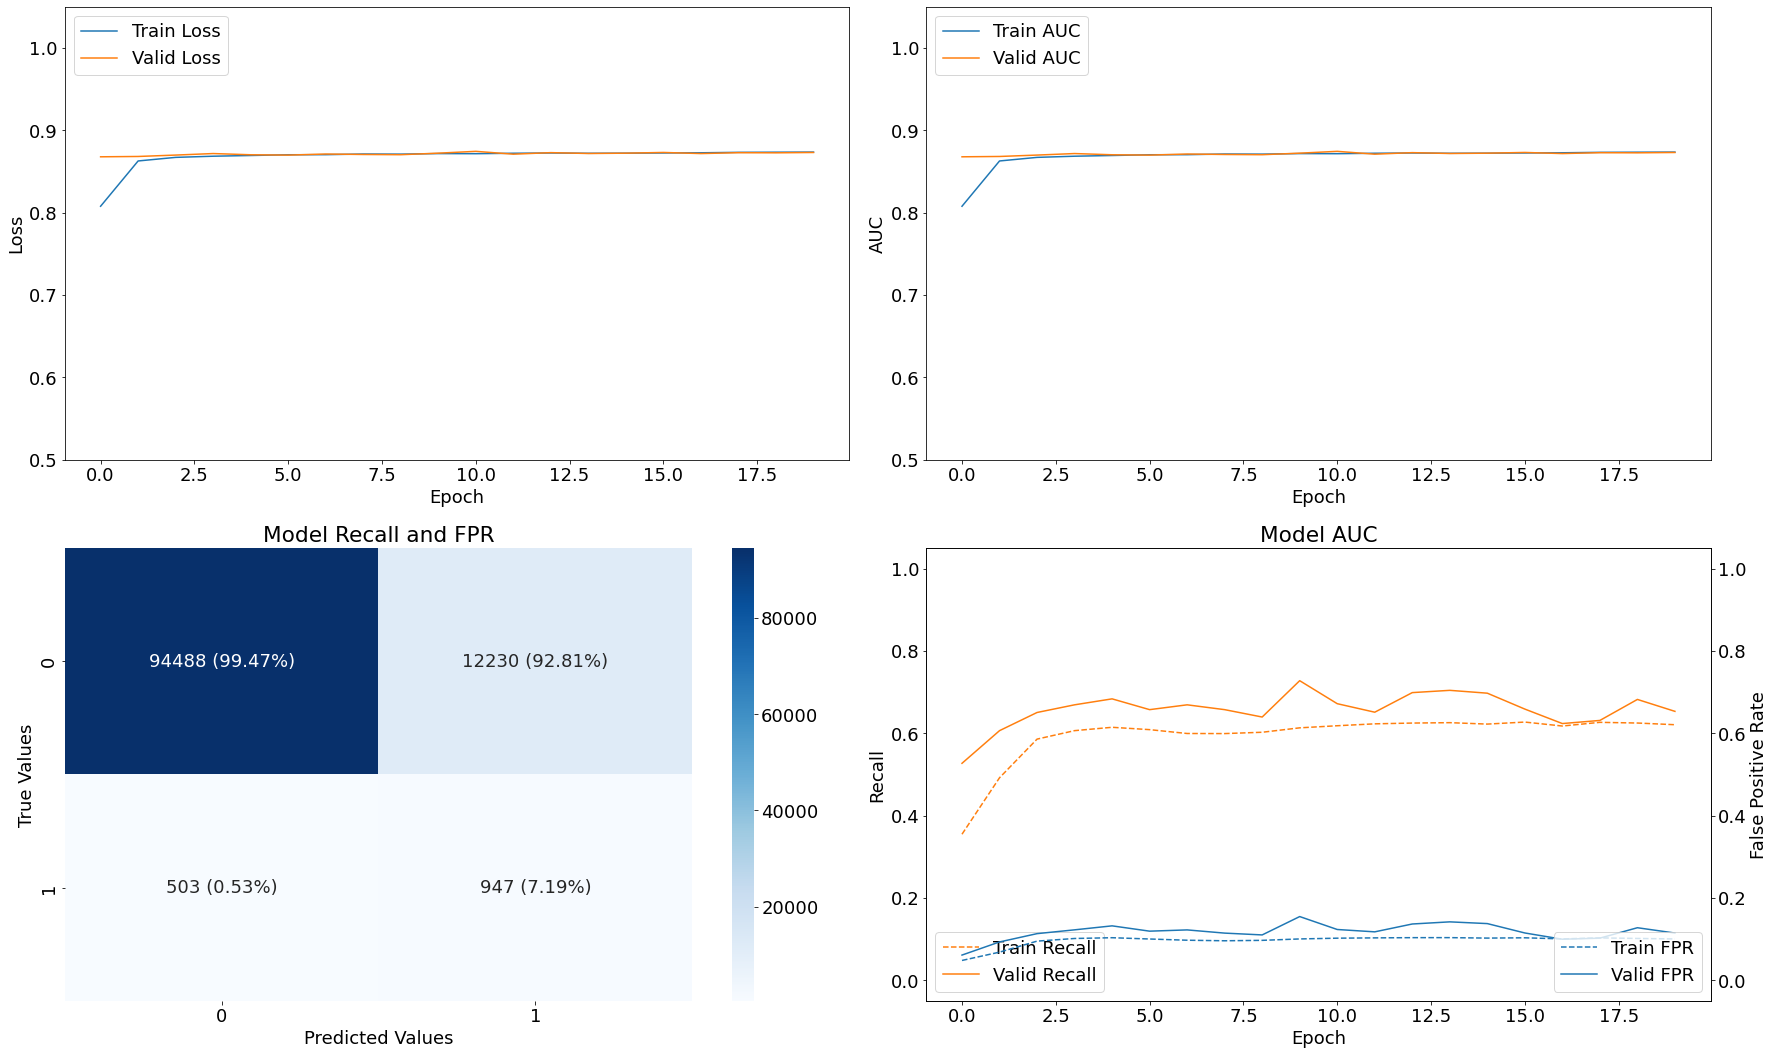

Results for model with threshold = 0.7.

 Train recall: 0.40859848260879517 
 Val Recall: 0.5372413992881775 

 Train FPR: 0.05383700504899025 
 Val FPR: 0.06311962008476257


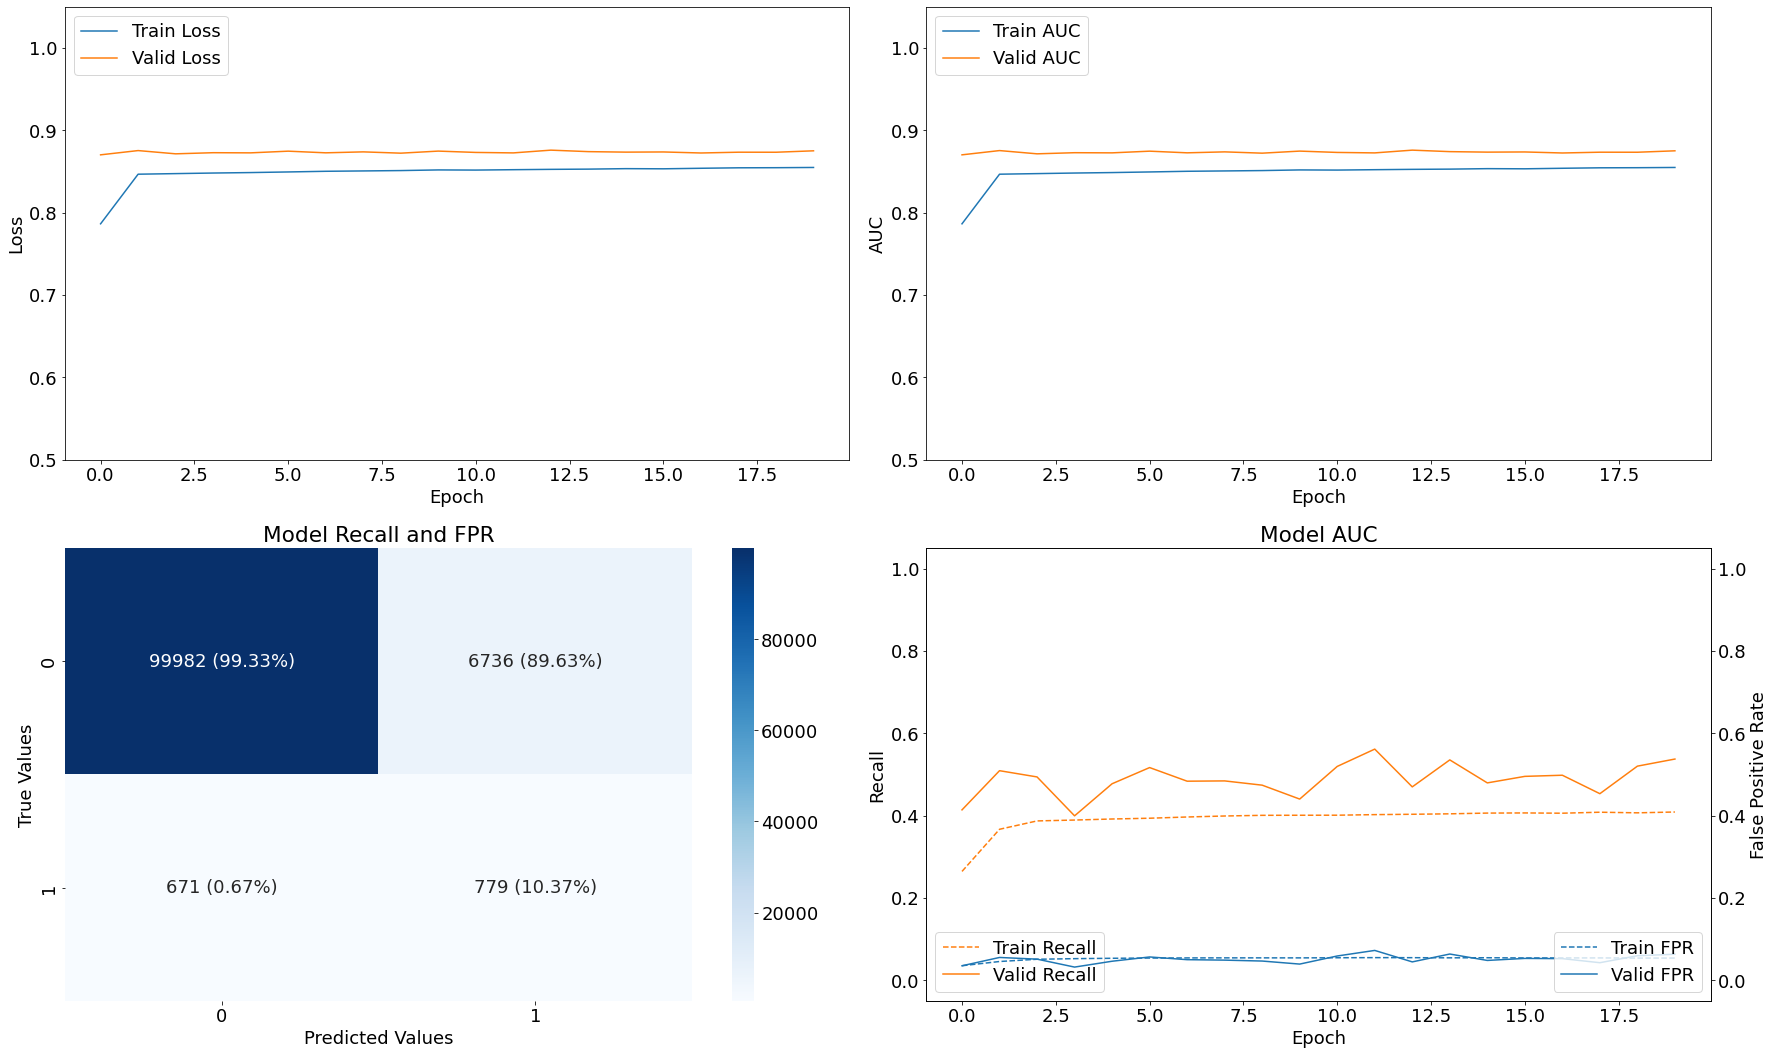

Results for model with threshold = 0.75.

 Train recall: 0.0 
 Val Recall: 0.0 

 Train FPR: 0.0 
 Val FPR: 0.0


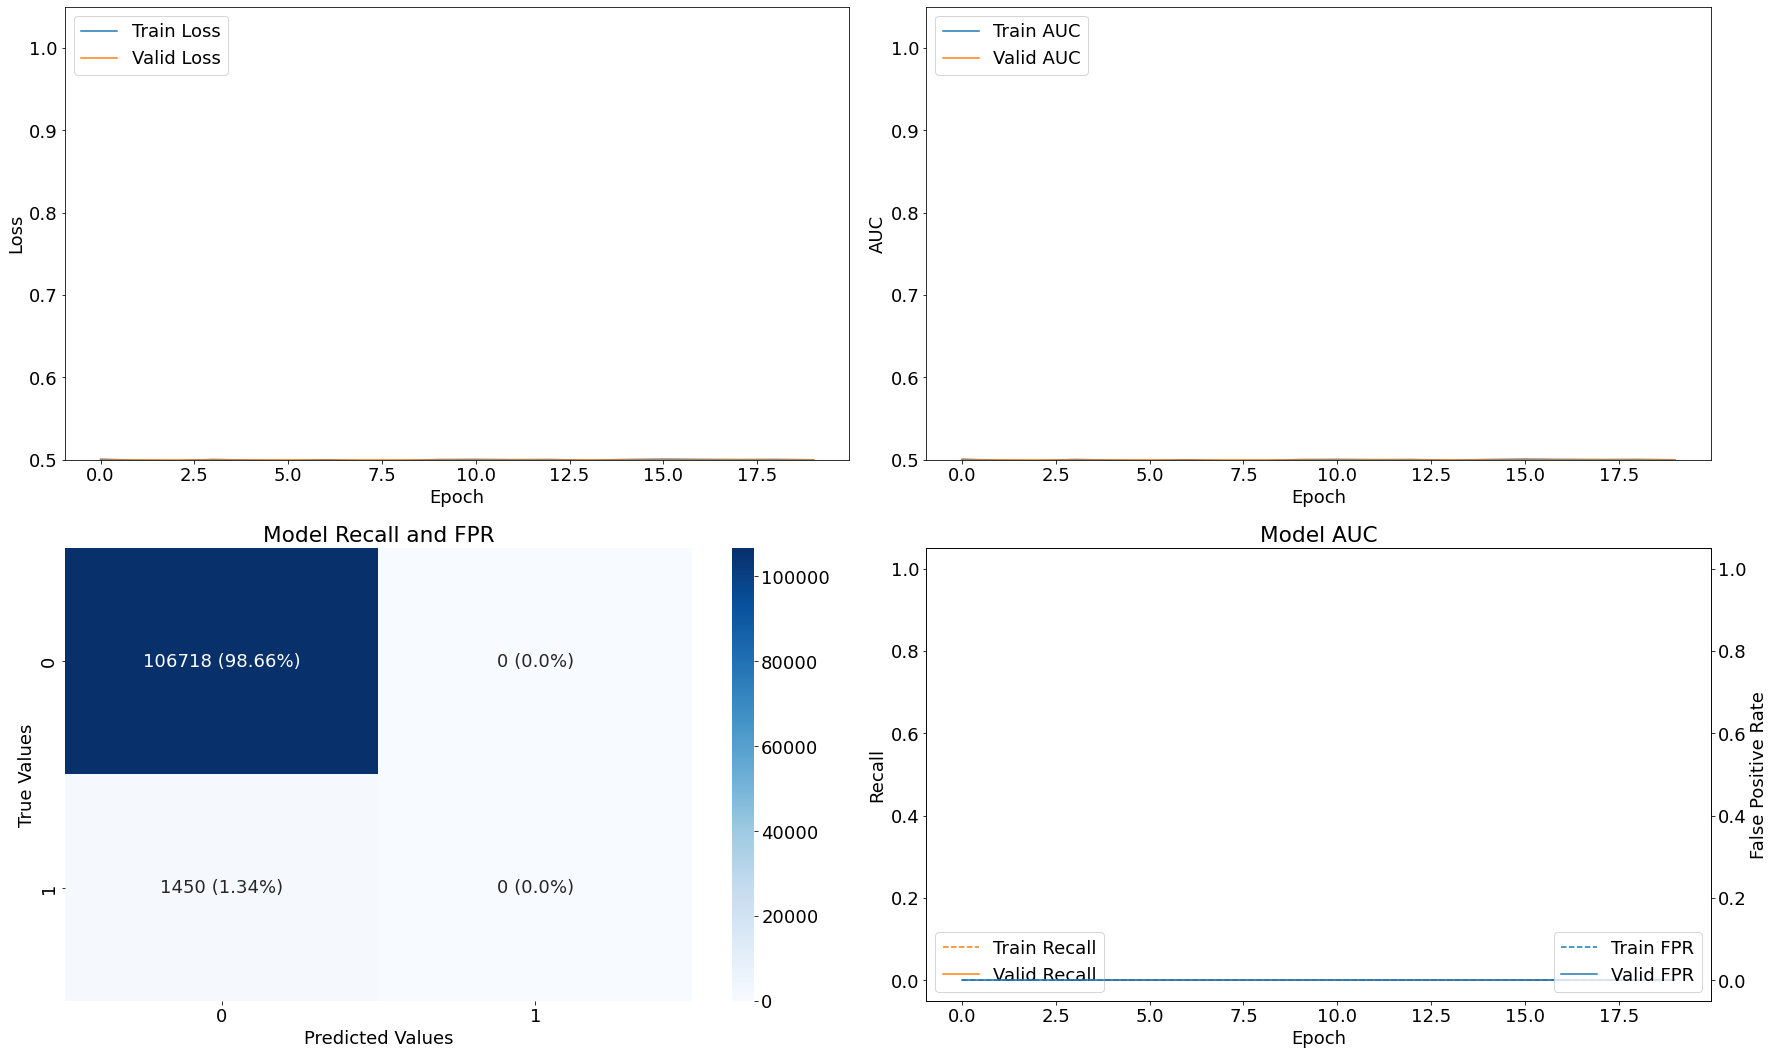

Results for model with threshold = 0.8.

 Train recall: 0.0 
 Val Recall: 0.0 

 Train FPR: 0.0 
 Val FPR: 0.0


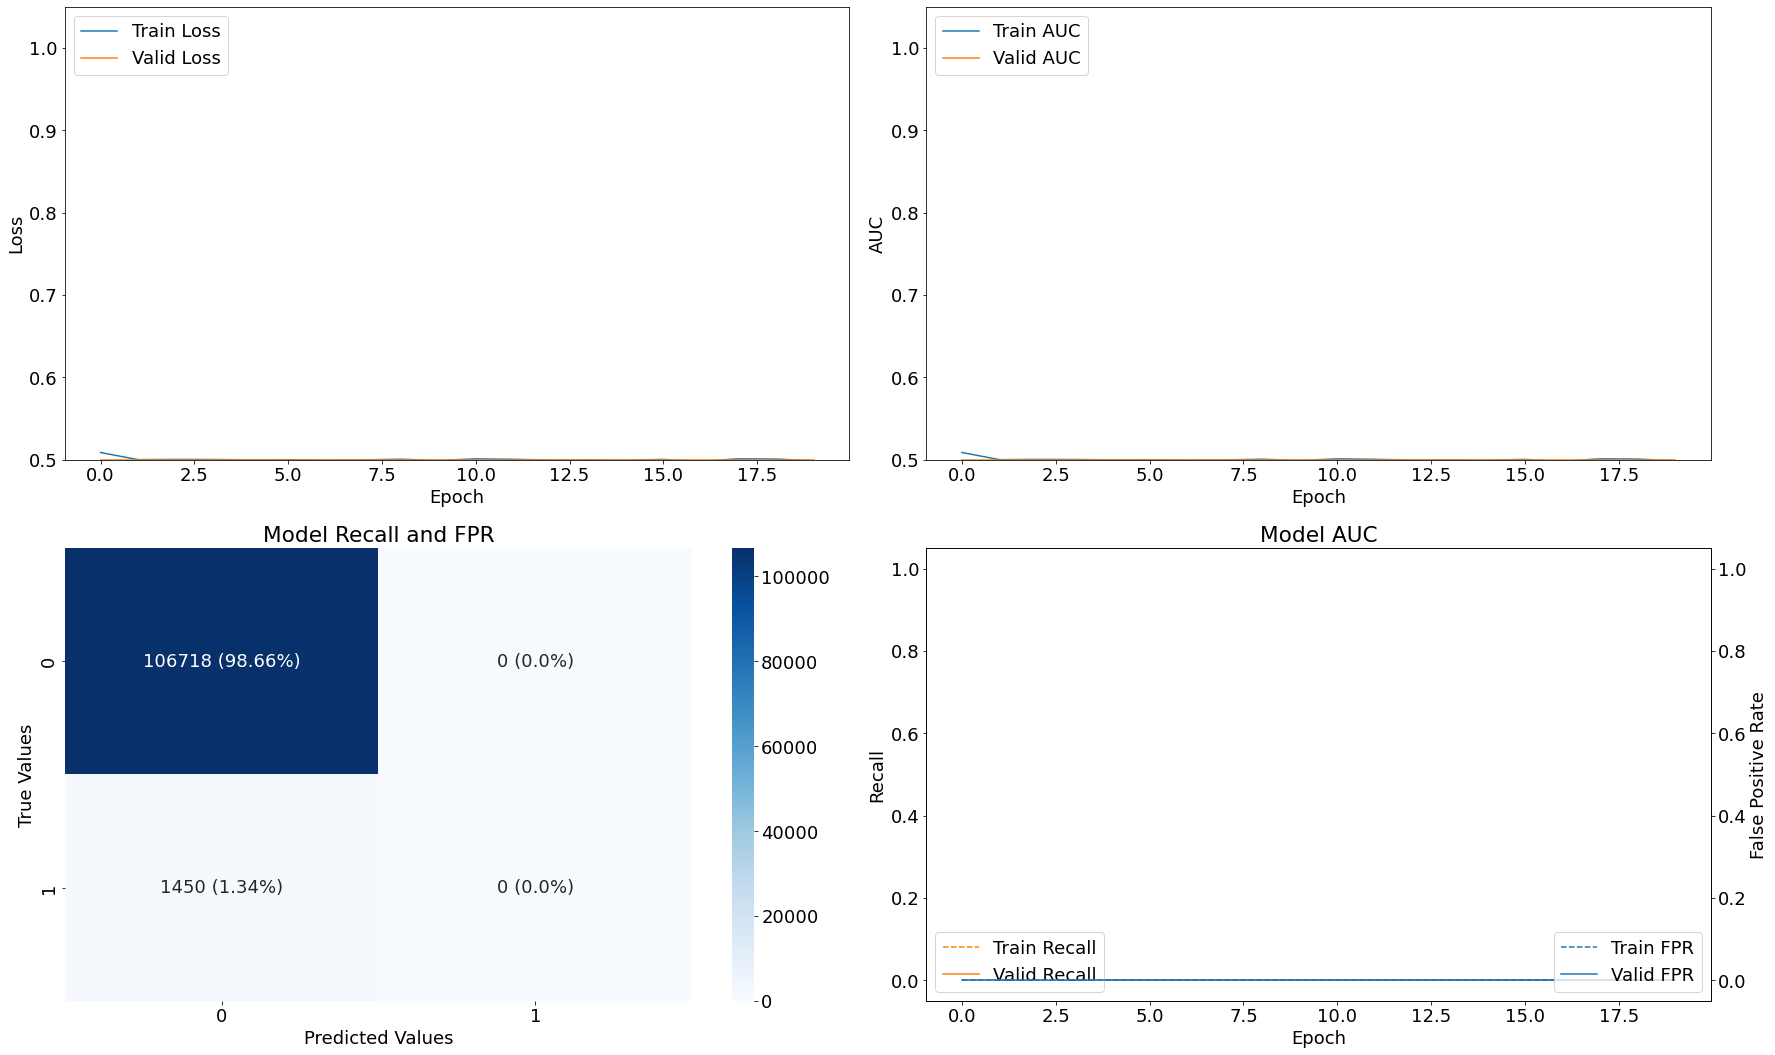

In [47]:
for t in thresholds:
    model_v7(threshold=t)

In [48]:
def model_v8(epochs=20, batch_size=512, threshold=0.5):    
    
    b_model_v8 = models.Sequential()

    b_model_v8.add(layers.Input(shape=(n_features, )))
    b_model_v8.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2()))
    b_model_v8.add(layers.Dropout(0.5))
    b_model_v8.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.L2()))
    b_model_v8.add(layers.Dropout(0.5))
    b_model_v8.add(layers.Dense(8, activation='relu', kernel_regularizer=regularizers.L2()))
    b_model_v8.add(layers.Dropout(0.5))
    b_model_v8.add(layers.Dense(4, activation='relu', kernel_regularizer=regularizers.L2()))
    b_model_v8.add(layers.Dense(2, activation='relu', kernel_regularizer=regularizers.L2()))
    b_model_v8.add(layers.Dense(1, activation='sigmoid'))

    b_model_v8.compile(optimizer='RMSprop',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_model_v8_history = b_model_v8.fit(X_train_scaled_resampled,
                                        y_train_resampled,
                                        batch_size=batch_size,
                                        validation_data=(X_val_scaled, y_val),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=0).history
    
    evaluate(b_model_v8, b_model_v8_history, X_val_scaled, y_val, threshold=threshold)

Results for model with threshold = 0.5.

 Train recall: 0.6515563726425171 
 Val Recall: 0.22620689868927002 

 Train FPR: 0.10641199350357056 
 Val FPR: 0.010654247365891933


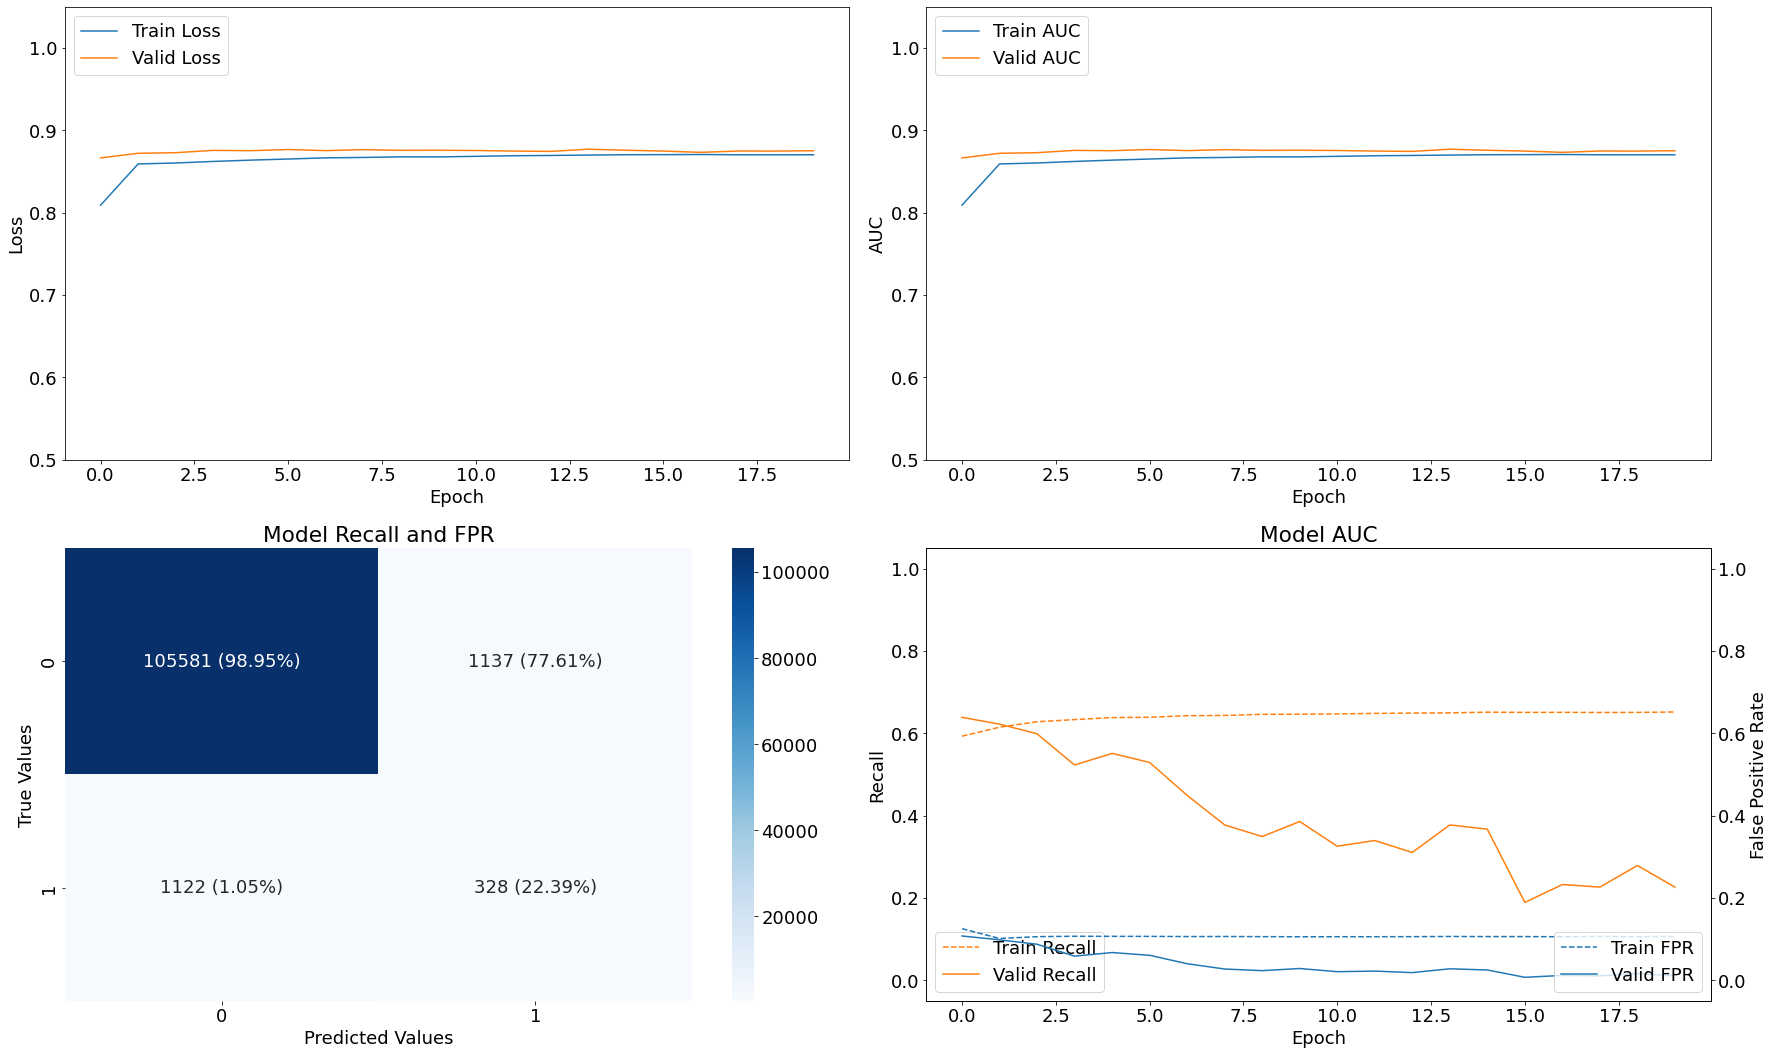

Results for model with threshold = 0.55.

 Train recall: 0.0 
 Val Recall: 0.0 

 Train FPR: 0.0 
 Val FPR: 0.0


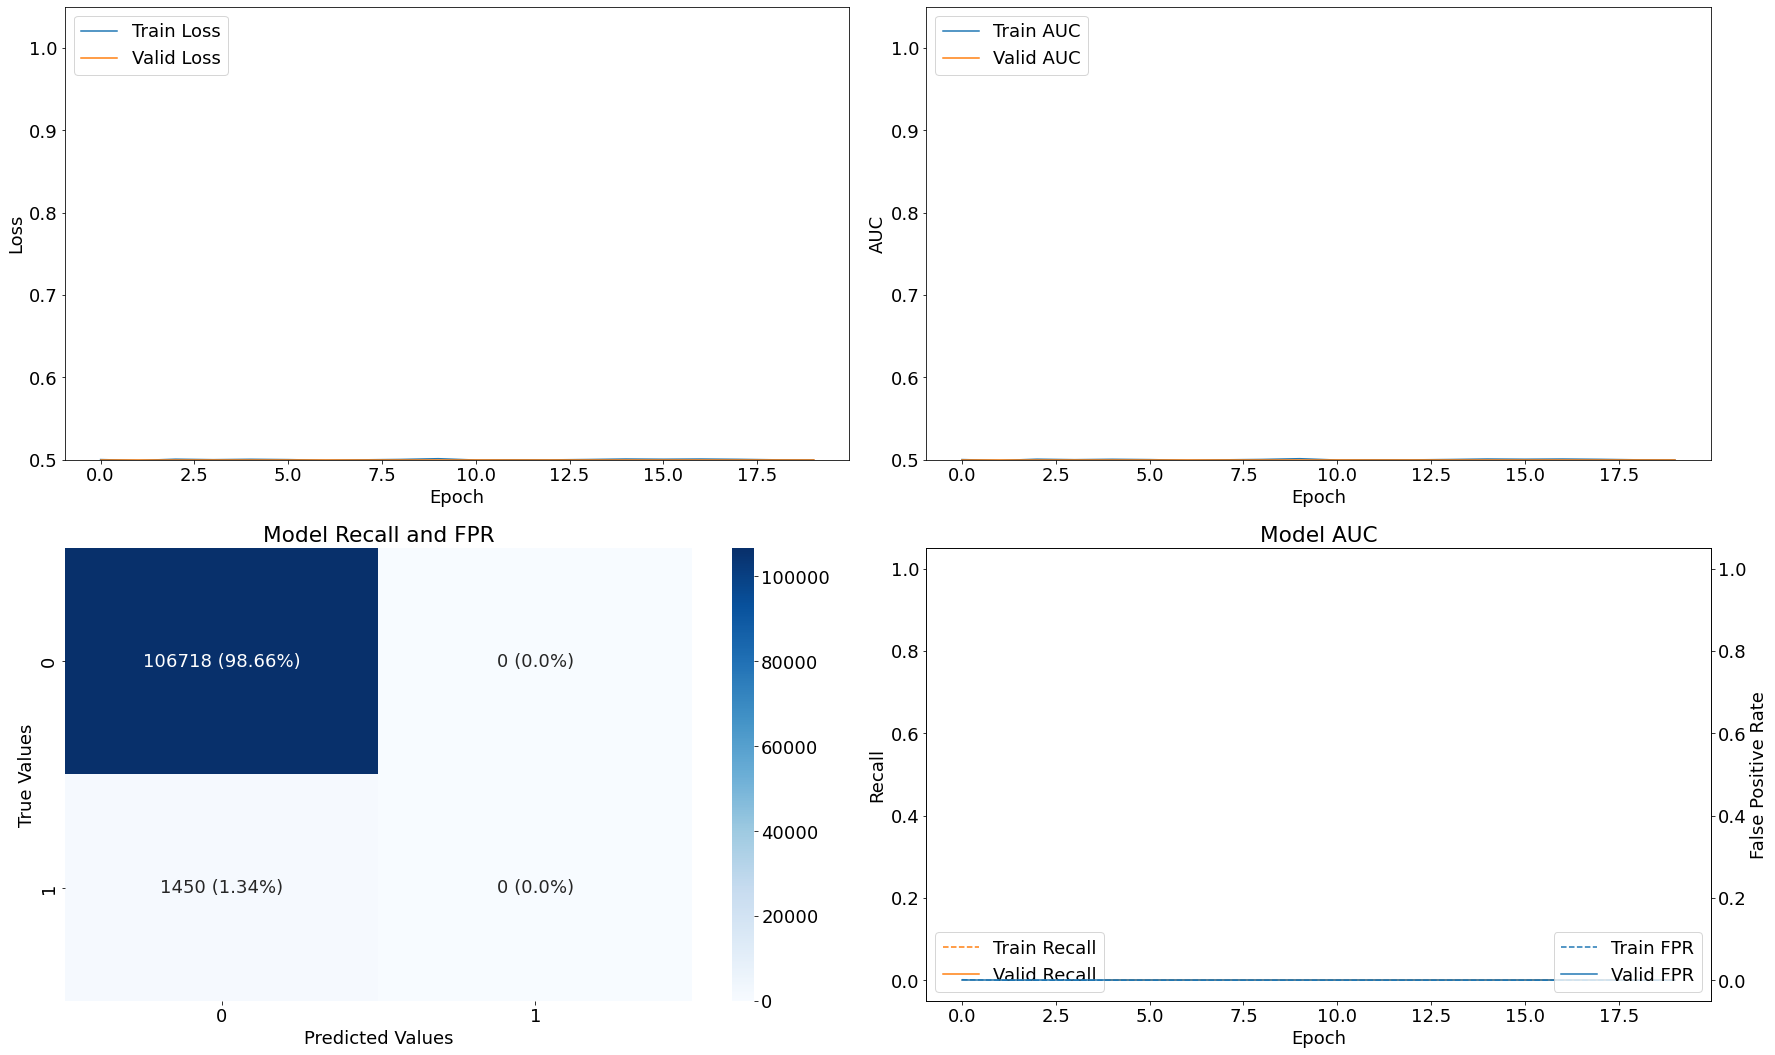

Results for model with threshold = 0.6.

 Train recall: 0.7685565948486328 
 Val Recall: 0.6379310488700867 

 Train FPR: 0.13664820790290833 
 Val FPR: 0.09945838898420334


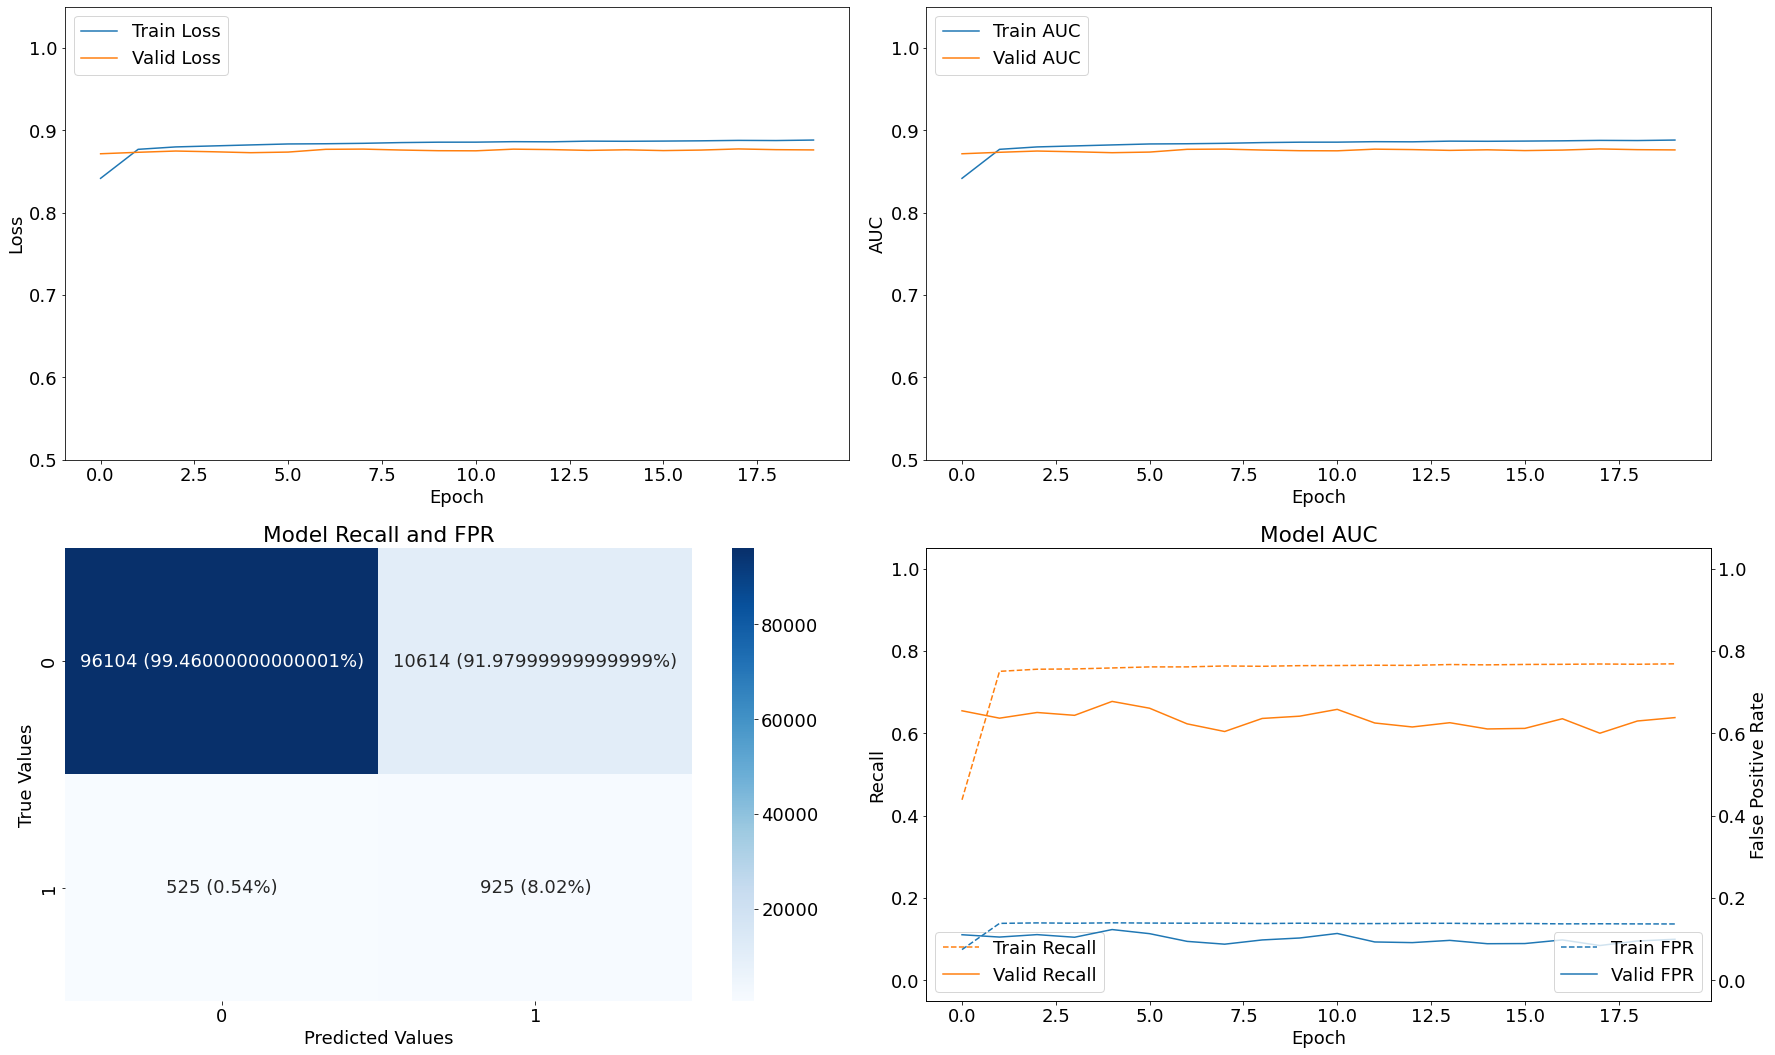

Results for model with threshold = 0.65.

 Train recall: 0.6212018728256226 
 Val Recall: 0.677931010723114 

 Train FPR: 0.09224770218133926 
 Val FPR: 0.12486178427934647


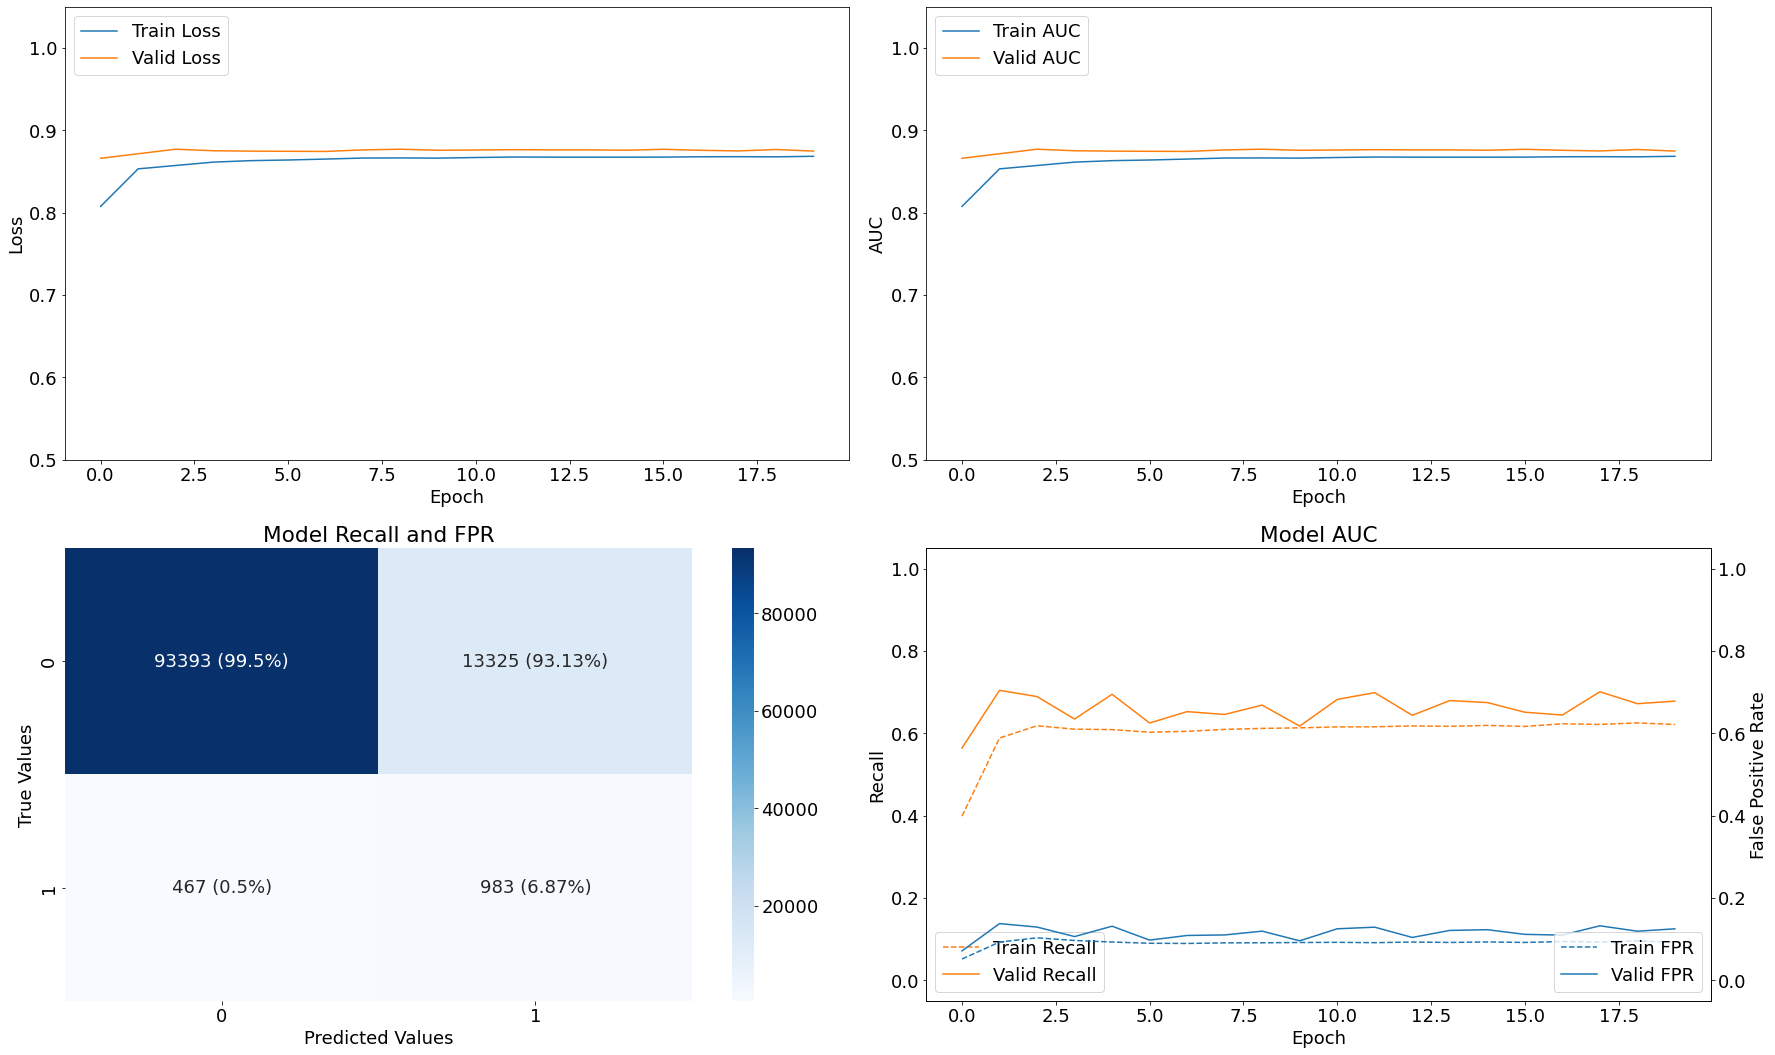

Results for model with threshold = 0.7.

 Train recall: 0.5857840776443481 
 Val Recall: 0.5986207127571106 

 Train FPR: 0.07314720749855042 
 Val FPR: 0.08300380408763885


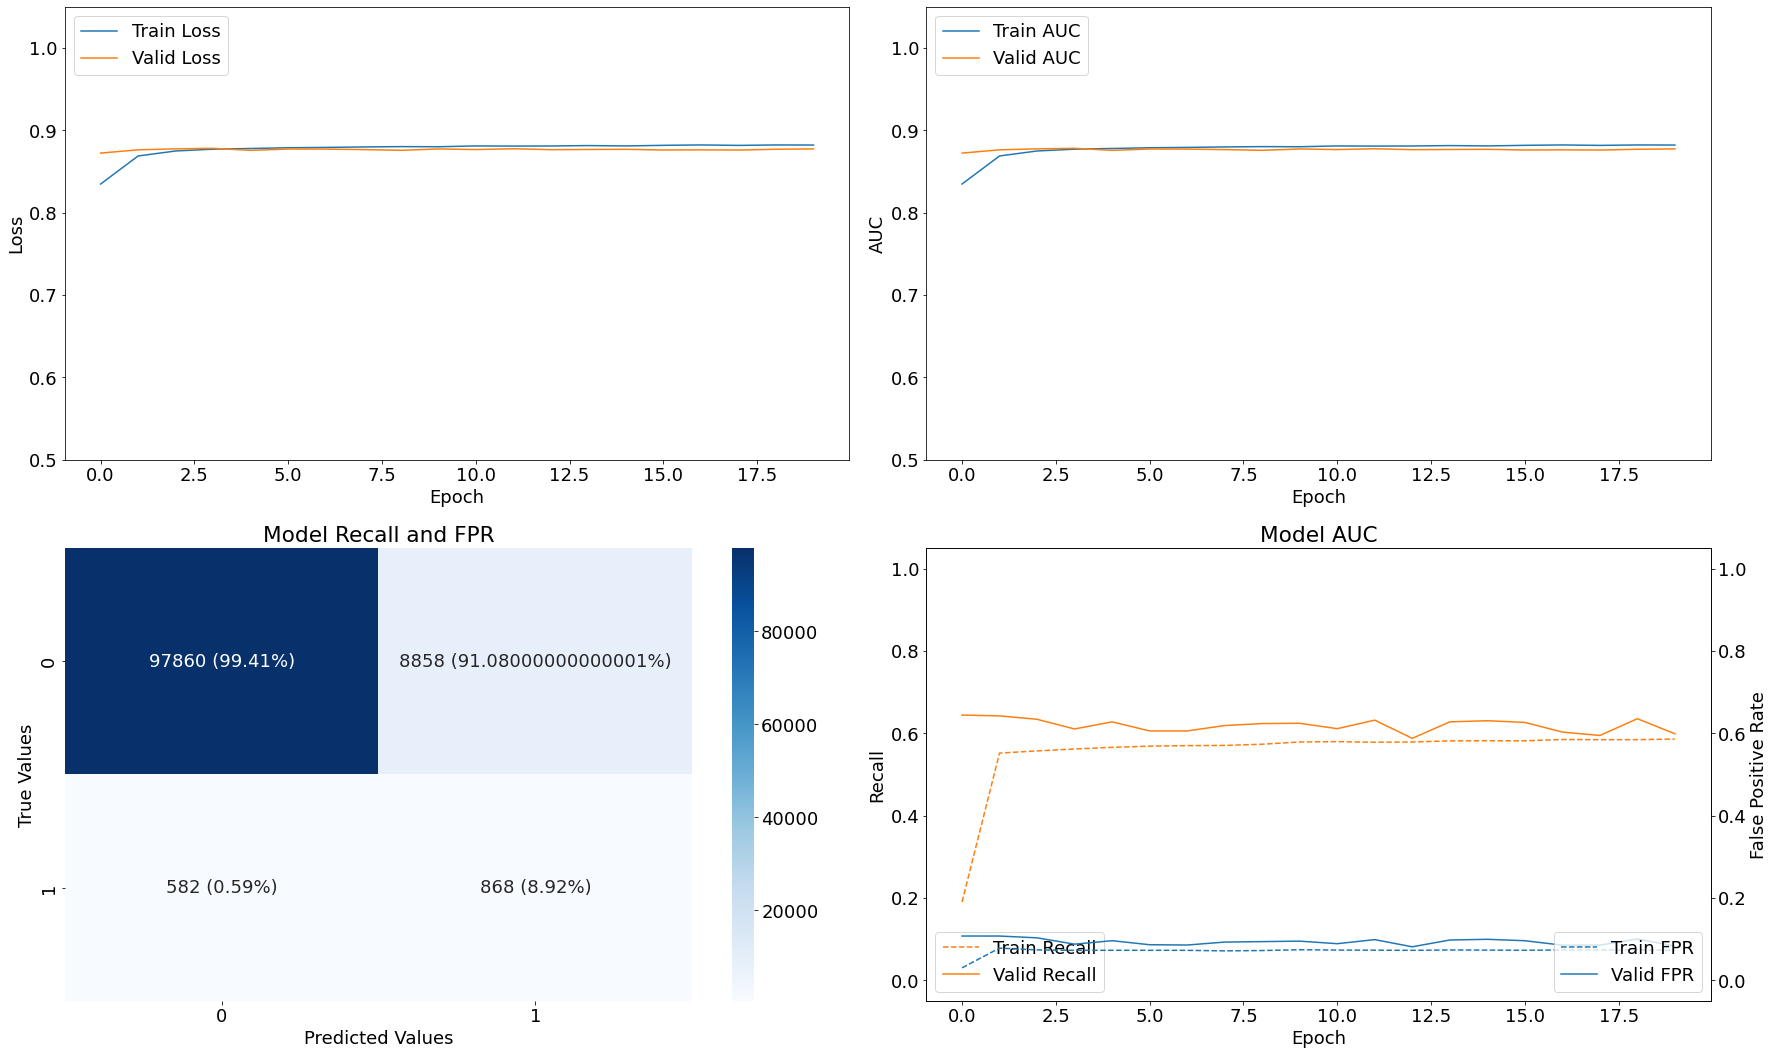

Results for model with threshold = 0.75.

 Train recall: 0.3855848014354706 
 Val Recall: 0.5193103551864624 

 Train FPR: 0.03654119372367859 
 Val FPR: 0.05482674017548561


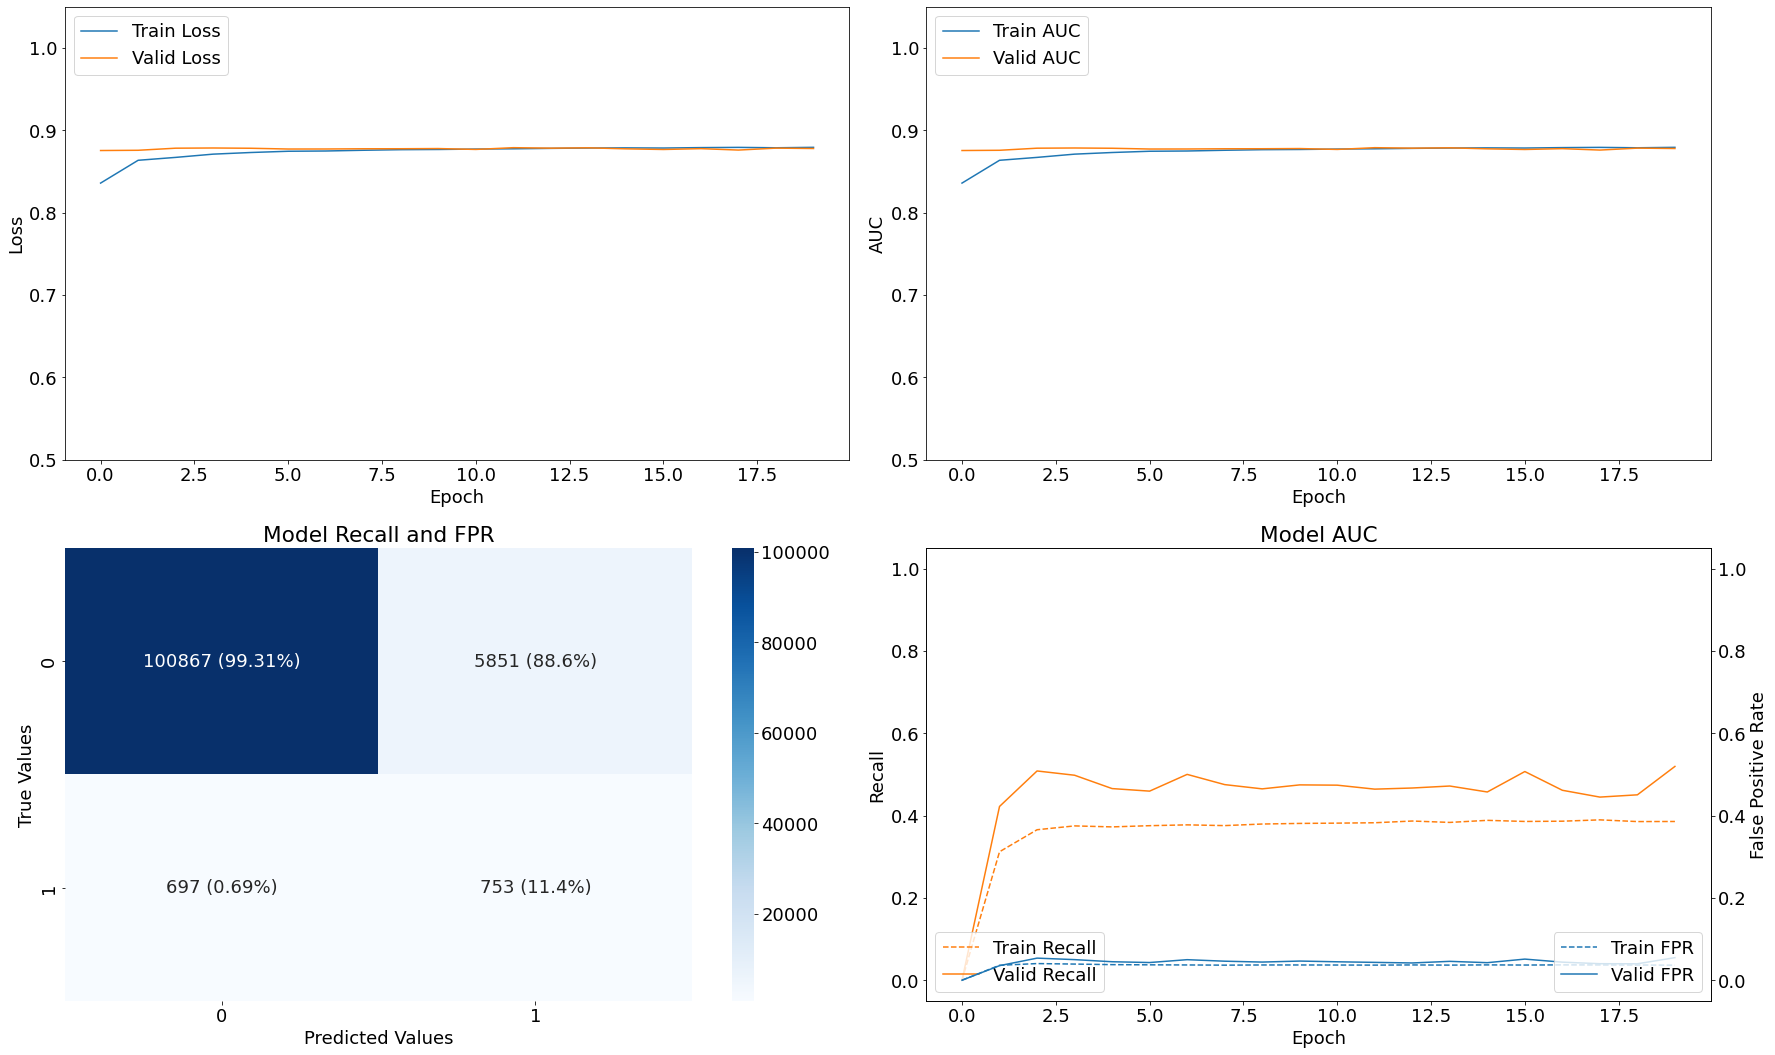

Results for model with threshold = 0.8.

 Train recall: 0.44397053122520447 
 Val Recall: 0.5675861835479736 

 Train FPR: 0.04866313189268112 
 Val FPR: 0.07164677232503891


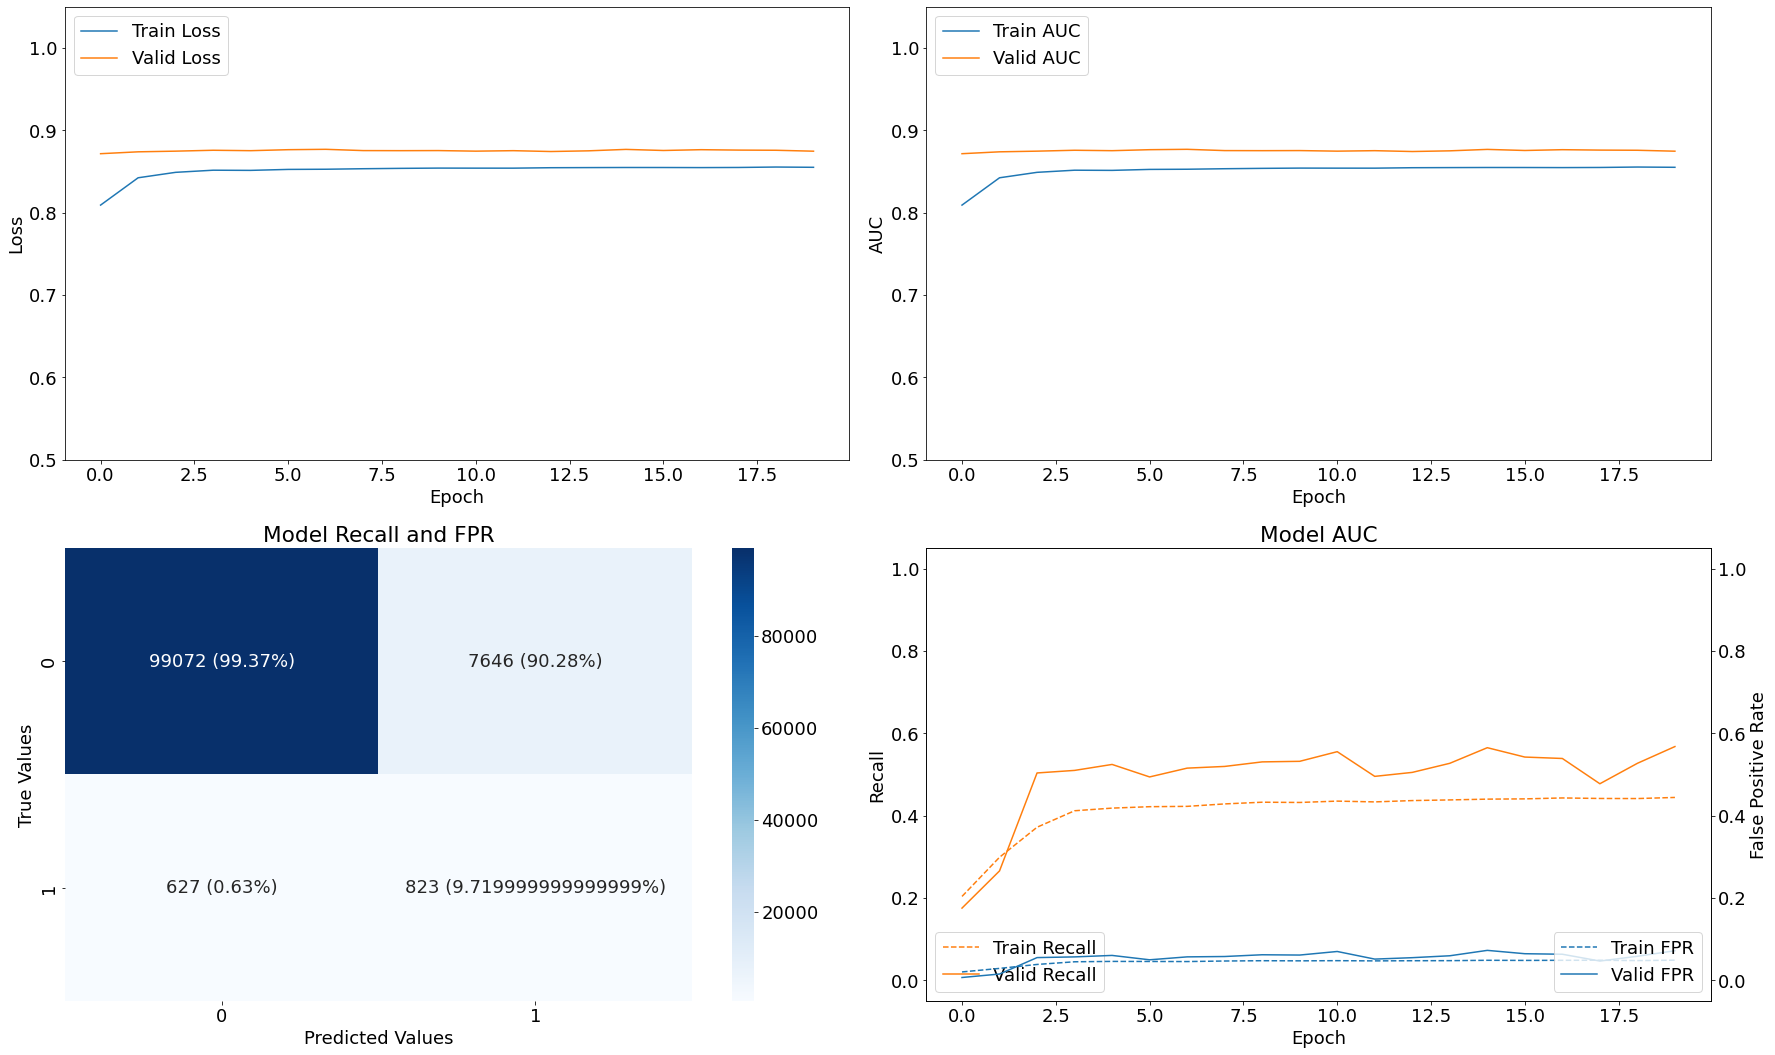

In [49]:
for t in thresholds:
    model_v8(threshold=t)

In [20]:
pf = PolynomialFeatures()

X_poly = pd.DataFrame(pf.fit_transform(X.drop('month',axis=1)))

In [21]:
X_poly = pd.concat([X_poly, X.month], axis=1)

In [22]:
X_poly.month.value_counts()

3    150936
2    136979
0    132440
4    127691
1    127620
5    119323
6    108168
7     96843
Name: month, dtype: int64

In [23]:
X_train_poly = X_poly.loc[X_poly.month < 6].drop('month', axis=1)
y_train = base.fraud_bool.loc[base.month < 6]

X_train_poly.shape, y_train.shape

((794989, 1953), (794989,))

In [24]:
X_val_poly = X_poly.loc[X_poly.month == 6].drop('month', axis=1)
y_val_poly = base.fraud_bool.loc[base.month == 6]

X_val_poly.shape, y_val.shape

((108168, 1953), (108168,))

In [25]:
X_test_poly = X_poly.loc[X_poly.month == 7].drop('month', axis=1)
y_test = base.fraud_bool.loc[base.month == 7]

X_test_poly.shape, y_test.shape

((96843, 1953), (96843,))

In [26]:
ss = StandardScaler()

X_train_poly_scaled = ss.fit_transform(X_train_poly)
X_val_poly_scaled = ss.transform(X_val_poly)
X_test_poly_scaled = ss.transform(X_test_poly)

In [27]:
n_features_poly = X_train_poly_scaled.shape[1]

In [28]:
X_train_poly_scaled_resampled, y_train_resampled = \
SMOTE(random_state=21, sampling_strategy=0.25).fit_resample(X_train_poly_scaled,y_train)

In [29]:
def poly_model_v1(X_train, y_train, X_val, y_val, epochs=20, batch_size=512, threshold=0.5):
    
    b_poly_model_v1 = models.Sequential()

    b_poly_model_v1.add(layers.Input(shape=(n_features_poly, )))
    b_poly_model_v1.add(layers.Dense(1024, activation='relu'))
    b_poly_model_v1.add(layers.Dropout(0.5))
    b_poly_model_v1.add(layers.Dense(512, activation='relu'))
    b_poly_model_v1.add(layers.Dropout(0.5))
    b_poly_model_v1.add(layers.Dense(1, activation='sigmoid'))

    b_poly_model_v1.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_poly_model_v1_history = b_poly_model_v1.fit(X_train,
                                        y_train,
                                        batch_size=batch_size,
                                        validation_data=(X_val, y_val),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=1).history
    
    evaluate(b_poly_model_v1, b_poly_model_v1_history, X_val, y_val, threshold=threshold)

Epoch 1/20
1921/1921 [==============================] - 33s 17ms/step - loss: 0.4328 - auc: 0.9334 - recall: 0.8307 - false_positive_rate: 0.1187 - val_loss: 0.1857 - val_auc: 0.8552 - val_recall: 0.5490 - val_false_positive_rate: 0.0766
Epoch 2/20
1921/1921 [==============================] - 32s 17ms/step - loss: 0.3134 - auc: 0.9644 - recall: 0.8954 - false_positive_rate: 0.0896 - val_loss: 0.1771 - val_auc: 0.8396 - val_recall: 0.4910 - val_false_positive_rate: 0.0677
Epoch 3/20
1921/1921 [==============================] - 32s 16ms/step - loss: 0.2478 - auc: 0.9771 - recall: 0.9263 - false_positive_rate: 0.0722 - val_loss: 0.1707 - val_auc: 0.8246 - val_recall: 0.4469 - val_false_positive_rate: 0.0550
Epoch 4/20
1921/1921 [==============================] - 32s 17ms/step - loss: 0.2062 - auc: 0.9835 - recall: 0.9433 - false_positive_rate: 0.0605 - val_loss: 0.1775 - val_auc: 0.8110 - val_recall: 0.4069 - val_false_positive_rate: 0.0465
Epoch 5/20
1921/1921 [==========================

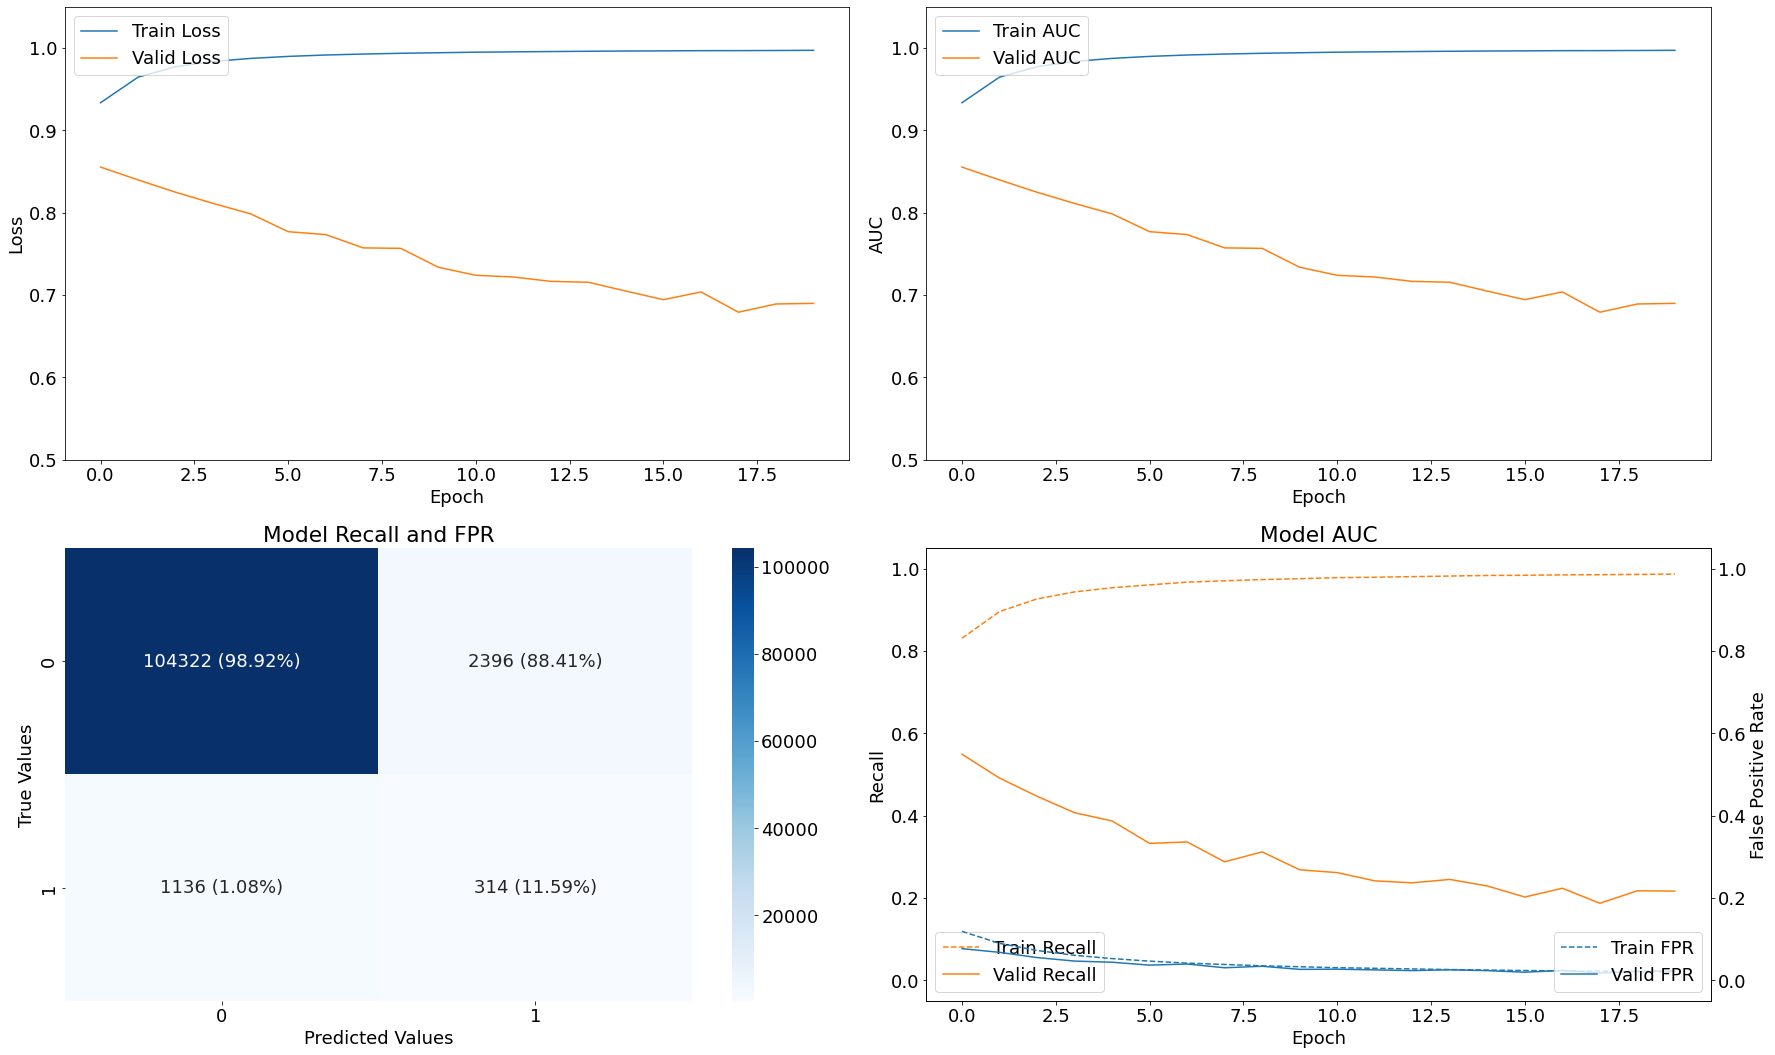

In [30]:
poly_model_v1(X_train_poly_scaled_resampled, y_train_resampled, X_val_poly_scaled, y_val)

In [31]:
def poly_model_v2(X_train, y_train, X_val, y_val, epochs=20, batch_size=512, threshold=0.5):
    
    b_poly_model_v2 = models.Sequential()

    b_poly_model_v2.add(layers.Input(shape=(n_features_poly, )))
    b_poly_model_v2.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.L2()))
    b_poly_model_v2.add(layers.Dropout(0.5))
    b_poly_model_v2.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L2()))
    b_poly_model_v2.add(layers.Dropout(0.5))
    b_poly_model_v2.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.L2()))

    b_poly_model_v2.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_poly_model_v2_history = b_poly_model_v2.fit(X_train,
                                        y_train,
                                        batch_size=batch_size,
                                        validation_data=(X_val, y_val),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=1).history
    
    evaluate(b_poly_model_v2, b_poly_model_v2_history, X_val, y_val, threshold=threshold)

Epoch 1/20
1921/1921 [==============================] - 40s 21ms/step - loss: 0.9738 - auc: 0.9000 - recall_1: 0.7778 - false_positive_rate: 0.1429 - val_loss: 0.4255 - val_auc: 0.8713 - val_recall_1: 0.7062 - val_false_positive_rate: 0.1398
Epoch 2/20
1921/1921 [==============================] - 38s 20ms/step - loss: 0.6175 - auc: 0.9024 - recall_1: 0.7790 - false_positive_rate: 0.1402 - val_loss: 0.3835 - val_auc: 0.8709 - val_recall_1: 0.6855 - val_false_positive_rate: 0.1281
Epoch 3/20
1921/1921 [==============================] - 38s 20ms/step - loss: 0.6093 - auc: 0.9031 - recall_1: 0.7793 - false_positive_rate: 0.1390 - val_loss: 0.4373 - val_auc: 0.8680 - val_recall_1: 0.7324 - val_false_positive_rate: 0.1623
Epoch 4/20
1921/1921 [==============================] - 38s 20ms/step - loss: 0.6061 - auc: 0.9033 - recall_1: 0.7813 - false_positive_rate: 0.1389 - val_loss: 0.3767 - val_auc: 0.8735 - val_recall_1: 0.6800 - val_false_positive_rate: 0.1254
Epoch 5/20
1921/1921 [==========

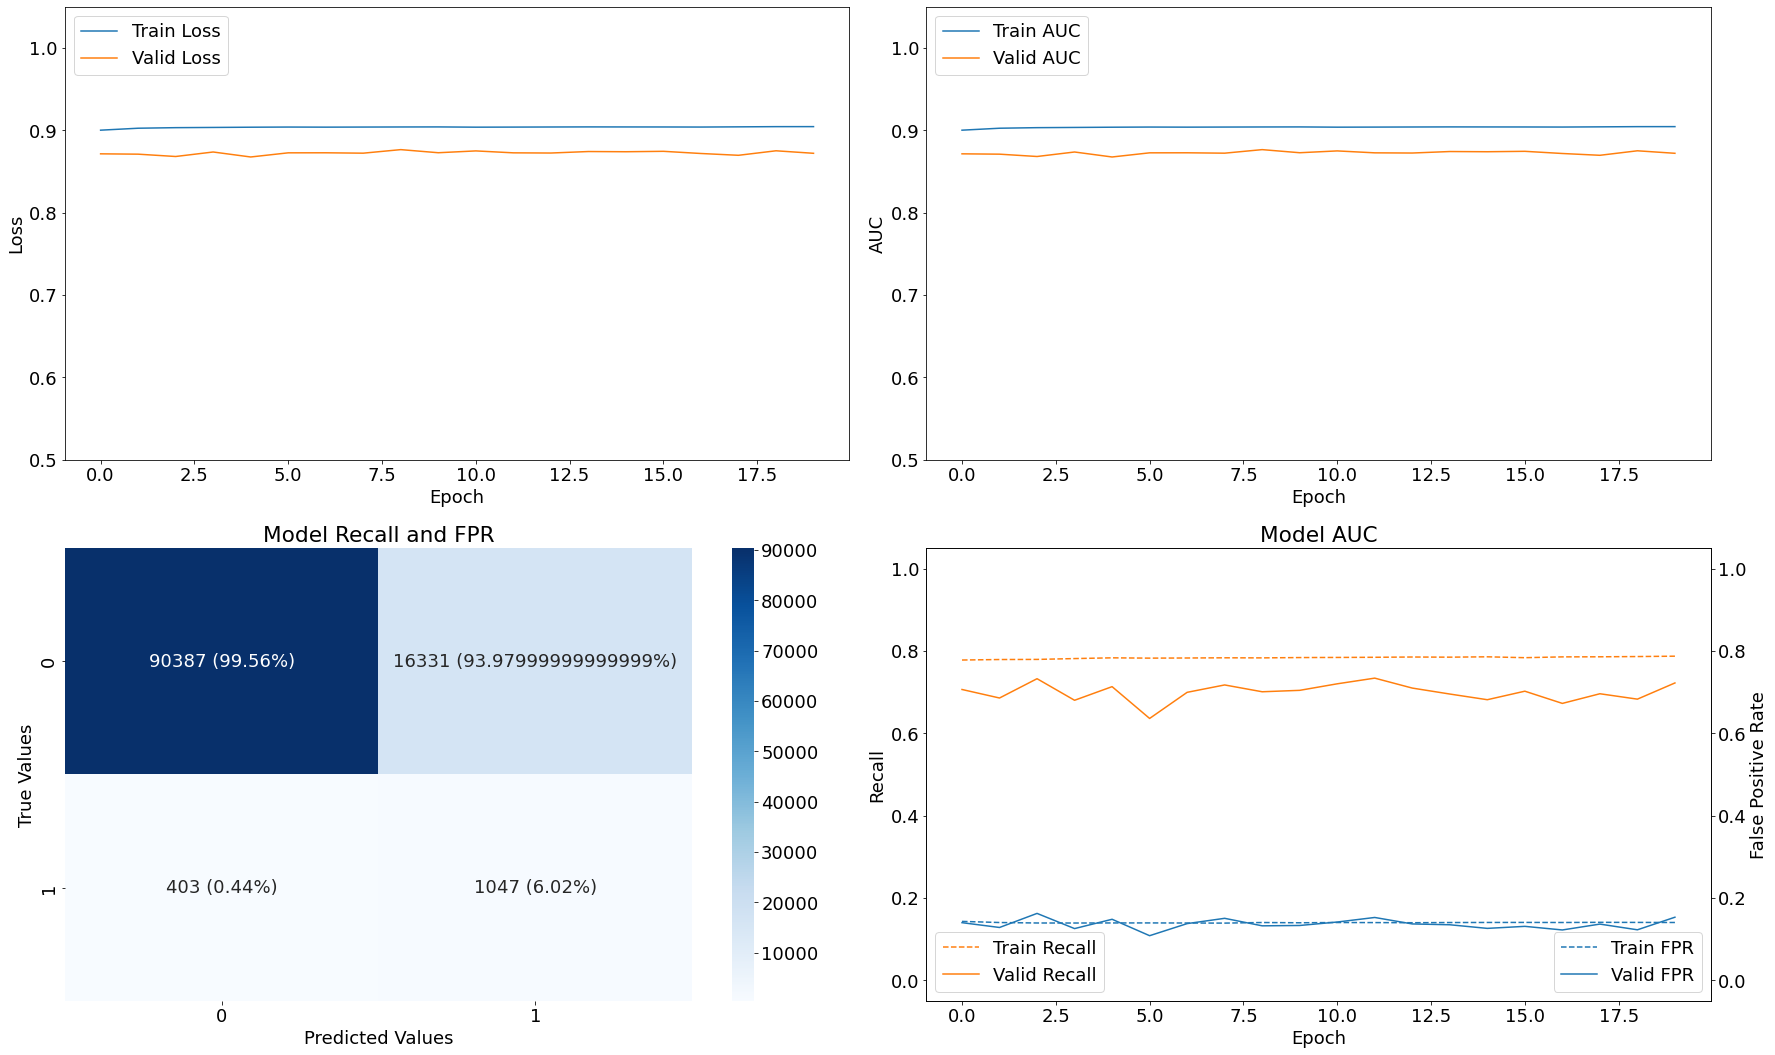

In [32]:
poly_model_v2(X_train_poly_scaled_resampled, y_train_resampled, X_val_poly_scaled, y_val)

In [33]:
cross_numeric_features = pd.DataFrame(np.zeros([len(X), ]), columns=["0"])

for feature in numeric_features:
    for second_feature in numeric_features:
        feature_name = feature + "/" + second_feature
        if feature_name not in numeric_features.columns:
            cross_numeric_features[feature_name] =\
            numeric_features[feature] * numeric_features[second_feature]

In [34]:
cross_features = pd.concat([numeric_features,
                           cross_numeric_features.drop('0',
                                                       axis=1)],
                           axis=1)

In [35]:
X_cross = pd.concat([cross_features, binary_encoded, cat_encoded], axis=1)

In [36]:
i=0
for column in X_cross:
    X_cross.rename(columns={column:f'feature{i}'}, inplace=True)
    i+=1
    
X_cross = pd.concat([X_cross, base.month], axis=1)

X_cross.head()

feature0  feature1  feature2  feature3  feature4  feature5      feature6  \
0  0.166828        -1        88  0.020925 -1.331345       769  10650.765523   
1  0.296286        -1       144  0.005418 -0.816224       366    534.047319   
2  0.044985        -1       132  3.108549 -0.755728       870   4048.534263   
3  0.159511        -1        22  0.019079 -1.205124       810   3457.064063   
4  0.596414        -1       218  0.004441 -0.773276       890   5020.341679   

      feature7     feature8  feature9  ...  feature277  feature278  \
0  3134.319630  3863.647740         1  ...         0.0         0.0   
1  2670.918292  3124.298166       718  ...         0.0         0.0   
2  2893.621498  3159.590679         1  ...         0.0         0.0   
3  4054.908412  3022.261812      1921  ...         1.0         0.0   
4  2728.237159  3087.670952      1990  ...         0.0         1.0   

   feature279  feature280  feature281  feature282  feature283  feature284  \
0         0.0         1.0         0.0         0.0         0.0         1.0   
1         0.0         1.0         0.0         0.0         0.0         1.0   
2         1.0         0.0         0.0         0.0         0.0         1.0   
3         0.0         0.0         0.0         0.0         0.0         1.0   
4         0.0         0.0         0.0         0.0         0.0         1.0   

   feature285  month  
0         0.0      7  
1         0.0      7  
2         0.0      7  
3         0.0      7  
4         0.0      7  

[5 rows x 287 columns]

In [37]:
Xc_train = X_cross.loc[X_cross.month < 6].drop('month', axis=1)
y_train = base.fraud_bool.loc[base.month < 6]

Xc_train.shape, y_train.shape

((794989, 286), (794989,))

In [38]:
Xc_val = X_cross.loc[X_cross.month == 6].drop('month', axis=1)
y_val = base.fraud_bool.loc[base.month == 6]

Xc_val.shape, y_val.shape

((108168, 286), (108168,))

In [39]:
Xc_test = X_cross.loc[X_cross.month == 7].drop('month', axis=1)
y_test = base.fraud_bool.loc[base.month == 7]

Xc_test.shape, y_test.shape

((96843, 286), (96843,))

In [40]:
ss = StandardScaler()

Xc_train_scaled = ss.fit_transform(Xc_train)
Xc_val_scaled = ss.transform(Xc_val)
Xc_test_scaled = ss.transform(Xc_test)

In [41]:
cross_n_features = Xc_train_scaled.shape[1]

In [42]:
Xc_train_scaled_resampled, y_train_resampled = \
SMOTE(random_state=21,sampling_strategy=0.25).fit_resample(Xc_train_scaled,y_train)

In [43]:
Xc_train_scaled_resampled.shape

(983547, 286)

In [44]:
def cross_model_v1(X_train, y_train, X_val, y_val, epochs=20, batch_size=512, threshold=0.5):
    
    b_cross_model_v1 = models.Sequential()

    b_cross_model_v1.add(layers.Input(shape=(cross_n_features, )))
    b_cross_model_v1.add(layers.Dense(128, activation='relu'))
    b_cross_model_v1.add(layers.Dropout(0.5))
    b_cross_model_v1.add(layers.Dense(64, activation='relu'))
    b_cross_model_v1.add(layers.Dropout(0.5))
    b_cross_model_v1.add(layers.Dense(1, activation='sigmoid'))

    b_cross_model_v1.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_cross_model_v1_history = b_cross_model_v1.fit(X_train,
                                        y_train,
                                        batch_size=batch_size,
                                        validation_data=(X_val, y_val),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=1).history
    
    evaluate(b_cross_model_v1, b_cross_model_v1_history, X_val, y_val, threshold=threshold)

In [45]:
class_weight = create_class_weight({0: sum(y_train == 0), 1: sum(y_train == 1)}, mu=0.15)

Epoch 1/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.5129 - auc: 0.9055 - recall_2: 0.7812 - false_positive_rate: 0.1347 - val_loss: 0.2539 - val_auc: 0.8810 - val_recall_2: 0.6379 - val_false_positive_rate: 0.0967
Epoch 2/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.4457 - auc: 0.9291 - recall_2: 0.8156 - false_positive_rate: 0.1139 - val_loss: 0.2638 - val_auc: 0.8774 - val_recall_2: 0.6490 - val_false_positive_rate: 0.1038
Epoch 3/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.4114 - auc: 0.9396 - recall_2: 0.8354 - false_positive_rate: 0.1051 - val_loss: 0.2007 - val_auc: 0.8770 - val_recall_2: 0.5614 - val_false_positive_rate: 0.0725
Epoch 4/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.3883 - auc: 0.9461 - recall_2: 0.8494 - false_positive_rate: 0.1007 - val_loss: 0.2133 - val_auc: 0.8718 - val_recall_2: 0.5628 - val_false_positive_rate: 0.0781
Epoch 5/20
1921/1921 [==================

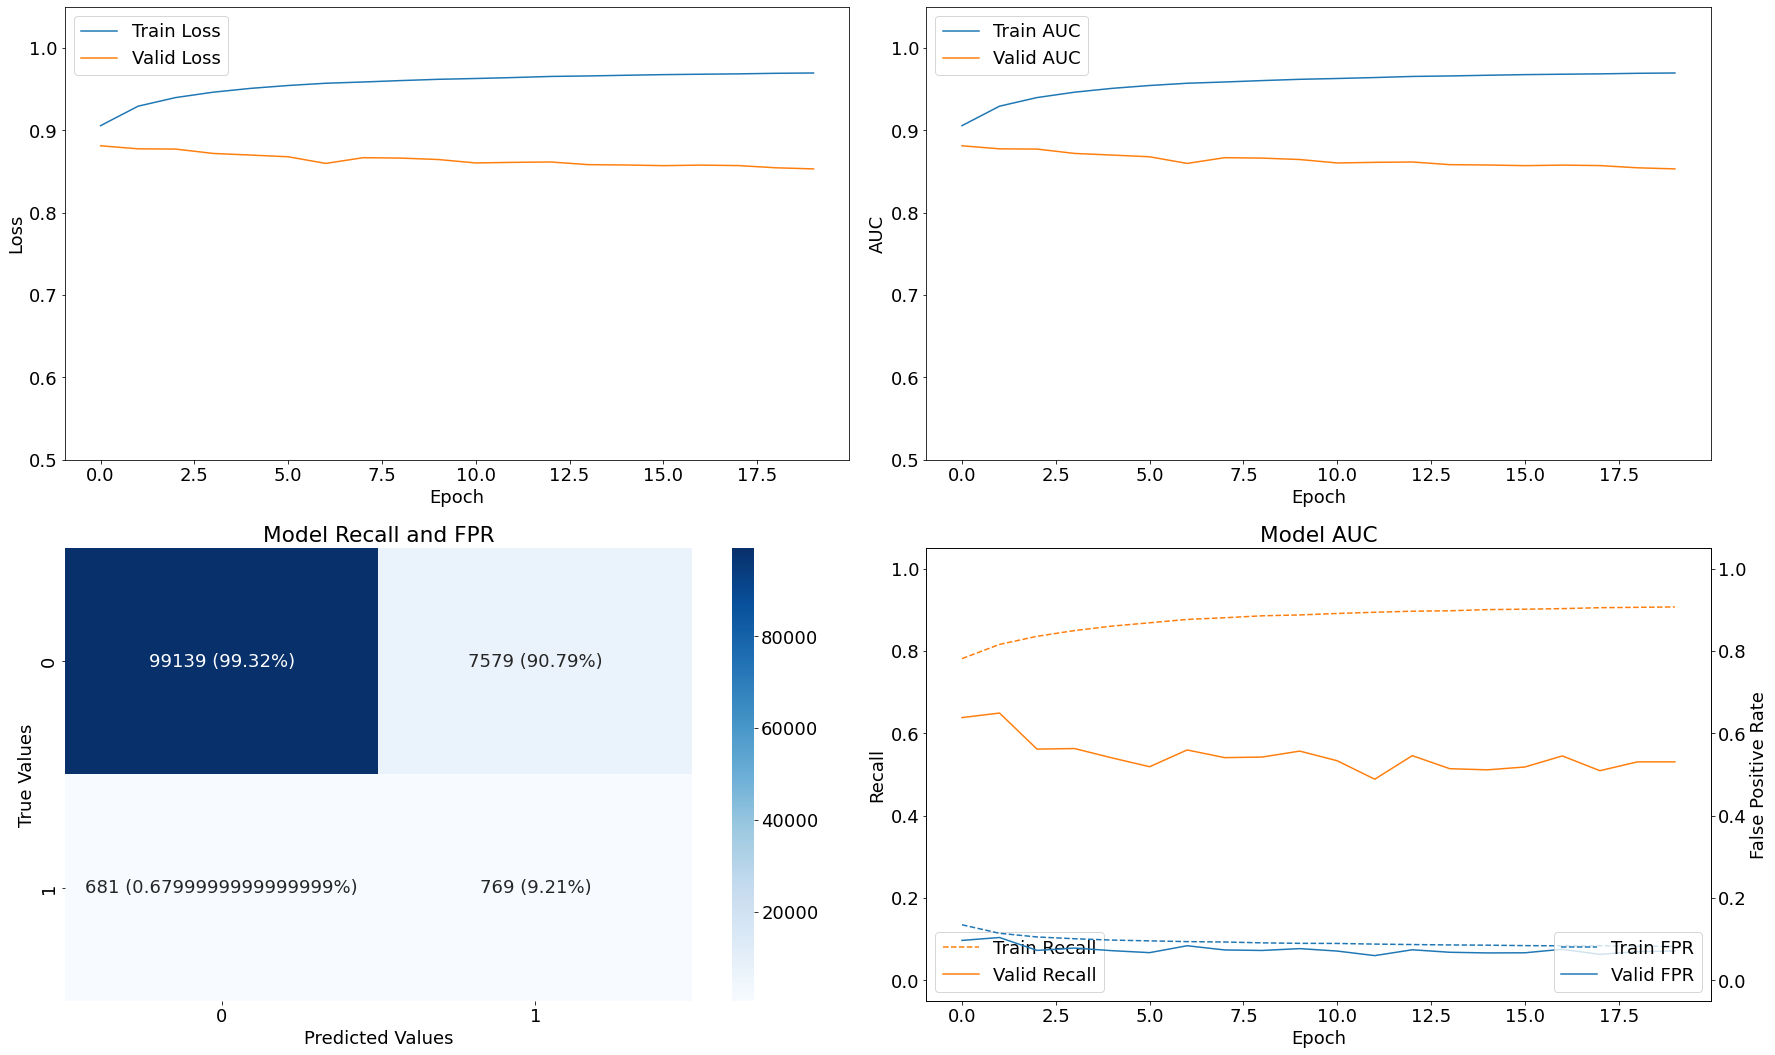

In [46]:
cross_model_v1(Xc_train_scaled_resampled, y_train_resampled, Xc_val_scaled, y_val)

In [47]:
def cross_model_v2(X_train, y_train, X_val, y_val, epochs=20, batch_size=512, threshold=0.5):
    
    b_cross_model_v2 = models.Sequential()

    b_cross_model_v2.add(layers.Input(shape=(cross_n_features, )))
    b_cross_model_v2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2()))
    b_cross_model_v2.add(layers.Dropout(0.5))
    b_cross_model_v2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2()))
    b_cross_model_v2.add(layers.Dropout(0.5))
    b_cross_model_v2.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2()))
    b_cross_model_v2.add(layers.Dropout(0.5))
    b_cross_model_v2.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.L2()))
    b_cross_model_v2.add(layers.Dense(8, activation='relu', kernel_regularizer=regularizers.L2()))
    b_cross_model_v2.add(layers.Dense(1, activation='sigmoid'))

    b_cross_model_v2.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_cross_model_v2_history = b_cross_model_v2.fit(X_train,
                                        y_train,
                                        batch_size=batch_size,
                                        validation_data=(X_val, y_val),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=1).history
    
    evaluate(b_cross_model_v2, b_cross_model_v2_history, X_val, y_val, threshold=threshold)

Epoch 1/20
1921/1921 [==============================] - 4s 2ms/step - loss: 0.8011 - auc: 0.8807 - recall_3: 0.7477 - false_positive_rate: 0.1475 - val_loss: 0.3889 - val_auc: 0.8797 - val_recall_3: 0.7269 - val_false_positive_rate: 0.1392
Epoch 2/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.6147 - auc: 0.8938 - recall_3: 0.7788 - false_positive_rate: 0.1423 - val_loss: 0.3544 - val_auc: 0.8792 - val_recall_3: 0.7069 - val_false_positive_rate: 0.1267
Epoch 3/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.6076 - auc: 0.8965 - recall_3: 0.7850 - false_positive_rate: 0.1421 - val_loss: 0.3445 - val_auc: 0.8792 - val_recall_3: 0.6959 - val_false_positive_rate: 0.1177
Epoch 4/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.6017 - auc: 0.8982 - recall_3: 0.7893 - false_positive_rate: 0.1415 - val_loss: 0.3930 - val_auc: 0.8803 - val_recall_3: 0.7331 - val_false_positive_rate: 0.1459
Epoch 5/20
1921/1921 [==================

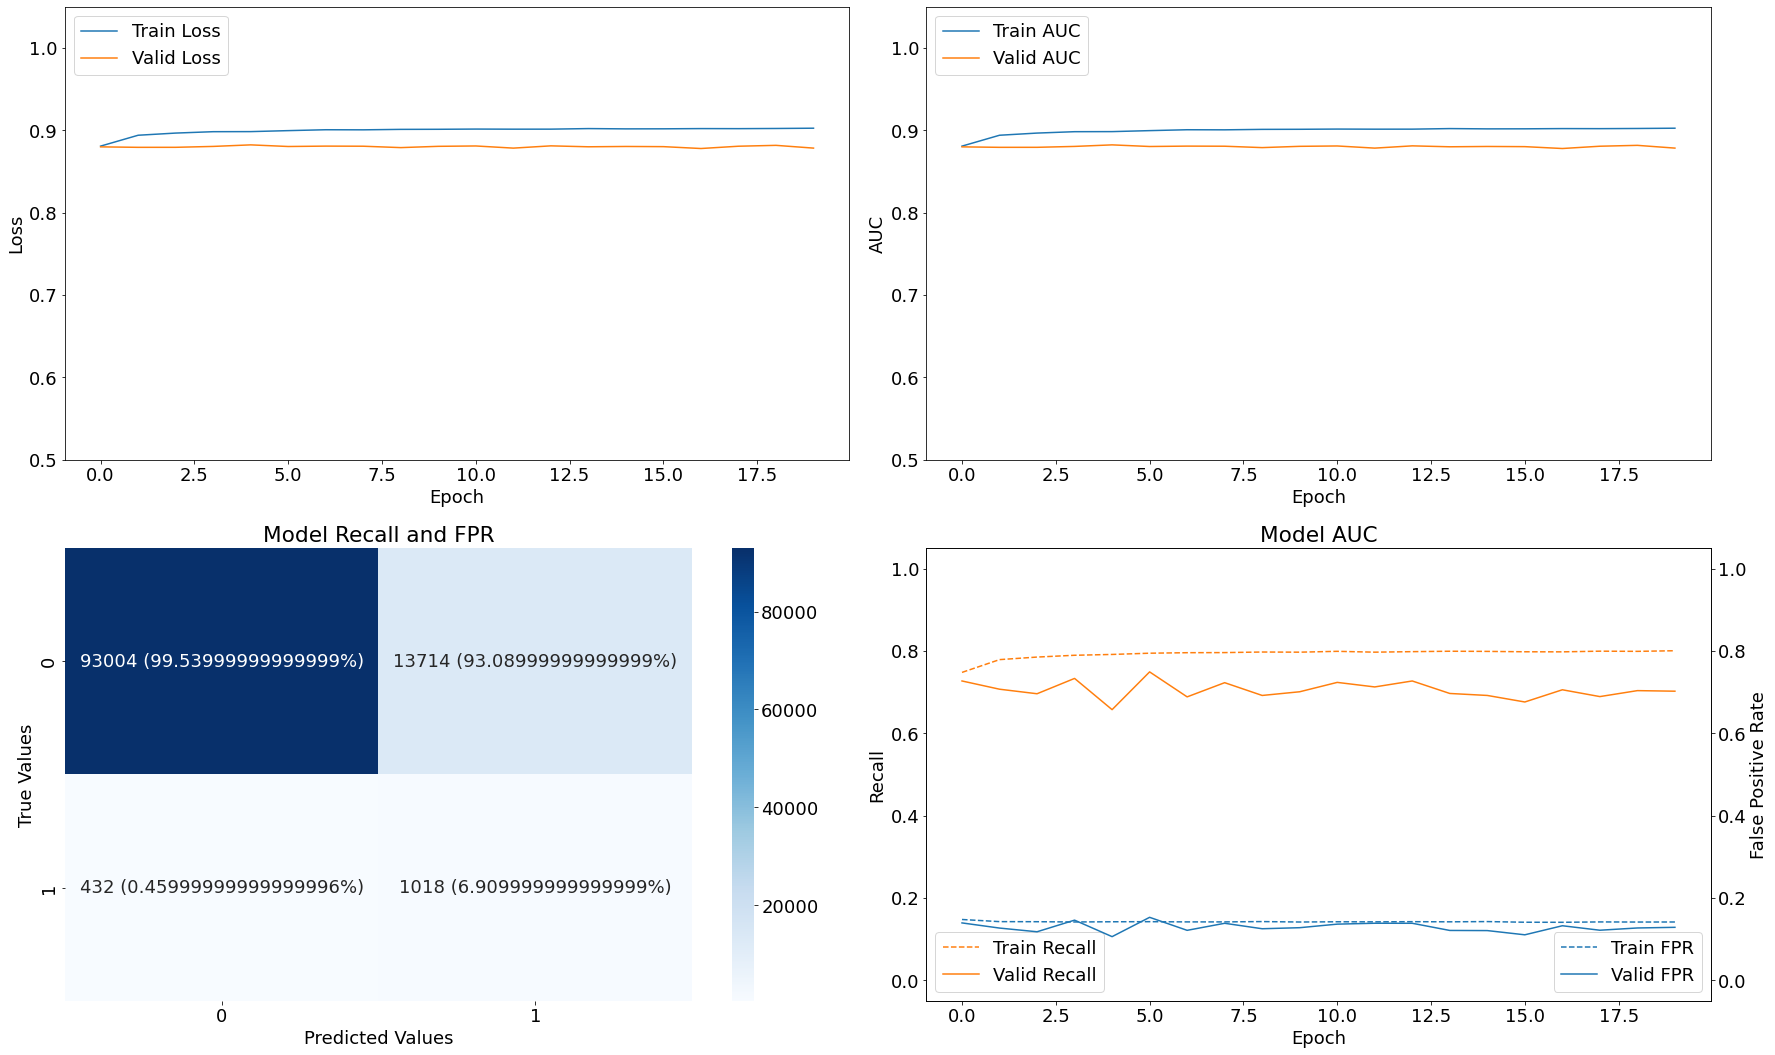

In [48]:
cross_model_v2(Xc_train_scaled_resampled, y_train_resampled, Xc_val_scaled, y_val)

Epoch 1/2
1921/1921 [==============================] - 4s 2ms/step - loss: 0.8484 - auc: 0.8822 - recall_4: 0.7612 - false_positive_rate: 0.1513 - val_loss: 0.3786 - val_auc: 0.8799 - val_recall_4: 0.7117 - val_false_positive_rate: 0.1375
Epoch 2/2
1921/1921 [==============================] - 4s 2ms/step - loss: 0.6161 - auc: 0.8941 - recall_4: 0.7884 - false_positive_rate: 0.1458 - val_loss: 0.3690 - val_auc: 0.8806 - val_recall_4: 0.7103 - val_false_positive_rate: 0.1331
Results for model with threshold = 0.5.

 Train recall: 0.7884235382080078 
 Val Recall: 0.7103448510169983 

 Train FPR: 0.14575299620628357 
 Val FPR: 0.1331171840429306


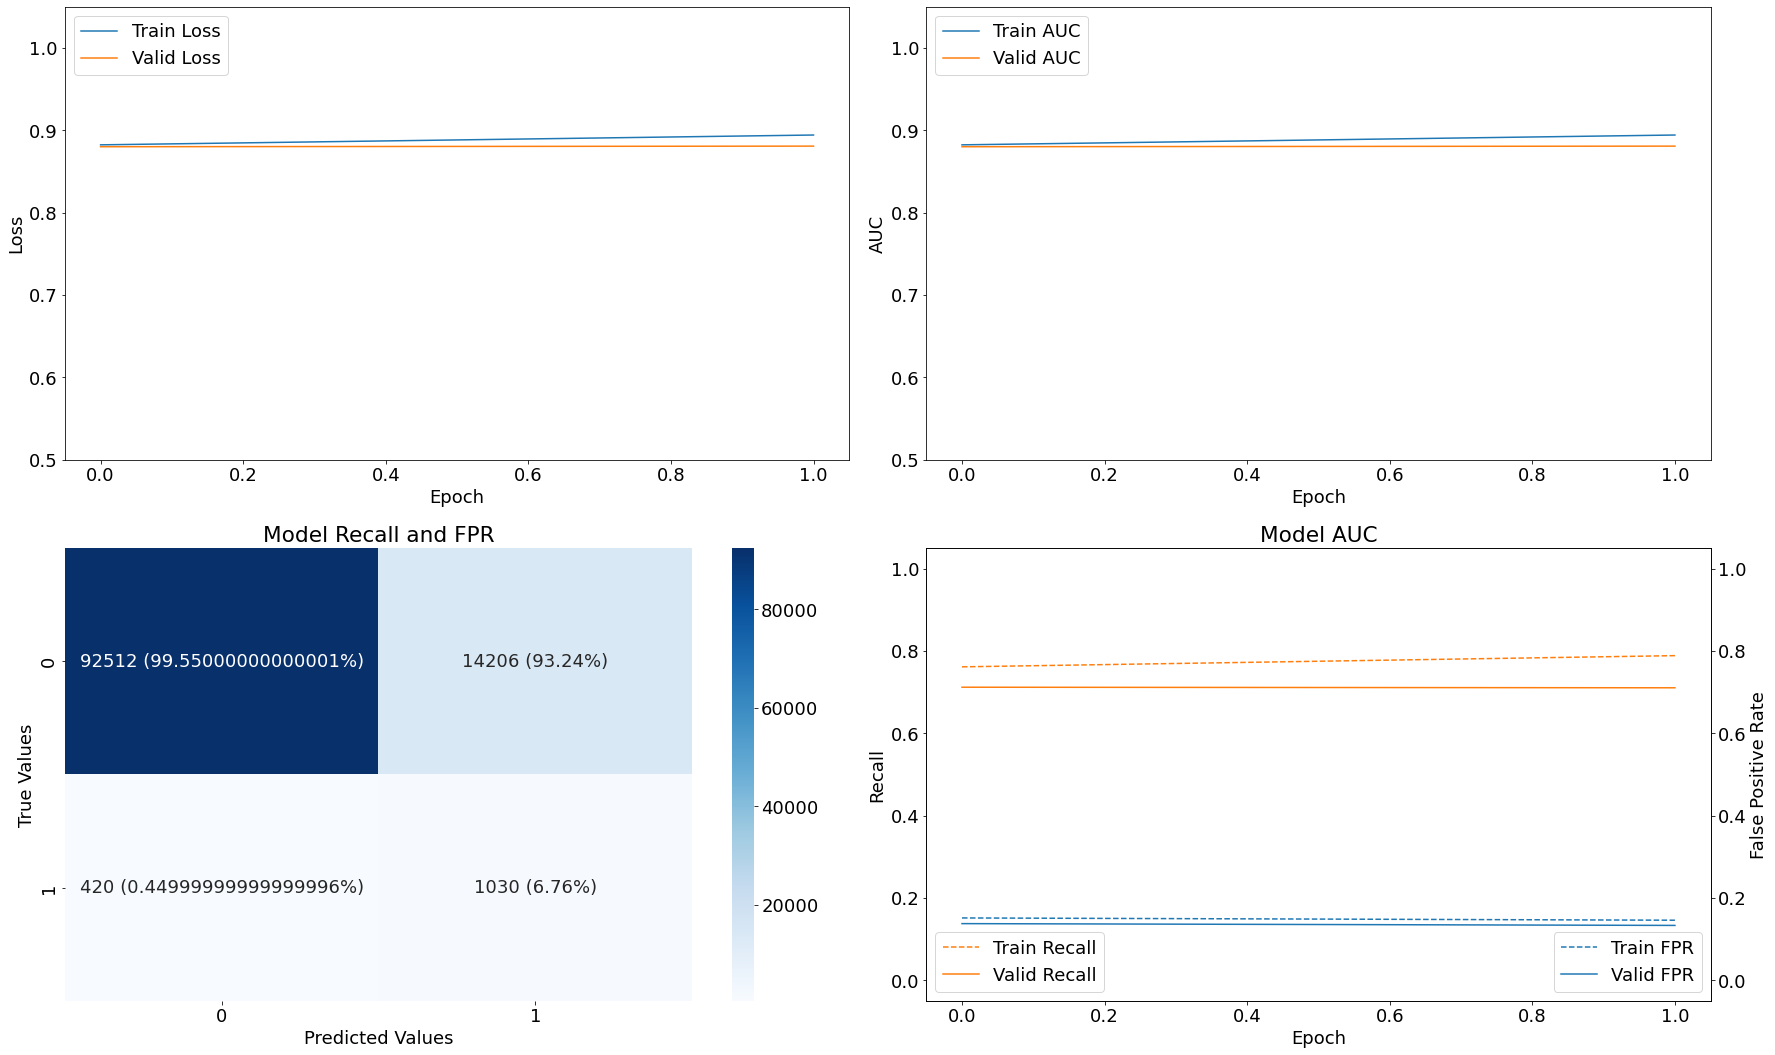

In [49]:
cross_model_v2(Xc_train_scaled_resampled, y_train_resampled, Xc_val_scaled, y_val, epochs=2)

In [50]:
def cross_model_v3(X_train, y_train, X_val, y_val, epochs=20, batch_size=512, threshold=0.5):
    
    b_cross_model_v3 = models.Sequential()

    b_cross_model_v3.add(layers.Input(shape=(cross_n_features, )))
    b_cross_model_v3.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2()))
    b_cross_model_v3.add(layers.Dropout(0.5))
    b_cross_model_v3.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2()))
    b_cross_model_v3.add(layers.Dropout(0.5))
    b_cross_model_v3.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.L2()))

    b_cross_model_v3.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_cross_model_v3_history = b_cross_model_v3.fit(X_train,
                                        y_train,
                                        batch_size=batch_size,
                                        validation_data=(X_val, y_val),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=1).history
    
    evaluate(b_cross_model_v3, b_cross_model_v3_history, X_val, y_val, threshold=threshold)

Epoch 1/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.7419 - auc: 0.8947 - recall_5: 0.7632 - false_positive_rate: 0.1383 - val_loss: 0.3518 - val_auc: 0.8809 - val_recall_5: 0.6903 - val_false_positive_rate: 0.1229
Epoch 2/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.5929 - auc: 0.9002 - recall_5: 0.7732 - false_positive_rate: 0.1364 - val_loss: 0.3659 - val_auc: 0.8824 - val_recall_5: 0.7048 - val_false_positive_rate: 0.1295
Epoch 3/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.5917 - auc: 0.9003 - recall_5: 0.7747 - false_positive_rate: 0.1377 - val_loss: 0.3977 - val_auc: 0.8814 - val_recall_5: 0.7393 - val_false_positive_rate: 0.1510
Epoch 4/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.5905 - auc: 0.9008 - recall_5: 0.7766 - false_positive_rate: 0.1379 - val_loss: 0.3536 - val_auc: 0.8815 - val_recall_5: 0.7007 - val_false_positive_rate: 0.1247
Epoch 5/20
1921/1921 [==================

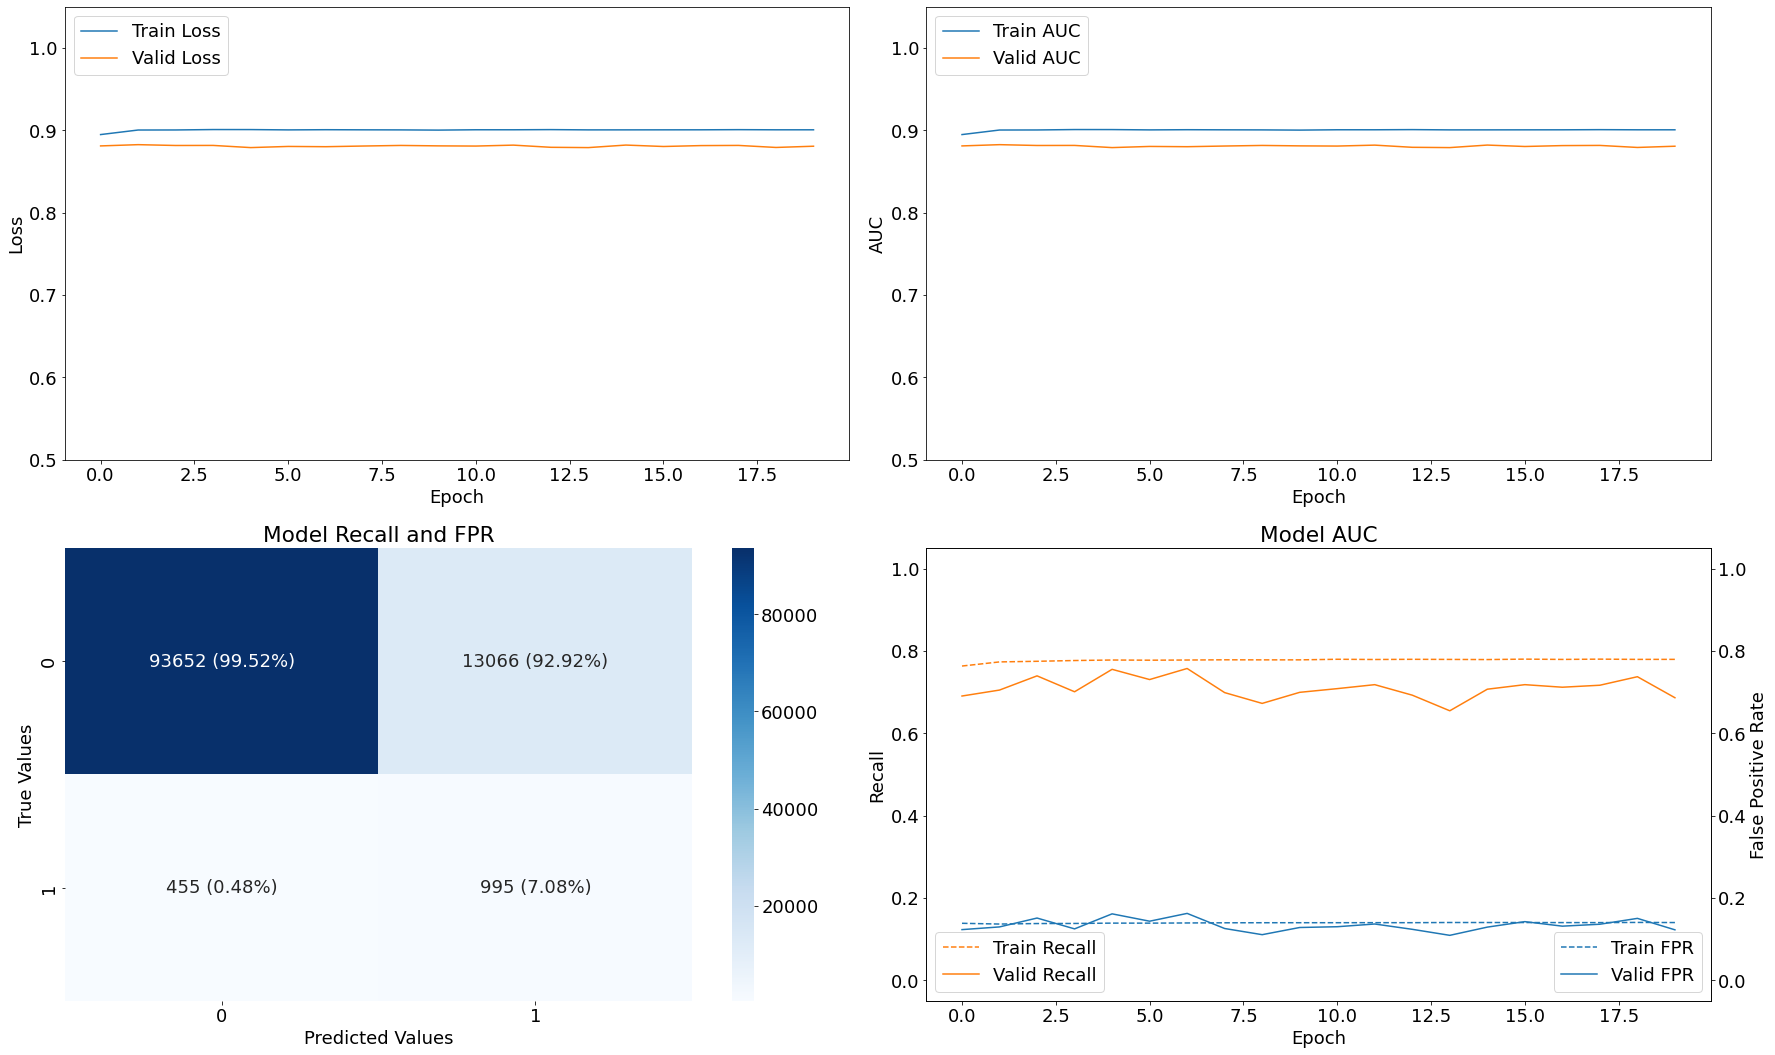

In [51]:
cross_model_v3(Xc_train_scaled_resampled, y_train_resampled, Xc_val_scaled, y_val)

In [52]:
for t in thresholds:
    cross_model_v3(Xc_train_scaled_resampled, y_train_resampled, Xc_val_scaled, y_val, threshold=t)

NameError: name 'thresholds' is not defined

In [ ]:
cross_model_v3(Xc_train_scaled_resampled, y_train_resampled, Xc_val_scaled, y_val, epochs=100)

In [ ]:
cross_model_v3(Xc_train_scaled_resampled, y_train_resampled, Xc_val_scaled, y_val, batch_size=32)

In [ ]:
def cross_model_v4(X_train, y_train, X_val, y_val, epochs=20, batch_size=512, threshold=0.5):
    
    b_cross_model_v4 = models.Sequential()

    b_cross_model_v4.add(layers.Input(shape=(cross_n_features, )))
    b_cross_model_v4.add(layers.Dense(64, activation='relu'))
    b_cross_model_v4.add(layers.Dropout(0.5))
    b_cross_model_v4.add(layers.Dense(32, activation='relu'))
    b_cross_model_v4.add(layers.Dropout(0.5))
    b_cross_model_v4.add(layers.Dense(1, activation='sigmoid'))

    b_cross_model_v4.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    b_cross_model_v4_history = b_cross_model_v4.fit(X_train,
                                        y_train,
                                        batch_size=batch_size,
                                        validation_data=(X_val, y_val),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=1).history
    
    evaluate(b_cross_model_v4, b_cross_model_v4_history, X_val, y_val, threshold=threshold)

In [ ]:
cross_model_v4(Xc_train_scaled_resampled, y_train_resampled, Xc_val_scaled, y_val)

In [145]:
import keras.backend as K

def custom_loss(cost_FP, cost_TP, cost_TN, cost_FN):
    def loss(y_true,y_pred):
        cost = y_true * K.log(y_pred)*cost_FN 
        + y_true * K.log(1-y_pred)*cost_TP \
        + (1-y_true) * K.log(1-y_pred) * cost_FP \
        + (1-y_true) * K.log(y_pred) * cost_TN
        return -K.mean(cost,axis=-1)
    return loss

In [146]:
cost_fp = 1
cost_fn = 1
cost_tp = 0
cost_tn = 0

In [149]:
def test(epochs=20, batch_size=512, threshold=0.5):    
    
    test = models.Sequential()

    test.add(layers.Input(shape=(n_features, )))
    test.add(layers.Dense(32, activation='relu'))
    test.add(layers.Dropout(0.5))
    test.add(layers.Dense(16, activation='relu'))
    test.add(layers.Dropout(0.5))
    test.add(layers.Dense(1, activation='sigmoid'))

    test.compile(optimizer='adam',
                       loss='mse',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    test_history = test.fit(X_train_scaled_resampled,
                                        y_train_resampled,
                                        batch_size=batch_size,
                                        validation_data=(X_val_scaled, y_val),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=1).history
    
    evaluate(test, test_history, X_val_scaled, y_val, threshold=threshold)

Epoch 1/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.1919 - auc: 0.8693 - recall_50: 0.7376 - false_positive_rate: 0.1578 - val_loss: 0.0853 - val_auc: 0.8747 - val_recall_50: 0.6655 - val_false_positive_rate: 0.1153
Epoch 2/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.1654 - auc: 0.8995 - recall_50: 0.7828 - false_positive_rate: 0.1319 - val_loss: 0.0865 - val_auc: 0.8766 - val_recall_50: 0.6559 - val_false_positive_rate: 0.1110
Epoch 3/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.1596 - auc: 0.9053 - recall_50: 0.7879 - false_positive_rate: 0.1244 - val_loss: 0.0844 - val_auc: 0.8773 - val_recall_50: 0.6352 - val_false_positive_rate: 0.0987
Epoch 4/20
1921/1921 [==============================] - 2s 1ms/step - loss: 0.1570 - auc: 0.9083 - recall_50: 0.7858 - false_positive_rate: 0.1185 - val_loss: 0.0796 - val_auc: 0.8782 - val_recall_50: 0.6200 - val_false_positive_rate: 0.0928
Epoch 5/20
1921/1921 [==========

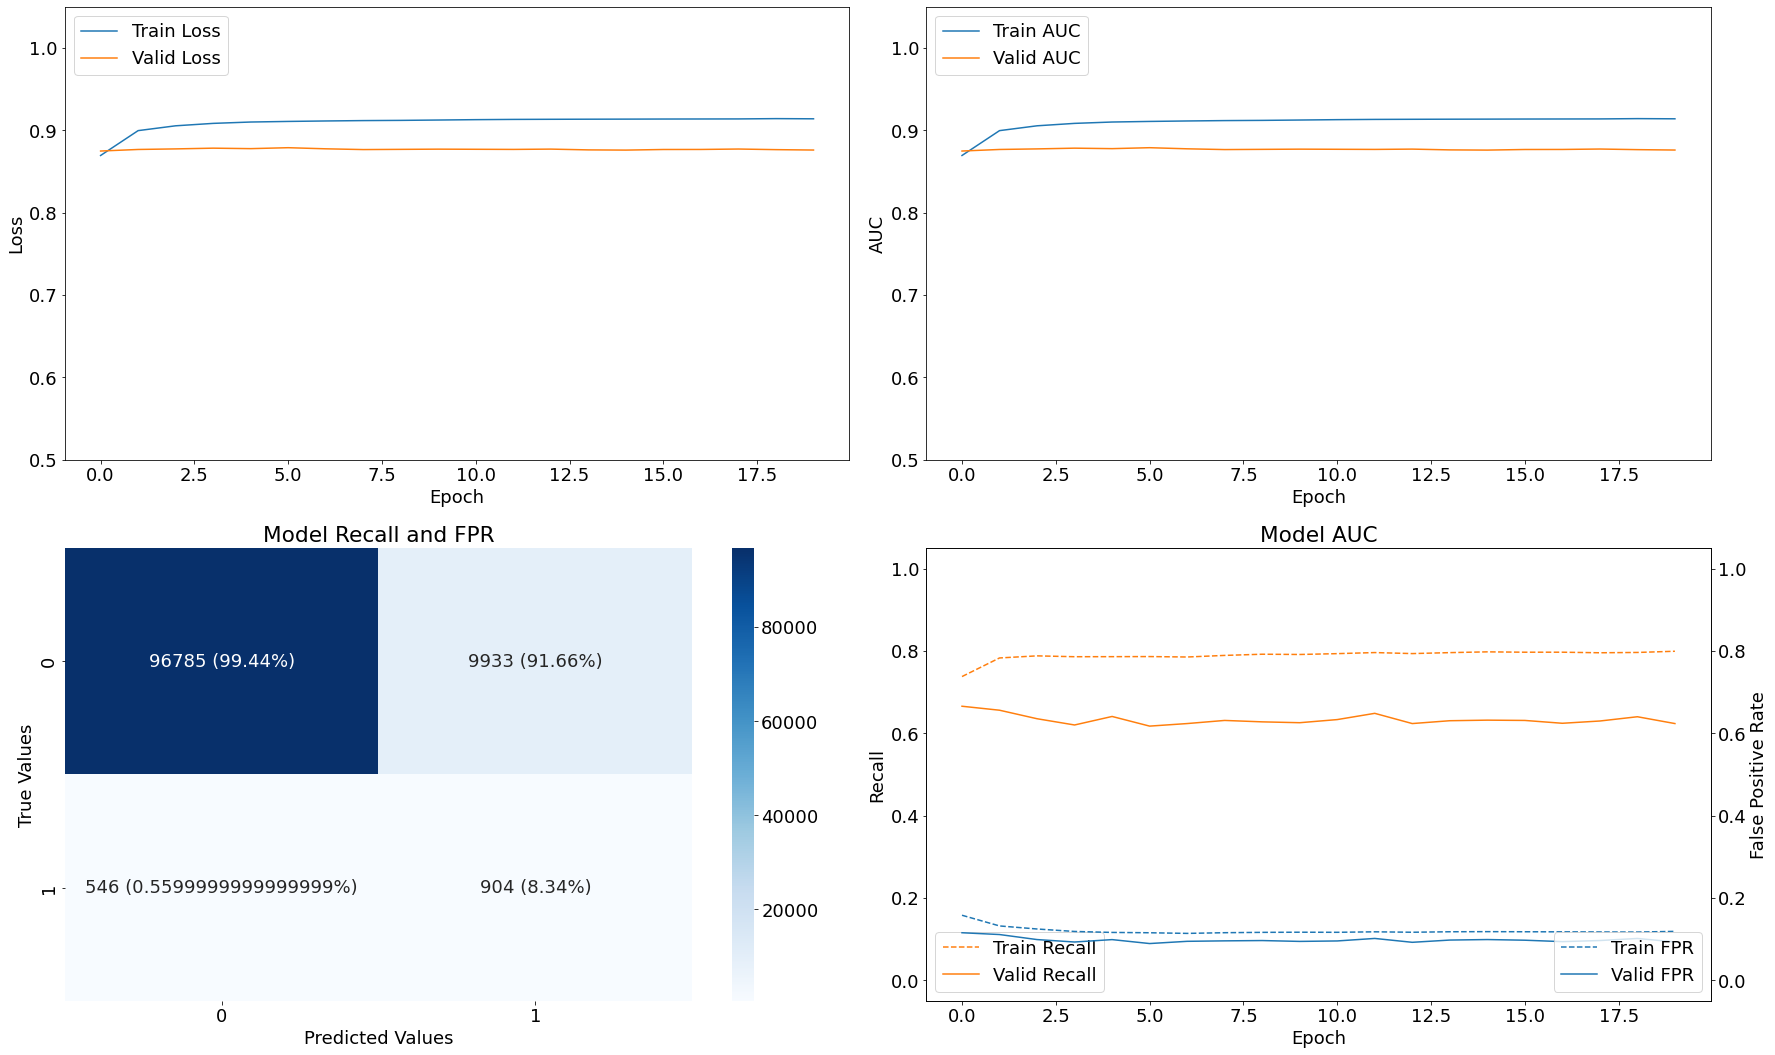

In [150]:
test()

In [152]:
def test2(X_train, y_train, X_val, y_val, epochs=20, batch_size=512, threshold=0.5):
    
    test2 = models.Sequential()

    test2.add(layers.Input(shape=(cross_n_features, )))
    test2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2()))
    test2.add(layers.Dropout(0.5))
    test2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2()))
    test2.add(layers.Dropout(0.5))
    test2.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.L2()))

    test2.compile(optimizer='adam',
                       loss='mse',
                       metrics=['AUC',
                                tf.keras.metrics.Recall(thresholds=threshold),
                                FalsePositiveRate(threshold=threshold)])

    test2_history = test2.fit(X_train,
                                        y_train,
                                        batch_size=batch_size,
                                        validation_data=(X_val, y_val),
                                        class_weight=class_weight,
                                        epochs=epochs,
                                        verbose=1).history
    
    evaluate(test2, test2_history, X_val, y_val, threshold=threshold)

Epoch 1/20
1921/1921 [==============================] - 4s 2ms/step - loss: 0.2958 - auc: 0.8841 - recall_51: 0.7363 - false_positive_rate: 0.1352 - val_loss: 0.1359 - val_auc: 0.8765 - val_recall_51: 0.6883 - val_false_positive_rate: 0.1267
Epoch 2/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.2146 - auc: 0.8876 - recall_51: 0.7409 - false_positive_rate: 0.1335 - val_loss: 0.1469 - val_auc: 0.8765 - val_recall_51: 0.7179 - val_false_positive_rate: 0.1459
Epoch 3/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.2144 - auc: 0.8875 - recall_51: 0.7400 - false_positive_rate: 0.1338 - val_loss: 0.1421 - val_auc: 0.8770 - val_recall_51: 0.7021 - val_false_positive_rate: 0.1366
Epoch 4/20
1921/1921 [==============================] - 3s 2ms/step - loss: 0.2144 - auc: 0.8874 - recall_51: 0.7403 - false_positive_rate: 0.1339 - val_loss: 0.1378 - val_auc: 0.8765 - val_recall_51: 0.7021 - val_false_positive_rate: 0.1331
Epoch 5/20
1921/1921 [==========

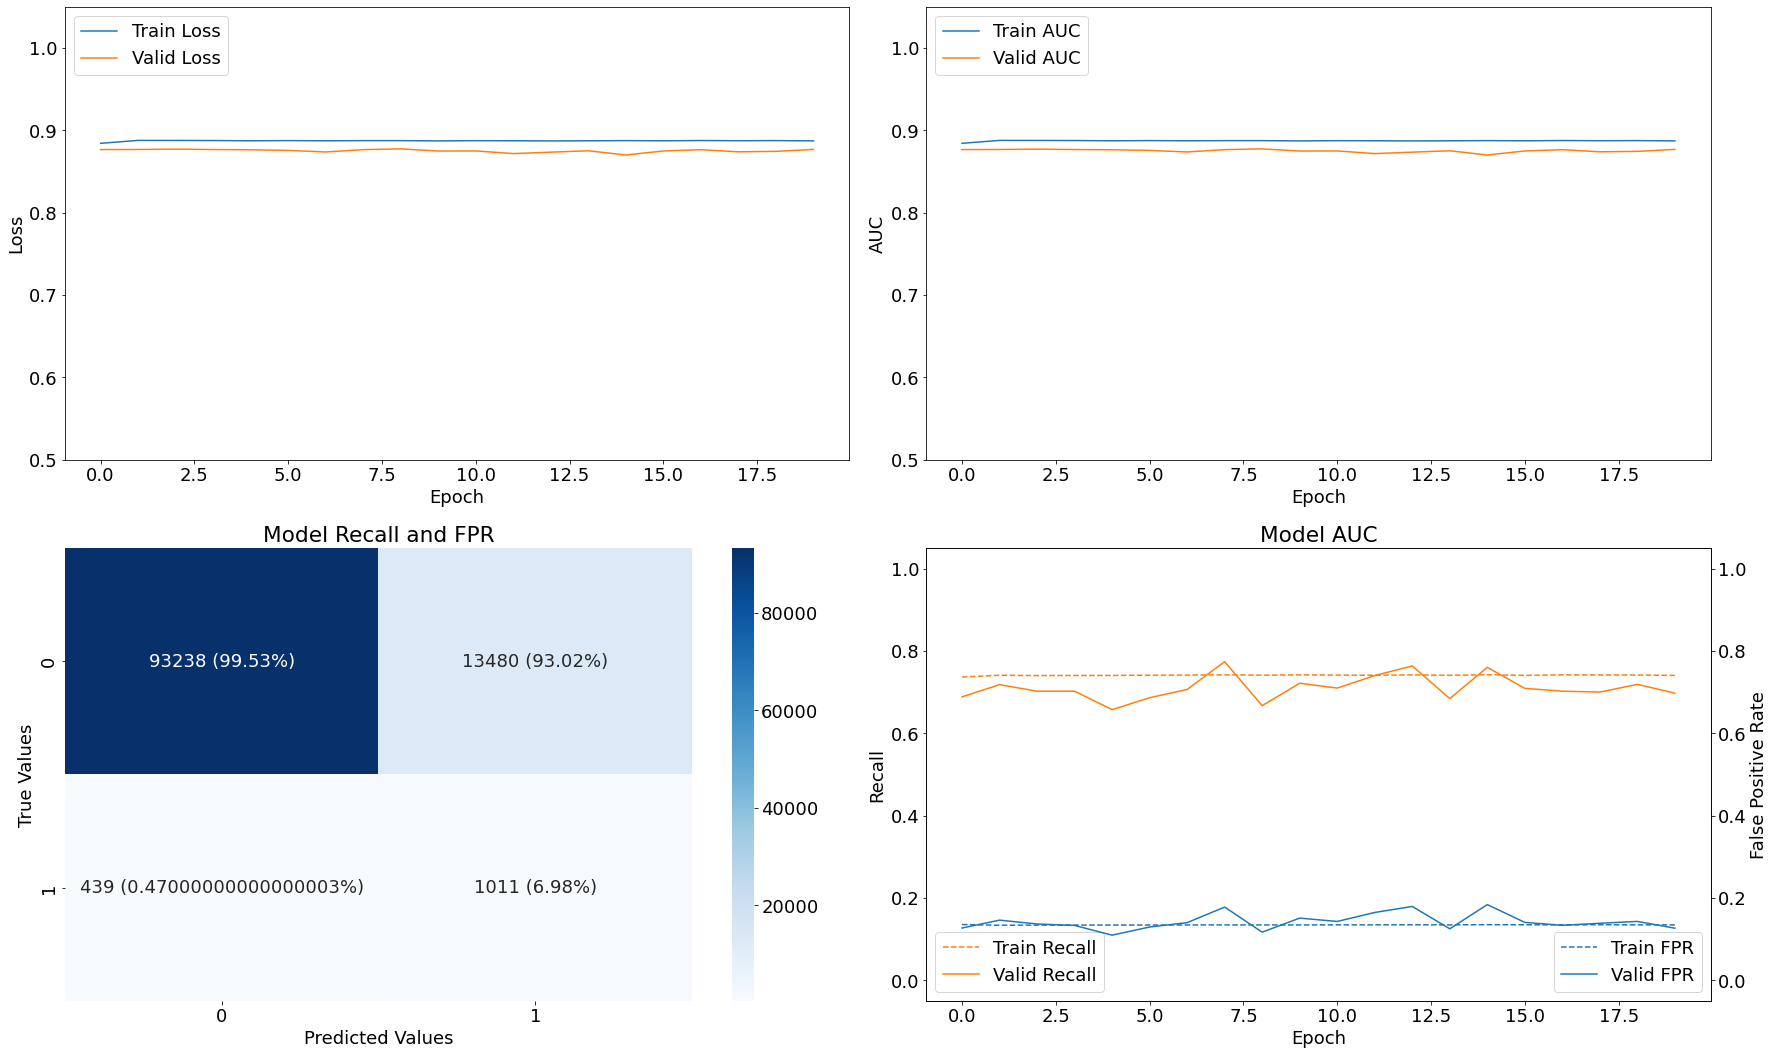

In [153]:
test2(Xc_train_scaled_resampled, y_train_resampled, Xc_val_scaled, y_val)